In [68]:
%matplotlib inline
from __future__ import absolute_import, division, print_function, unicode_literals
from builtins import range

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style("white")

from functools import partial
from joblib import delayed, Parallel
from mmit import MaxMarginIntervalTree
from mmit.core.solver import compute_optimal_costs
from mmit.metrics import mean_squared_error, zero_one_loss
from mmit.model import TreeExporter
from mmit.model_selection import GridSearchCV
from os import listdir, mkdir, system
from os.path import abspath, basename, exists, join
from shutil import rmtree as rmdir
from time import time

cool_contrasting_cmap = np.array(['#9FB2A4', '#5B4E51', '#997D87', '#15A08A', '#A079BF', '#00005F', '#A1C299', '#89412E', '#BCB1E5', '#47675D', '#76912F', '#885578', '#99ADC0', '#1BE177', '#404E55', '#789EC9', '#FF1A59', '#FFFFFE', '#061203', '#FF6832', '#D20096', '#8ADBB4', '#0060CD', '#63FFAC', '#A45B02', '#B79762', '#BEC459', '#A3A489', '#456D75', '#CA834E', '#59738A', '#E7AB63', '#3B9700', '#D7BFC2', '#3E89BE', '#B4A8BD', '#FFB500', '#658188', '#CCB87C', '#0086ED', '#886F4C', '#A4E804', '#8BB400', '#00846F', '#D16100', '#66796D', '#6A714A', '#5B656C', '#61615A', '#6367A9', '#252F99', '#1E6E00', '#C0B9B2', '#66E1D3', '#BC65E9', '#643127', '#518A87', '#C2FFED', '#92896B', '#837393', '#DA007C', '#E20027', '#6A3A4C', '#575329', '#A38469', '#F7C9BF', '#E773CE', '#B903AA', '#001C1E', '#00C6C8', '#797868', '#636375', '#FF90C9', '#004D43', '#E83000', '#D25B88', '#8FB0FF', '#00A6AA', '#FDE8DC', '#D0AC94', '#006A66', '#006C31', '#FFFF00', '#E4FFFC', '#6F0062', '#003109', '#BDC9D2', '#BE4700', '#BA0900', '#222800', '#943A4D', '#EEC3FF', '#0CBD66', '#7900D7', '#5EFF03', '#B77B68', '#000035', '#0AA6D8', '#D790FF', '#6B002C', '#FF913F', '#7A87A1', '#5B113C', '#391406', '#29201D', '#300018', '#402334', '#953F00', '#001E09', '#34362D', '#71BB8C', '#00B57F', '#83A485', '#5A0007', '#671190', '#A97399', '#A05837', '#FFDBE5', '#201625', '#3D4F44', '#320033', '#001325', '#9B9700', '#FC009C', '#CC0744', '#FAD09F', '#549E79', '#A88C85', '#8D8546', '#203B3C', '#04F757', '#6C8F7D', '#0AA3F7', '#013349', '#FEFFE6', '#FFA0F2', '#674E60', '#02684E', '#7C6571', '#1B4400', '#98D058', '#FEB2C6', '#372101', '#29607C', '#7A7BFF', '#006FA6', '#F5E1FF', '#C8A1A1', '#5B4534', '#365D25', '#C895C5', '#324E72', '#1E0200', '#788D66', '#958A9F', '#FF2F80', '#2F5D9B', '#866097', '#4A3B53', '#3B000A', '#004B28', '#4C6001', '#6C5E46', '#938A81', '#B5D6C3', '#7E6405', '#CB7E98', '#9C6966', '#78AFA1', '#DDEFFF', '#72418F', '#6B94AA', '#D157A0', '#BF5650', '#D83D66', '#D68E01', '#FF4A46', '#BC23FF', '#9FA064', '#353339', '#F4ABAA', '#374527', '#DFFB71', '#6B3A64', '#868E7E', '#00C2A0', '#3C3E6E', '#B5F4FF', '#5EBCD1', '#FFF69F', '#FFAA92', '#FF34FF', '#1A3A2A', '#64547B', '#7A4900', '#83AB58', '#A77500', '#A3C8C9', '#C2FF99', '#AA5199', '#A74571', '#D1F7CE', '#A30059', '#8CD0FF', '#806C66', '#012C58', '#9695C5', '#B88183', '#008941', '#3B5DFF', '#C8D0F6', '#D86A78', '#7ED379', '#6D80BA', '#7D5A44', '#00CCFF', '#452C2C', '#494B5A', '#9556BD', '#456648', '#EA8B66', '#4B8160', '#1CE6FF', '#895563', '#00FECF', '#A3F3AB', '#C86240', '#02525F', '#00D891', '#00489C', '#55813B', '#7B4F4B', '#0000A6', '#E98176', '#B894A6', '#D2DCD5', '#E704C4', '#4FC601', '#5B3213', '#772600', '#97979E', '#A76F42', '#DDB6D0', '#F4D749', '#51A058', '#75797C', '#B05B6F', '#809693', '#0045D2', '#C6005A', '#3A2465', '#FF8A9A', '#0089A3', '#DBD5DD', '#1D1702', '#FF5DA7', '#545C46', '#6B7900', '#9F94F0', '#513A01', '#453C23', '#C6DC99', '#3A3F00', '#00B433', '#922329', '#CCAA35', '#CFCDAC', '#962B75'])

In [69]:
class Dataset(object):
    def __init__(self, path):
        self.path = path
        feature_data = pd.read_csv(join(path, "features.csv"))
        self.X = feature_data.values
        self.feature_names = feature_data.columns.values
        del feature_data
        self.y = pd.read_csv(join(path, "targets.csv")).values
        self.folds = pd.read_csv(join(path, "folds.csv")).values.reshape(-1, )
        self.name = basename(path)
    
    @property
    def n_examples(self):
        return self.X.shape[0]
    
    @property
    def n_features(self):
        return self.X.shape[1]
    
def find_datasets(path):
    for d in listdir(path):
        if exists(join(path, d, "features.csv")) and \
           exists(join(path, d, "targets.csv")) and \
           exists(join(path, d, "folds.csv")):
            yield Dataset(abspath(join(path, d)))

datasets = list(find_datasets("./data"))

In [70]:
def evaluate_on_dataset(d, metric, result_dir):
    start_time = time()
    
    ds_result_dir = join(result_dir, d.name)
    if not exists(ds_result_dir):
        mkdir(ds_result_dir)
    
    fold_models = []
    fold_predictions = np.zeros(d.n_examples)
    fold_best_params = []
    fold_cv_results = []
    for fold in np.unique(d.folds):
        fold_train = d.folds != fold
        
        X_train = d.X[fold_train]
        y_train = d.y[fold_train]
        X_test = d.X[~fold_train]
        y_test = d.y[~fold_train]
        
        cv = GridSearchCV(estimator=MaxMarginIntervalTree(), param_grid=params, cv=10, n_jobs=-1, 
                          scoring=metric)
        cv.fit(X_train, y_train, d.feature_names)
        fold_predictions[~fold_train] = cv.predict(X_test)
        fold_models.append(cv.best_estimator_)
        fold_best_params.append(cv.best_params_)
        fold_cv_results.append(cv.cv_results_)
        
    print("MSE:", mean_squared_error(d.y, fold_predictions))
    print("ACC:", 1.0 - zero_one_loss(d.y, fold_predictions))
    open(join(ds_result_dir, "predictions.csv"), "w").write("\n".join(str(x) for x in fold_predictions))
    
    latex_exporter = TreeExporter("latex")
    string_exporter = TreeExporter("string")
    f_models = open(join(ds_result_dir, "models.tsv"), "w")
    for i, m in enumerate(fold_models):
        open(join(ds_result_dir, "model_fold_{0:d}.tex".format(i + 1)), "w").write(latex_exporter(m))
        f_models.write("{0:d}\t{1!s}\n".format((i + 1), string_exporter(m)))
    f_models.close()
    print("Took", time() - start_time, "seconds.")
    
    # Generate the PDF file for each tree
    build_cmd = "cd {0!s}; for i in ./model_fold_*.tex; do lualatex $i > /dev/null; rm ./*.aux ./*.log;done".format(ds_result_dir)
    !$build_cmd
    
    return fold_best_params, fold_cv_results

In [71]:
params = {"max_depth": [1000],
          "min_samples_split": [0],
          "margin": np.logspace(-4, 1, 20)}

def prep_result_dir(result_dir):
    if exists(result_dir):
       rmdir(result_dir)
    mkdir(result_dir)

def mse_metric(estimator, X, y):
    """
    Negative mean squared error, since GridSearchCV maximizes a metric
    """
    return -mean_squared_error(y_pred=estimator.predict(X), y_true=y)

params["loss"] = ["hinge"]
result_dir = "./predictions/mmit.linear.hinge"
prep_result_dir(result_dir)
linear_best_params_by_dataset = []
linear_cv_results_by_dataset = []
for d in datasets:
    print(d.name)
    best_hp, cv_results = evaluate_on_dataset(d, mse_metric, result_dir)
    linear_best_params_by_dataset.append(best_hp)
    linear_cv_results_by_dataset.append(cv_results)
    print()
    
params["loss"] = ["squared_hinge"]
result_dir = "./predictions/mmit.squared.hinge"
prep_result_dir(result_dir)
squared_best_params_by_dataset = []
squared_cv_results_by_dataset = []
for d in datasets:
    print(d.name)
    best_hp, cv_results = evaluate_on_dataset(d, mse_metric, result_dir)
    squared_best_params_by_dataset.append(best_hp)
    squared_cv_results_by_dataset.append(cv_results)
    print()

H3K27ac-H3K4me3_TDHAM_BP_FPOP
MSE: 0.494417901208
ACC: 0.832085561497
Took 721.303986073 seconds.

H3K27ac-H3K4me3_TDHAM_BP_joint
MSE: 0.137348119195
ACC: 0.93742478941
Took 87.3878729343 seconds.

H3K36me3_AM_immune_FPOP
MSE: 0.112451497491
ACC: 0.866666666667
Took 237.967478037 seconds.

H3K36me3_AM_immune_PDPA
MSE: 0.137794771768
ACC: 0.869294605809
Took 196.306420803 seconds.

H3K36me3_TDH_immune_FPOP
MSE: 0.086553046693
ACC: 0.892857142857
Took 21.1138329506 seconds.

H3K36me3_TDH_immune_joint
MSE: 0.0823273430578
ACC: 0.888888888889
Took 4.71259307861 seconds.

H3K36me3_TDH_immune_PDPA
MSE: 0.00195788711779
ACC: 0.928571428571
Took 19.4508349895 seconds.

H3K36me3_TDH_other_FPOP
MSE: 0.207903035218
ACC: 0.65
Took 13.0707929134 seconds.

H3K36me3_TDH_other_PDPA
MSE: 0.013009519089
ACC: 0.9375
Took 7.42609500885 seconds.

H3K4me3_PGP_immune_PDPA
MSE: 0.111497651151
ACC: 0.752475247525
Took 1155.26481104 seconds.

H3K4me3_TDH_immune_FPOP
MSE: 0.295206990007
ACC: 0.529100529101
Took 

JoblibSolverError: JoblibSolverError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    157     pkg_name = mod_name.rpartition('.')[0]
    158     main_globals = sys.modules["__main__"].__dict__
    159     if alter_argv:
    160         sys.argv[0] = fname
    161     return _run_code(code, main_globals, None,
--> 162                      "__main__", fname, loader, pkg_name)
        fname = '/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    163 
    164 def run_module(mod_name, init_globals=None,
    165                run_name=None, alter_sys=False):
    166     """Execute a module's code without importing it

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x1005edab0, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/alexa...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x1005edab0, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/alexa...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    398         
    399         if self.poller is not None:
    400             self.poller.start()
    401         self.kernel.start()
    402         try:
--> 403             ioloop.IOLoop.instance().start()
    404         except KeyboardInterrupt:
    405             pass
    406 
    407 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'params = {"max_depth": [1000],\n          "min...sults_by_dataset.append(cv_results)\n    print()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-04-20T00:09:35.414816', u'msg_id': u'92EFF7C2E6004BD5BD2D32C20E0D7030', u'msg_type': u'execute_request', u'session': u'43BB8841281A4FE280AB0546A60C071B', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'92EFF7C2E6004BD5BD2D32C20E0D7030', 'msg_type': u'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['43BB8841281A4FE280AB0546A60C071B']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'params = {"max_depth": [1000],\n          "min...sults_by_dataset.append(cv_results)\n    print()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-04-20T00:09:35.414816', u'msg_id': u'92EFF7C2E6004BD5BD2D32C20E0D7030', u'msg_type': u'execute_request', u'session': u'43BB8841281A4FE280AB0546A60C071B', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'92EFF7C2E6004BD5BD2D32C20E0D7030', 'msg_type': u'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['43BB8841281A4FE280AB0546A60C071B'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'params = {"max_depth": [1000],\n          "min...sults_by_dataset.append(cv_results)\n    print()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-04-20T00:09:35.414816', u'msg_id': u'92EFF7C2E6004BD5BD2D32C20E0D7030', u'msg_type': u'execute_request', u'session': u'43BB8841281A4FE280AB0546A60C071B', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'92EFF7C2E6004BD5BD2D32C20E0D7030', 'msg_type': u'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'params = {"max_depth": [1000],\n          "min...sults_by_dataset.append(cv_results)\n    print()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'params = {"max_depth": [1000],\n          "min...sults_by_dataset.append(cv_results)\n    print()'
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'params = {"max_depth": [1000],\n          "min...sults_by_dataset.append(cv_results)\n    print()', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.FunctionDef object>, <_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-71-18a8b573ae0d>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2820 
   2821         try:
   2822             for i, node in enumerate(to_run_exec):
   2823                 mod = ast.Module([node])
   2824                 code = compiler(mod, cell_name, "exec")
-> 2825                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10ec69930, file "<ipython-input-71-18a8b573ae0d>", line 33>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10ec69930, file "<ipython-input-71-18a8b573ae0d>", line 33>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10ec69930, file "<ipython-input-71-18a8b573ae0d>", line 33>
        self.user_global_ns = {'Dataset': <class '__main__.Dataset'>, 'GridSearchCV': <class 'mmit.model_selection.GridSearchCV'>, 'In': ['', u'get_ipython().magic(u\'matplotlib inline\')\nf...22329\', \'#CCAA35\', \'#CFCDAC\', \'#962B75\'])', u'class Dataset(object):\n    def __init__(self,...d)))\n\ndatasets = list(find_datasets("./data"))', u'def evaluate_on_dataset(d, metric, result_dir)... #!$build_cmd\n    \n    return fold_best_params', u'params = {"max_depth": [2],\n          "min_sa...dataset(d, mse_metric, result_dir))\n    print()', u'print(linear_best_params_by_dataset)', u'def evaluate_on_dataset(d, metric, result_dir)...  \n    return fold_best_params, fold_cv_results', u'params = {"max_depth": [2],\n          "min_sa...sults_by_dataset.append(cv_results)\n    print()', u'params = {"max_depth": [2],\n          "min_sa...sults_by_dataset.append(cv_results)\n    print()', u'linear_cv_results_by_dataset', u'plt.clf()\nplt.axhline(0.0, color="red", lines...del_sizes.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nplt.axhline(0.0, color="red", lines...del_sizes.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...d_margins.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nplt.axhline(0.0, color="red", lines...del_sizes.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...d_margins.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nmax_alpha = -1\nfor i, ds_hps in en...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nmax_alpha = -1\nfor i, ds_hps in en...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', ...], 'MaxMarginIntervalTree': <class 'mmit.learning.MaxMarginIntervalTree'>, 'Out': {9: [[[({...}, -0.62069055228488568), ({...}, -0.61869237824853829), ({...}, -0.5261942176115022), ({...}, -0.81299122353620201), ({...}, -0.62354956314772492), ({...}, -0.6199791390823326), ({...}, -0.52678246046565413), ({...}, -0.81715223290878769), ({...}, -0.6636251408522017), ({...}, -0.70359568121151028), ({...}, -0.84369338000621252), ({...}, -0.86398538882145193)], [({...}, -0.62196403015627577), ({...}, -0.60891176576573935), ({...}, -0.53240588461605864), ({...}, -0.9077192581943867), ({...}, -0.62618272241703232), ({...}, -0.61300190358606232), ({...}, -0.53370766570789585), ({...}, -0.90787408100522726), ({...}, -0.74811686008419631), ({...}, -0.7281647885169249), ({...}, -0.70104872393973083), ({...}, -0.94845655549840158)], [({...}, -0.61561192271511456), ({...}, -0.61760671724916849), ({...}, -0.51868067180070876), ({...}, -0.90228580063743669), ({...}, -0.62596755019548667), ({...}, -0.62180297516138061), ({...}, -0.51711174228976786), ({...}, -0.90374257026990568), ({...}, -0.72870092508114737), ({...}, -0.73994771617204824), ({...}, -0.60645179072408939), ({...}, -0.95275375415224173)], [({...}, -0.67172217411299928), ({...}, -0.64559228486300169), ({...}, -0.56548065253318103), ({...}, -0.91123908312242308), ({...}, -0.69337546797582983), ({...}, -0.65108912462834712), ({...}, -0.5662835149367853), ({...}, -0.915365616725062), ({...}, -0.87198683392459519), ({...}, -0.79327526993721142), ({...}, -0.6344757960834454), ({...}, -0.95766499045422404)], [({...}, -0.5990867107438913), ({...}, -0.59854931007495826), ({...}, -0.50105393450702729), ({...}, -0.86039956222887748), ({...}, -0.60038902973132369), ({...}, -0.59668532428935783), ({...}, -0.50474490033639219), ({...}, -0.86567674511126458), ({...}, -0.69867975258887138), ({...}, -0.72460717432466304), ({...}, -0.66600747583141195), ({...}, -0.90395327559827532)]], [[({...}, -0.12991474234464773), ({...}, -0.10473085870911669), ({...}, -0.093730980572684225), ({...}, -0.10390893218294028), ({...}, -0.13120697837018713), ({...}, -0.10583618176027614), ({...}, -0.09458464531754969), ({...}, -0.10452071566207152), ({...}, -0.16670961991685412), ({...}, -0.1630829770154455), ({...}, -0.16429877426327841), ({...}, -0.12734387948215106)], [({...}, -0.1802301960456634), ({...}, -0.16118981895093101), ({...}, -0.13551882692672923), ({...}, -0.1190516620016718), ({...}, -0.19331462864010535), ({...}, -0.17326662442409835), ({...}, -0.15103809150409536), ({...}, -0.12011518331540287), ({...}, -0.21321336419268611), ({...}, -0.2339886864772816), ({...}, -0.15285730200739039), ({...}, -0.15517679082458904)], [({...}, -0.227666534244713), ({...}, -0.21145046358797082), ({...}, -0.16738335612447841), ({...}, -0.14510782520544382), ({...}, -0.22588901540485257), ({...}, -0.21192587502805643), ({...}, -0.16736077978744104), ({...}, -0.14573974256488603), ({...}, -0.24313017466347531), ({...}, -0.25715957966972969), ({...}, -0.1915878741847504), ({...}, -0.17291955503492457)], [({...}, -0.2059949530849336), ({...}, -0.17339690257420243), ({...}, -0.15224144385631122), ({...}, -0.1311241254670282), ({...}, -0.20711597356445646), ({...}, -0.17300292969294531), ({...}, -0.15078191967813978), ({...}, -0.13155722655967023), ({...}, -0.31444126510874448), ({...}, -0.31267500915854363), ({...}, -0.18933183933450554), ({...}, -0.14894197502549547)], [({...}, -0.15418428548577887), ({...}, -0.1368404056761468), ({...}, -0.14871443395077763), ({...}, -0.11652236965190869), ({...}, -0.15395601196006237), ({...}, -0.13644687013892137), ({...}, -0.1484041165749061), ({...}, -0.11696461087893831), ({...}, -0.27580199897874358), ({...}, -0.27170604587204067), ({...}, -0.16710453468439282), ({...}, -0.13308259982323706)]], [[({...}, -0.060705739870937837), ({...}, -0.062498912616938129), ({...}, -0.11182877811963263), ({...}, -0.10091467312651123), ({...}, -0.063988789486638872), ({...}, -0.069810730622720002), ({...}, -0.086330813512033991), ({...}, -0.10185355751324598), ({...}, -0.063881346602761638), ({...}, -0.069078230363674192), ({...}, -0.084057618479260243), ({...}, -0.10681376491788588)], [({...}, -0.12412621309555918), ({...}, -0.12759554978304749), ({...}, -0.12038818491403805), ({...}, -0.1409298867395303), ({...}, -0.12405685294357705), ({...}, -0.1261483309221097), ({...}, -0.11988639572016493), ({...}, -0.14182372054664633), ({...}, -0.10942570995247949), ({...}, -0.11789645629171067), ({...}, -0.11665068967002087), ({...}, -0.15017893489247364)], [({...}, -0.13861029422625465), ({...}, -0.13897544950402088), ({...}, -0.1415121870910771), ({...}, -0.12198931505911421), ({...}, -0.13604478478841589), ({...}, -0.13832502463068885), ({...}, -0.14092610162117108), ({...}, -0.12287633275432411), ({...}, -0.13276443170489949), ({...}, -0.13548288685253734), ({...}, -0.1371317300367759), ({...}, -0.12250478272746197)], [({...}, -0.20848088860160036), ({...}, -0.19967415150157661), ({...}, -0.15825250251595938), ({...}, -0.12197531905164032), ({...}, -0.21379343718151805), ({...}, -0.20624530600580054), ({...}, -0.15407706925823211), ({...}, -0.12258666895477359), ({...}, -0.11459725867485729), ({...}, -0.12372524458836771), ({...}, -0.10500514629765864), ({...}, -0.12001582043456398)], [({...}, -0.12817221186519848), ({...}, -0.13332263336293124), ({...}, -0.13559358853136744), ({...}, -0.11482521903426632), ({...}, -0.12363530803784659), ({...}, -0.1221595461308661), ({...}, -0.12884695075598451), ({...}, -0.11391429529851564), ({...}, -0.095835193399800553), ({...}, -0.095166984839908014), ({...}, -0.096763579227907834), ({...}, -0.11771435756597218)]], [[({...}, -0.31056150903176488), ({...}, -0.32988749383210036), ({...}, -0.31290945106681345), ({...}, -0.15181847229875295), ({...}, -0.30927069738425805), ({...}, -0.33071616867572279), ({...}, -0.31721997423380621), ({...}, -0.15238554142087724), ({...}, -0.27188295220614889), ({...}, -0.28128896429835171), ({...}, -0.20432987743923317), ({...}, -0.1420367789683111)], [({...}, -0.22235840695396628), ({...}, -0.21777048761896006), ({...}, -0.22737869161928237), ({...}, -0.16493076297100659), ({...}, -0.22522441446596297), ({...}, -0.2209281377408146), ({...}, -0.22982892185197076), ({...}, -0.16485877554387707), ({...}, -0.26269865265046993), ({...}, -0.26107172372582937), ({...}, -0.2270769314314724), ({...}, -0.16018121499037394)], [({...}, -0.28290697442359786), ({...}, -0.28290697442359786), ({...}, -0.16990521442219292), ({...}, -0.31277494332205119), ({...}, -0.31277494332205119), ({...}, -0.17142875384084433), ({...}, -0.36260819996751326), ({...}, -0.3720051622830946), ({...}, -0.35216127439476819), ({...}, -0.15817970931492006)], [({...}, -0.28036471593689183), ({...}, -0.29808571581663268), ({...}, -0.32878614013438906), ({...}, -0.15144052837324554), ({...}, -0.26790081057837378), ({...}, -0.28058334831846932), ({...}, -0.32599638708775935), ({...}, -0.1495176078766341), ({...}, -0.2448960479626397), ({...}, -0.23465040076717819), ({...}, -0.19552847995694633), ({...}, -0.13868995730519509)], [({...}, -0.30120498661126638), ({...}, -0.35080604269964499), ({...}, -0.15796757097581801), ({...}, -0.3139943279165841), ({...}, -0.37516645601441118), ({...}, -0.1575037087708063), ({...}, -0.25437535572881126), ({...}, -0.26350400386288386), ({...}, -0.23091910239256669), ({...}, -0.14207631565965123)]], [[({...}, -0.046631456341471048), ({...}, -0.045912113574880287), ({...}, -0.041357166341901751), ({...}, -0.046556440276233034), ({...}, -0.044444838262656376), ({...}, -0.041119483045858926), ({...}, -0.042801805128598686), ({...}, -0.047803023579497436), ({...}, -0.0474154982316655), ({...}, -0.03931265684156033)], [({...}, -0.015007238758798724), ({...}, -0.016432685152698894), ({...}, -0.026982787619915644), ({...}, -0.022256637388258987), ({...}, -0.024525582656594151), ({...}, -0.026249710613480293), ({...}, -0.050719609469179361), ({...}, -0.050866630669222167), ({...}, -0.052882823048034266), ({...}, -0.037962968051048623)], [({...}, -0.094801945138389979), ({...}, -0.1007634834289763), ({...}, -0.051544757319524862), ({...}, -0.094726487381305305), ({...}, -0.10155171500129374), ({...}, -0.053416487296340763), ({...}, -0.063435372604335821), ({...}, -0.060805717868042418), ({...}, -0.065514309041875385), ({...}, -0.044878214108461413)], [({...}, -0.047824929931156987), ({...}, -0.042862237063493042), ({...}, -0.035448881572941078), ({...}, -0.04753578241298622), ({...}, -0.039599707050909504), ({...}, -0.034653407073019248), ({...}, -0.026434023986046901), ({...}, -0.026440744296775176), ({...}, -0.028815610029300675), ({...}, -0.035487790872302319)], [({...}, -0.1141073070335306), ({...}, -0.11675938926753648), ({...}, -0.033190980463664282), ({...}, -0.11455670064531312), ({...}, -0.11670014004119741), ({...}, -0.032790589606709622), ({...}, -0.038433620861604095), ({...}, -0.04682222812472403), ({...}, -0.046760443482185748), ({...}, -0.038658073674392425)]], [[({...}, -0.11733171626868785), ({...}, -0.11283782511047499), ({...}, -0.11733170801637885), ({...}, -0.11207287710414707), ({...}, -0.35283409589692777), ({...}, -0.35283409589692777), ({...}, -0.29521807619037332), ({...}, -0.24164514751279498)], [({...}, -0.15417941410127944), ({...}, -0.15417941410127944), ({...}, -0.11197627139036186), ({...}, -0.15417937690386169), ({...}, -0.15437097863599075), ({...}, -0.11153782426677876), ({...}, -0.23054842308253726), ({...}, -0.2987698877861108), ({...}, -0.19218109382204984)], [({...}, 0.0), ({...}, 0.0), ({...}, -0.031484168785591106), ({...}, -0.01193172588560934), ({...}, -0.00057704432989893681)], [({...}, -0.24570849029680492), ({...}, -0.24001652857339653), ({...}, -0.19717863414357337), ({...}, -0.24463685868375182), ({...}, -0.19679715086371535), ({...}, -0.29477821647186714), ({...}, -0.29477821647186714), ({...}, -0.23762764065981798)], [({...}, -0.15417941410127944), ({...}, -0.15417941410127944), ({...}, -0.11197627139036186), ({...}, -0.15417937690386169), ({...}, -0.15437097863599075), ({...}, -0.11153782426677876), ({...}, -0.23097573332782403), ({...}, -0.29781080973793), ({...}, -0.21997310936679021)]], [[({...}, -0.0058032560762959814), ({...}, -0.0040717947883662153), ({...}, -0.0055949589710729414), ({...}, -0.0051745865919792314), ({...}, -0.0010229057983063422), ({...}, -0.0012688596751583817), ({...}, -0.0048838890519087904), ({...}, -0.0031343020614512758)], [({...}, -0.0079428204014392306), ({...}, -0.00780719919776246), ({...}, -0.0097866530036375184), ({...}, -0.015177038317503676), ({...}, -0.011271313259986654), ({...}, -0.0099011674603711394), ({...}, -0.0076651546225180636), ({...}, -0.014691005979016045), ({...}, -0.017374829931334674), ({...}, -0.01367501162074799)], [({...}, -0.014911957140160864), ({...}, -0.014928780979857881), ({...}, -0.01169188544057124), ({...}, -0.016547221851128224), ({...}, -0.014641590725921944), ({...}, -0.011616891656456635), ({...}, -0.0029732478876297653), ({...}, -0.0049198778818517769), ({...}, -0.0047777163859656028), ({...}, -0.01563712650854231)], [({...}, -0.019206145378003397), ({...}, -0.016265522844781031), ({...}, -0.014611472639173137), ({...}, -0.01486041562550262), ({...}, -0.015006701453080407), ({...}, -0.014290023624198367), ({...}, -0.0062397819600643291), ({...}, -0.0071228762023196291), ({...}, -0.016840521824476262), ({...}, -0.019361707289476292)], [({...}, -0.019212457702689964), ({...}, -0.016251178084536966), ({...}, -0.015046728952712626), ({...}, -0.013760012487408413), ({...}, -0.01926762534864376), ({...}, -0.014997980387391729), ({...}, -0.0022470791275306474), ({...}, -0.0052270443558023998), ({...}, -0.0052270443558023998), ({...}, -0.014058472232698524)]], [[({...}, -0.43309311689837349), ({...}, -0.3555890572547919), ({...}, -0.14586308587986382), ({...}, -0.45606152822108992), ({...}, -0.35461017854436061), ({...}, -0.14281068986303996), ({...}, -0.2331002319864714), ({...}, -0.23376788336789089), ({...}, -0.31058905280437205), ({...}, -0.1500905715376914)], [({...}, -0.25308402663554935), ({...}, -0.1998115369447325), ({...}, -0.22032985217890011), ({...}, -0.15670857705007871), ({...}, -0.21914839840337458), ({...}, -0.20390528061281285), ({...}, -0.22371505551436352), ({...}, -0.16049630026954934), ({...}, -0.22158544150468767), ({...}, -0.23798221361854113), ({...}, -0.097134738941133017), ({...}, -0.22400749093810229)], [({...}, -0.23165078022586738), ({...}, -0.19577179894902516), ({...}, -0.15213062303818212), ({...}, -0.092863543718773089), ({...}, -0.23409301428570567), ({...}, -0.23444694909728922), ({...}, -0.091818148850904294), ({...}, -0.25047997203353817), ({...}, -0.13771885465709635), ({...}, -0.13404202435021648), ({...}, -0.084216635391544628)], [({...}, -0.44270341463983998), ({...}, -0.38252183285902525), ({...}, -0.3269657235187583), ({...}, -0.17845591356141249), ({...}, -0.39411193441228276), ({...}, -0.38433082071256269), ({...}, -0.33680024738174691), ({...}, -0.18347903046998054), ({...}, -0.19129339955400282), ({...}, -0.21699139523345673), ({...}, -0.23800807092146398), ({...}, -0.21225999340543833)], [({...}, -0.6140577174411822), ({...}, -0.52199190412742191), ({...}, -0.13040041433222196), ({...}, -0.60241986650983281), ({...}, -0.59471100065745663), ({...}, -0.13282602339961846), ({...}, -0.6255031939352087), ({...}, -0.40155693213758026), ({...}, -0.29155263123098052), ({...}, -0.18616274981625094)]], [[({...}, -0.022479213972753452), ({...}, -0.044885623654088248), ({...}, -0.022479213972753452), ({...}, -0.047034487221729232), ({...}, -0.017835954993773016), ({...}, -0.017834888543808932), ({...}, -0.097472204888361821)], [({...}, -0.048711742775500375), ({...}, -0.089825502437021809), ({...}, -0.048711742775500375), ({...}, -0.09466778313639973), ({...}, -0.0018865981519806407), ({...}, -0.0024622889672528576), ({...}, -0.12778087423255663)], [({...}, -0.15962853215456499), ({...}, -0.10814966309809795), ({...}, -0.15962860054770964), ({...}, -0.11593625754046835), ({...}, -0.11059038688468106), ({...}, -0.11098111542955813), ({...}, -0.15232054205034404)], [({...}, -0.044360494671645663), ({...}, -0.10461416090432625), ({...}, -0.044360531343911089), ({...}, -0.11086869426883265), ({...}, -0.0018865981519806407), ({...}, -0.0018865981519806407), ({...}, -0.15455449988911502)], [({...}, -0.060112552579049572), ({...}, -0.10016839364259149), ({...}, -0.06011260817619328), ({...}, -0.10215957673306808), ({...}, -0.013141293526854536), ({...}, -0.0019029057401353487), ({...}, -0.11873314657081639)]], [[({...}, -0.13506788028433592), ({...}, -0.14347497799598358), ({...}, -0.13139505130850465), ({...}, -0.19702319467745721), ({...}, -0.13508314271237071), ({...}, -0.14310921041983554), ({...}, -0.13137581387929026), ({...}, -0.1969621760045997), ({...}, -0.20494832685555645), ({...}, -0.20113342743571555), ({...}, -0.18621109206643074), ({...}, -0.1984694315202403)], [({...}, -0.17575196160118542), ({...}, -0.16707090830848692), ({...}, -0.14809986815219317), ({...}, -0.21511017906259555), ({...}, -0.17191363525955405), ({...}, -0.16276093735302663), ({...}, -0.1450347451480774), ({...}, -0.21429934268820797), ({...}, -0.18405350578790608), ({...}, -0.19607903921808928), ({...}, -0.22199296071932273), ({...}, -0.21675417574432698)], [({...}, -0.16074194591686103), ({...}, -0.15178463126592387), ({...}, -0.15150494642913376), ({...}, -0.22120464685166485), ({...}, -0.16133290603945222), ({...}, -0.15248317933783981), ({...}, -0.15283217108029351), ({...}, -0.22073357975651514), ({...}, -0.15243630137394912), ({...}, -0.17064826119965557), ({...}, -0.17233234383215007), ({...}, -0.21622599878630008)], [({...}, -0.14519814153337091), ({...}, -0.14628686965532917), ({...}, -0.14885966290332733), ({...}, -0.20173764636606034), ({...}, -0.14700902385147335), ({...}, -0.1455790296422475), ({...}, -0.14807874936942261), ({...}, -0.20080346650992667), ({...}, -0.16514478892216625), ({...}, -0.19367438441257784), ({...}, -0.19854698263476017), ({...}, -0.20195528987231365)], [({...}, -0.12806536119917877), ({...}, -0.1338015672358977), ({...}, -0.10273262560752053), ({...}, -0.17611596657508594), ({...}, -0.12764555803854502), ({...}, -0.13479624863950218), ({...}, -0.10397316746347687), ({...}, -0.17590108196147058), ({...}, -0.15779767758577284), ({...}, -0.15283721485003818), ({...}, -0.14614864063011773), ({...}, -0.18311819951790573)]], [[({...}, -0.39015114600671918), ({...}, -0.38371132568468924), ({...}, -0.53221898827833081), ({...}, -0.61483151236343958), ({...}, -0.39118696494243543), ({...}, -0.38584303970724793), ({...}, -0.5326326355133697), ({...}, -0.61420863758941624), ({...}, -0.40154481263437425), ({...}, -0.40115973004500327), ({...}, -0.48769071092946331), ({...}, -0.5982486637705724)], [({...}, -0.84288483746629272), ({...}, -0.43457233737827322), ({...}, -0.43216463003057071), ({...}, -0.60902811592140049), ({...}, -0.85141803757050627), ({...}, -0.43524737843968159), ({...}, -0.43020485138626519), ({...}, -0.60299377416404565), ({...}, -1.166419275799635), ({...}, -0.45769213287344634), ({...}, -0.45869616077334313), ({...}, -0.59675922299255169)], [({...}, -0.41183580657229057), ({...}, -0.44028323035676253), ({...}, -0.40604548737852603), ({...}, -0.56784256967446034), ({...}, -0.41660333636285651), ({...}, -0.44253401308694273), ({...}, -0.4059255899580797), ({...}, -0.56516037675370479), ({...}, -0.37750232260770722), ({...}, -0.38227801053001798), ({...}, -0.39667337710176637), ({...}, -0.55815314723529652)], [({...}, -0.32253250273821649), ({...}, -0.32534349542507057), ({...}, -0.30042876366954124), ({...}, -0.47403232667096384), ({...}, -0.32507568847444718), ({...}, -0.30959774327778095), ({...}, -0.29868357669062845), ({...}, -0.46708023476020671), ({...}, -0.29705656941717606), ({...}, -0.29498660764895857), ({...}, -0.28081533081225418), ({...}, -0.46851585968395232)], [({...}, -0.76706254876464519), ({...}, -0.35480129390541609), ({...}, -0.37481290265629452), ({...}, -0.5344792137451051), ({...}, -0.79976945022255008), ({...}, -0.35717072992264498), ({...}, -0.37464987513606596), ({...}, -0.53449209845977308), ({...}, -1.0755886450419192), ({...}, -0.38268450737129583), ({...}, -0.40514862897545961), ({...}, -0.52560703552561716)]], [[({...}, -1.9001957567639374), ({...}, -1.8974681485541427), ({...}, -2.2319010326434348), ({...}, -2.5864367567422217), ({...}, -1.9062358359901694), ({...}, -1.9034086148432414), ({...}, -2.2315031309654598), ({...}, -2.5882599005557183), ({...}, -4.1113028994065868), ({...}, -4.1074952411456032), ({...}, -3.039942327900496), ({...}, -2.5782710771910491)], [({...}, -2.6661748208554568), ({...}, -2.7340825062229315), ({...}, -2.8798008521446685), ({...}, -2.7297648149883136), ({...}, -2.6758116988915495), ({...}, -2.7454051784887321), ({...}, -2.8985194275443256), ({...}, -2.7438386831281214), ({...}, -4.0538108743164099), ({...}, -4.0347645231006632), ({...}, -3.195712160135268), ({...}, -2.7826481594243337)], [({...}, -2.8405542594866615), ({...}, -3.4037006299788635), ({...}, -3.6073059596017032), ({...}, -3.1647048266951643), ({...}, -2.850019061474744), ({...}, -3.4213045056411202), ({...}, -3.6300004110200335), ({...}, -3.1716575538050304), ({...}, -3.0715261353175616), ({...}, -3.5666327277826122), ({...}, -4.4775747803016435), ({...}, -3.1134479554911092)], [({...}, -4.5691515540492977), ({...}, -4.4652201037287069), ({...}, -2.7365803747231601), ({...}, -2.8813946999191757), ({...}, -4.4580598012442625), ({...}, -4.3085355912119843), ({...}, -2.5979632344126871), ({...}, -2.8760558433672019), ({...}, -6.3357079953783693), ({...}, -5.8252742545672378), ({...}, -3.6782761118192724), ({...}, -2.8840260148419548)], [({...}, -3.5230703904847944), ({...}, -3.7938232584932168), ({...}, -3.8324604847956465), ({...}, -3.3019860179107567), ({...}, -3.5292162699843983), ({...}, -3.806752102081532), ({...}, -3.5907372555682997), ({...}, -3.3050356134200158), ({...}, -3.9826664669407563), ({...}, -3.9826664669407563), ({...}, -4.303465382016638), ({...}, -3.3026693416059283)]], [[({...}, -0.2171697289677644), ({...}, -0.2536599694867635), ({...}, -0.2562734249601431), ({...}, -0.29856968072010909), ({...}, -0.21885739730341186), ({...}, -0.25545725313617934), ({...}, -0.25778840334801545), ({...}, -0.29946378477525337), ({...}, -0.19216695155907304), ({...}, -0.22039671219216758), ({...}, -0.2464027947733228), ({...}, -0.29378269111266886)], [({...}, -0.14533543729620652), ({...}, -0.17236477627220684), ({...}, -0.18849955162180027), ({...}, -0.28889669832869302), ({...}, -0.14599899012642306), ({...}, -0.17436393201927011), ({...}, -0.19148339732233383), ({...}, -0.28916544322205262), ({...}, -0.15605126947009326), ({...}, -0.18012401198970091), ({...}, -0.20148544079585876), ({...}, -0.28432310173356312)], [({...}, -0.17253169802199336), ({...}, -0.22129877035587628), ({...}, -0.26036862458182608), ({...}, -0.32292254667997322), ({...}, -0.17263444789596688), ({...}, -0.22144470730052249), ({...}, -0.26258029266414151), ({...}, -0.32274035509951565), ({...}, -0.20148879676708797), ({...}, -0.21333735203313009), ({...}, -0.26444616044915348), ({...}, -0.31836941774632727)], [({...}, -0.18426977242325726), ({...}, -0.22365793576585644), ({...}, -0.238105548563595), ({...}, -0.3276623582525548), ({...}, -0.20969162882929188), ({...}, -0.22335187096824516), ({...}, -0.23809593224853459), ({...}, -0.32801388855503866), ({...}, -0.24929986495980389), ({...}, -0.26446037256359001), ({...}, -0.2512154195569134), ({...}, -0.32238452529377548)], [({...}, -0.16488333464249197), ({...}, -0.17283084915233754), ({...}, -0.2281401118512445), ({...}, -0.30653570121573837), ({...}, -0.1663115952404691), ({...}, -0.1727285205481196), ({...}, -0.22957804589261302), ({...}, -0.30522267625735106), ({...}, -0.15037530754250689), ({...}, -0.19571455693062223), ({...}, -0.23598884064477357), ({...}, -0.30181924321108672)]], [[({...}, -0.39778442555953247), ({...}, -0.35299181521930445), ({...}, -0.71359441694539072), ({...}, -0.40141988524872235), ({...}, -0.35806312775998406), ({...}, -0.71641841293195097), ({...}, -0.68532417033828597), ({...}, -0.69303366984189307), ({...}, -0.80609504667166276)], [({...}, -0.48028937794713988), ({...}, -0.46242378391534461), ({...}, -0.82096963686082458), ({...}, -0.48668401275779694), ({...}, -0.46918601529861287), ({...}, -0.82273544347654359), ({...}, -0.77872409393155406), ({...}, -0.75090248259940606), ({...}, -0.92236670379309038)], [({...}, -0.33631141170109524), ({...}, -0.32290177708757384), ({...}, -0.76647888766588979), ({...}, -0.34037511667968662), ({...}, -0.32864703832821046), ({...}, -0.76617432035249944), ({...}, -0.64931812905033603), ({...}, -0.670409813937064), ({...}, -0.86546509792545279)], [({...}, -0.23927900153782172), ({...}, -0.23597521653218245), ({...}, -0.7403080633886937), ({...}, -0.24330744089541229), ({...}, -0.23829051840091459), ({...}, -0.74043410591542969), ({...}, -0.49972142782156681), ({...}, -0.48109892535243037), ({...}, -0.81419085401636271)], [({...}, -0.2884210148114702), ({...}, -0.32191044474413255), ({...}, -0.70249576670528202), ({...}, -0.28929480786090966), ({...}, -0.32687020124279237), ({...}, -0.70042019443922754), ({...}, -0.54483541774422428), ({...}, -0.58223977404353522), ({...}, -0.77892481604480335)]], [[({...}, -0.78009889455315817), ({...}, -0.70908875417080086), ({...}, -0.4729038992675722), ({...}, -0.51234872483337524), ({...}, -0.7838701598611203), ({...}, -0.71257441588584969), ({...}, -0.47559600668810031), ({...}, -0.51595254254821432), ({...}, -0.36073329722214043), ({...}, -0.36073329722214043), ({...}, -0.51112496864520363), ({...}, -0.46735391362478512)], [({...}, -0.13971881787591361), ({...}, -0.093398982059330532), ({...}, -0.17228684772389685), ({...}, -0.13733274658463412), ({...}, -0.092525335145500293), ({...}, -0.17068256428358627), ({...}, -0.14275452786145007), ({...}, -0.080519345992268287), ({...}, -0.16992636676628642)], [({...}, -0.97305020663925779), ({...}, -0.9498530907044449), ({...}, -0.48571235810849095), ({...}, -0.49195020661273031), ({...}, -0.97917208371364772), ({...}, -0.95043899609588522), ({...}, -0.59937732248897868), ({...}, -0.49583674488258878), ({...}, -1.0362104015879763), ({...}, -0.9536448945055932), ({...}, -0.6533398709160223), ({...}, -0.47546554473038521)], [({...}, -0.99133226892649584), ({...}, -0.86534763309861518), ({...}, -0.48836778692113691), ({...}, -0.48548051107816503), ({...}, -0.99520298749296465), ({...}, -0.87725674545353383), ({...}, -0.4875364337742118), ({...}, -0.48481818220094519), ({...}, -0.50467568165928045), ({...}, -0.50467568165928045), ({...}, -0.58199161537597299), ({...}, -0.45633138296356224)], [({...}, -0.45913887726656499), ({...}, -0.55306294114283749), ({...}, -0.34007444359149602), ({...}, -0.46108573360863375), ({...}, -0.55734463403443013), ({...}, -0.34007446656224383), ({...}, -0.33353295303206698), ({...}, -0.40052049753293362), ({...}, -0.33478904461426601)]], [[({...}, -0.1257973769194301), ({...}, -0.150540701059757), ({...}, -0.14081716970175515), ({...}, -0.20256827334485039), ({...}, -0.12901892554166955), ({...}, -0.14057633041813122), ({...}, -0.13986248200173659), ({...}, -0.20479497190340951), ({...}, -0.13111499902968868), ({...}, -0.1572137759862729), ({...}, -0.15076184000710485), ({...}, -0.20486535237048148)], [({...}, -0.13810477006610353), ({...}, -0.13106720387923271), ({...}, -0.10475626442739619), ({...}, -0.17674064687859325), ({...}, -0.12930348109547543), ({...}, -0.12283897491547142), ({...}, -0.099742787662387603), ({...}, -0.17464810044713036), ({...}, -0.14687519673331095), ({...}, -0.14566662642960543), ({...}, -0.1288032650609359), ({...}, -0.1776701081676289)], [({...}, -0.12685220841085093), ({...}, -0.12678098708593921), ({...}, -0.1212199368987), ({...}, -0.21612161482463357), ({...}, -0.12791475418340165), ({...}, -0.12595209992700024), ({...}, -0.12018474554278391), ({...}, -0.21916276055746495), ({...}, -0.17184279000048963), ({...}, -0.14998921842364538), ({...}, -0.15691932019033106), ({...}, -0.21970508561488322)], [({...}, -0.078822388941131263), ({...}, -0.075874853536127732), ({...}, -0.071514051142296933), ({...}, -0.15924214262098219), ({...}, -0.077995640478760481), ({...}, -0.075419601337925884), ({...}, -0.071673323157835436), ({...}, -0.16046371780028007), ({...}, -0.087121929093933542), ({...}, -0.075231679386984773), ({...}, -0.077146421667896897), ({...}, -0.15544152015417934)], [({...}, -0.080511557188259433), ({...}, -0.090769933576011499), ({...}, -0.080447977545204261), ({...}, -0.15847525619161454), ({...}, -0.08699006746043858), ({...}, -0.090558702899943208), ({...}, -0.079692226280409853), ({...}, -0.15669311792118598), ({...}, -0.084279136202199789), ({...}, -0.091589831785533093), ({...}, -0.089526216961308358), ({...}, -0.16087744812229712)]], [[({...}, -0.17761162313267259), ({...}, -0.19927983104281549), ({...}, -0.17323655715325667), ({...}, -0.30560324049108251), ({...}, -0.18074046181221726), ({...}, -0.20213429570416824), ({...}, -0.1743841557650388), ({...}, -0.30787367525467613), ({...}, -0.20712502754025269), ({...}, -0.19940691400986793), ({...}, -0.18402013939770404), ({...}, -0.30439571649129382)], [({...}, -0.11816439319107394), ({...}, -0.12437253988343695), ({...}, -0.12672817162262234), ({...}, -0.20094923822415439), ({...}, -0.12045748513134454), ({...}, -0.12260194405491838), ({...}, -0.12552626559476551), ({...}, -0.20131342714110251), ({...}, -0.15284768624411776), ({...}, -0.15698175122733488), ({...}, -0.1663458785459242), ({...}, -0.2006285885257911)], [({...}, -0.12594598342864055), ({...}, -0.15000990163830286), ({...}, -0.15057414658155846), ({...}, -0.30081825053846212), ({...}, -0.12747598781666841), ({...}, -0.15554446834255437), ({...}, -0.15086418376694), ({...}, -0.30067916836965591), ({...}, -0.18104564231647363), ({...}, -0.17652495443307301), ({...}, -0.17174162617491023), ({...}, -0.2906450938690483)], [({...}, -0.10607403236935393), ({...}, -0.08950819024170957), ({...}, -0.11969139484635223), ({...}, -0.28707526026522795), ({...}, -0.10626886715901976), ({...}, -0.089980559818946509), ({...}, -0.11917267217151026), ({...}, -0.28758695763131248), ({...}, -0.18771883922238958), ({...}, -0.18594127164020305), ({...}, -0.17509845915634564), ({...}, -0.28461375074169432)], [({...}, -0.13278098972505964), ({...}, -0.14907929095152722), ({...}, -0.1638553463612584), ({...}, -0.25078526724649247), ({...}, -0.13232313896553732), ({...}, -0.14621847982644348), ({...}, -0.16126127145376529), ({...}, -0.24818237036019175), ({...}, -0.17818042327472092), ({...}, -0.17460504142217625), ({...}, -0.16003774217371644), ({...}, -0.24601126964254266)]], [[({...}, -0.80888966581084387), ({...}, -0.84299884967794614), ({...}, -0.48905478788015005), ({...}, -0.33259066344563809), ({...}, -1.0373208524242201), ({...}, -1.0714300362913223), ({...}, -0.50680059050244419), ({...}, -0.33325721438995554), ({...}, -1.7514569708522494), ({...}, -1.4258477121935169), ({...}, -1.0951790468227163), ({...}, -0.48181328728347028)], [({...}, -0.65046195455605482), ({...}, -0.51951469974361153), ({...}, -0.24678602163760513), ({...}, -0.65516264873982488), ({...}, -0.47188114123459979), ({...}, -0.24599534941324702), ({...}, -1.0021948193487433), ({...}, -0.61720600925299196), ({...}, -0.4144545182901952)], [({...}, -0.61938969845759806), ({...}, -0.61938969845759806), ({...}, -0.40297956059754048), ({...}, -0.30520579638416512), ({...}, -0.59235748458083171), ({...}, -0.59235748458083171), ({...}, -0.41703948363787668), ({...}, -0.30177114789868786), ({...}, -0.94078129624773899), ({...}, -0.88653208054513155), ({...}, -1.0365276334930753), ({...}, -0.45575641651673016)], [({...}, -0.65670873607586677), ({...}, -0.69465518386890213), ({...}, -0.67483824888751864), ({...}, -0.24374789895589574), ({...}, -0.65451425535238195), ({...}, -0.69677915142943236), ({...}, -0.71571227747066724), ({...}, -0.24391673903740027), ({...}, -1.5992256156141829), ({...}, -1.4081179439470204), ({...}, -1.4331028600220226), ({...}, -0.31598397349676288)], [({...}, -0.43486933338722461), ({...}, -0.402388310838102), ({...}, -0.43878513750579645), ({...}, -0.26761605685238099), ({...}, -0.40460895474146835), ({...}, -0.30960118526760511), ({...}, -0.46841621919661031), ({...}, -0.26966512827144912), ({...}, -1.1099737090995814), ({...}, -0.94683702255097901), ({...}, -0.67237630859334097), ({...}, -0.48402969970676973)]], [[({...}, -0.29996735359513954), ({...}, -0.12597686843834), ({...}, -0.14805064269373291), ({...}, -0.22940980930517307), ({...}, -0.12645448054381953), ({...}, -0.14783947853097121), ({...}, -0.98533948294913343), ({...}, -0.99552420462849422), ({...}, -0.72532565528053605), ({...}, -0.16023513735713055)], [({...}, -0.12000029603733002), ({...}, -0.12625349846076675), ({...}, -0.10529870219694888), ({...}, -0.12000032492129768), ({...}, -0.12702600377121112), ({...}, -0.10166719726100386), ({...}, -0.30139021068667271), ({...}, -0.41713406770291589), ({...}, -0.1957090625880461)], [({...}, -0.72307959845617853), ({...}, -0.68849794374090956), ({...}, -0.16832812454517193), ({...}, -0.72565975133066352), ({...}, -0.69543761856444741), ({...}, -0.16535809593030684), ({...}, -0.51752485471704124), ({...}, -0.68398312475522671), ({...}, -0.85631236973821423), ({...}, -0.18603466872158178)], [({...}, -0.22038688053648642), ({...}, -0.22038688053648642), ({...}, -0.22038688053648642), ({...}, -0.062360390822770638), ({...}, -0.22038688804227152), ({...}, -0.22038688804227152), ({...}, -0.060739303568963884), ({...}, -0.083320307400305091), ({...}, -0.083320307400305091), ({...}, -0.2400802634755001), ({...}, -0.13896296163010341)], [({...}, -0.45720744202830516), ({...}, -0.37330275147168407), ({...}, -0.17608730112092483), ({...}, -0.47622071182633663), ({...}, -0.37989813258771021), ({...}, -0.17164939463090328), ({...}, -1.7679484120283793), ({...}, -1.4037058300087257), ({...}, -1.3215493043806426), ({...}, -0.26872165735721787)]], [[({...}, -0.50140988173821222), ({...}, -0.48048169512792499), ({...}, -0.36672636952025561), ({...}, -0.51634544248141656), ({...}, -0.49505768488247393), ({...}, -0.48025748796084783), ({...}, -0.36478447683800486), ({...}, -0.51355267992678666), ({...}, -0.65650217788370779), ({...}, -0.55964517135648861), ({...}, -0.46960161090534125), ({...}, -0.5425659049419298)], [({...}, -0.41335740454199027), ({...}, -0.3956696454155687), ({...}, -0.34187423696621583), ({...}, -0.4269505720177566), ({...}, -0.40902633718973619), ({...}, -0.39402816273166563), ({...}, -0.34436966810764263), ({...}, -0.42299044455034907), ({...}, -0.57349868366203105), ({...}, -0.48945706910085657), ({...}, -0.38272340048213194), ({...}, -0.44309620987681236)], [({...}, -0.53120760883946894), ({...}, -0.48685204648715397), ({...}, -0.35442433632302245), ({...}, -0.43574906277711134), ({...}, -0.52747721580206119), ({...}, -0.4821345348628715), ({...}, -0.35528686555898631), ({...}, -0.43675571419968684), ({...}, -0.5474800603420974), ({...}, -0.47551092073805157), ({...}, -0.39477238511474777), ({...}, -0.42977900493779753)], [({...}, -0.29577504902119683), ({...}, -0.25745864199256224), ({...}, -0.25389880933947429), ({...}, -0.43912525530958624), ({...}, -0.30334416891678051), ({...}, -0.25624745838706808), ({...}, -0.2534855196786549), ({...}, -0.44181906101799207), ({...}, -0.42855620574970998), ({...}, -0.28038658109546544), ({...}, -0.2855865632505995), ({...}, -0.44326723847566757)], [({...}, -0.56253936038698971), ({...}, -0.41161460203545952), ({...}, -0.33414650408013608), ({...}, -0.4474548928995995), ({...}, -0.569565700338445), ({...}, -0.42012095923826215), ({...}, -0.33875127468861638), ({...}, -0.45272220602887681), ({...}, -0.60519994332833782), ({...}, -0.49147242584812212), ({...}, -0.44555745113657769), ({...}, -0.49382424583618179)]], ...]}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'TreeExporter': <class 'mmit.model.TreeExporter'>, '_': [[[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62069055228488568), ({u'alpha': 27.3788370799881, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61869237824853829), ({u'alpha': 69.94271625151659, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5261942176115022), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.81299122353620201), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62354956314772492), ({u'alpha': 28.344514441232704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.6199791390823326), ({u'alpha': 72.53909584103704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52678246046565413), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.81715223290878769), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6636251408522017), ({u'alpha': 25.87380145398751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70359568121151028), ({u'alpha': 120.08619412054011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.84369338000621252), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86398538882145193)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62196403015627577), ({u'alpha': 28.81620716560184, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60891176576573935), ({u'alpha': 79.71176340403119, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53240588461605864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9077192581943867), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62618272241703232), ({u'alpha': 29.695380579179613, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61300190358606232), ({u'alpha': 82.14416370858231, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53370766570789585), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90787408100522726), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.74811686008419631), ({u'alpha': 56.587699950493224, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.7281647885169249), ({u'alpha': 149.76982130754752, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70104872393973083), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94845655549840158)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61561192271511456), ({u'alpha': 26.706430142786623, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61760671724916849), ({u'alpha': 83.11169496307762, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51868067180070876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.90228580063743669), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62596755019548667), ({u'alpha': 27.605028996379946, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62180297516138061), ({u'alpha': 85.76287551583933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51711174228976786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90374257026990568), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72870092508114737), ({u'alpha': 52.806787537358915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.73994771617204824), ({u'alpha': 156.26596104790082, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60645179072408939), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95275375415224173)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67172217411299928), ({u'alpha': 25.13947820458159, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.64559228486300169), ({u'alpha': 76.13263420564597, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56548065253318103), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.91123908312242308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69337546797582983), ({u'alpha': 25.864008999506055, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65108912462834712), ({u'alpha': 78.31357581814194, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5662835149367853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.915365616725062), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.87198683392459519), ({u'alpha': 52.852667247278475, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.79327526993721142), ({u'alpha': 143.81261164710847, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6344757960834454), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95766499045422404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5990867107438913), ({u'alpha': 24.98433338802534, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.59854931007495826), ({u'alpha': 71.28105549507868, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50105393450702729), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86039956222887748), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60038902973132369), ({u'alpha': 25.976161594726488, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59668532428935783), ({u'alpha': 73.87940196668065, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50474490033639219), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.86567674511126458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69867975258887138), ({u'alpha': 52.794683506767775, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72460717432466304), ({u'alpha': 145.82834829398666, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.66600747583141195), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.90395327559827532)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12991474234464773), ({u'alpha': 2.6326957093780767, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10473085870911669), ({u'alpha': 7.4793400674655235, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093730980572684225), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10390893218294028), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13120697837018713), ({u'alpha': 2.6123161244307798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10583618176027614), ({u'alpha': 7.529377864210257, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09458464531754969), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10452071566207152), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16670961991685412), ({u'alpha': 4.044951740063398, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1630829770154455), ({u'alpha': 15.035639621899492, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16429877426327841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12734387948215106)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1802301960456634), ({u'alpha': 4.386269389146899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16118981895093101), ({u'alpha': 8.81102147850116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13551882692672923), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1190516620016718), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19331462864010535), ({u'alpha': 4.421356620074687, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17326662442409835), ({u'alpha': 8.953936839310575, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15103809150409536), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12011518331540287), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21321336419268611), ({u'alpha': 4.078426170839829, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2339886864772816), ({u'alpha': 16.88062005743584, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15285730200739039), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15517679082458904)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.227666534244713), ({u'alpha': 3.9341498726046003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21145046358797082), ({u'alpha': 10.06810575906004, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16738335612447841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14510782520544382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22588901540485257), ({u'alpha': 4.040261020447706, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21192587502805643), ({u'alpha': 10.287936162718129, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16736077978744104), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14573974256488603), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24313017466347531), ({u'alpha': 4.6430276361548986, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25715957966972969), ({u'alpha': 14.697463756922089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1915878741847504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17291955503492457)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2059949530849336), ({u'alpha': 2.771144946085716, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17339690257420243), ({u'alpha': 6.12887121715971, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15224144385631122), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1311241254670282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20711597356445646), ({u'alpha': 2.77583572929062, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17300292969294531), ({u'alpha': 6.322187998559591, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15078191967813978), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13155722655967023), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31444126510874448), ({u'alpha': 3.92471127224922, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31267500915854363), ({u'alpha': 13.604076592515595, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18933183933450554), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14894197502549547)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15418428548577887), ({u'alpha': 3.9383559829930546, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1368404056761468), ({u'alpha': 7.992130673946417, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14871443395077763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11652236965190869), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15395601196006237), ({u'alpha': 4.112480632887828, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13644687013892137), ({u'alpha': 8.143535950472002, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1484041165749061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11696461087893831), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27580199897874358), ({u'alpha': 3.975559637555169, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27170604587204067), ({u'alpha': 12.116306544397013, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16710453468439282), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13308259982323706)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060705739870937837), ({u'alpha': 1.7149495363873897, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062498912616938129), ({u'alpha': 5.671714367655462, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11182877811963263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10091467312651123), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.063988789486638872), ({u'alpha': 2.537360990657244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.069810730622720002), ({u'alpha': 5.203970400099242, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.086330813512033991), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10185355751324598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063881346602761638), ({u'alpha': 5.097391578227632, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.069078230363674192), ({u'alpha': 13.61329514468249, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084057618479260243), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10681376491788588)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12412621309555918), ({u'alpha': 2.542519334229891, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12759554978304749), ({u'alpha': 4.58895836891528, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12038818491403805), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1409298867395303), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12405685294357705), ({u'alpha': 2.588645586368501, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1261483309221097), ({u'alpha': 4.738119831795569, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11988639572016493), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14182372054664633), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10942570995247949), ({u'alpha': 4.7557808604467375, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11789645629171067), ({u'alpha': 10.523200707400658, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11665068967002087), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15017893489247364)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13861029422625465), ({u'alpha': 2.931552443068703, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13897544950402088), ({u'alpha': 3.933396084196739, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1415121870910771), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12198931505911421), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13604478478841589), ({u'alpha': 2.9619712762514996, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13832502463068885), ({u'alpha': 4.096140459899527, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14092610162117108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12287633275432411), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13276443170489949), ({u'alpha': 4.23991420762302, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13548288685253734), ({u'alpha': 9.532052467748137, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1371317300367759), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12250478272746197)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20848088860160036), ({u'alpha': 2.2710515821368404, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19967415150157661), ({u'alpha': 3.875675399972103, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15825250251595938), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12197531905164032), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21379343718151805), ({u'alpha': 2.259769903983383, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20624530600580054), ({u'alpha': 3.993344541181878, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15407706925823211), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12258666895477359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11459725867485729), ({u'alpha': 4.158784158263315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12372524458836771), ({u'alpha': 9.481357763565732, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10500514629765864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12001582043456398)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12817221186519848), ({u'alpha': 2.8235145803354245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13332263336293124), ({u'alpha': 4.097842972334071, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13559358853136744), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11482521903426632), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12363530803784659), ({u'alpha': 2.7952697896627514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1221595461308661), ({u'alpha': 4.224363565534132, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12884695075598451), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11391429529851564), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095835193399800553), ({u'alpha': 4.416472912281735, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095166984839908014), ({u'alpha': 10.185391243057515, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.096763579227907834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11771435756597218)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31056150903176488), ({u'alpha': 1.5210365544774433, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32988749383210036), ({u'alpha': 4.493540707644751, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31290945106681345), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15181847229875295), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30927069738425805), ({u'alpha': 1.5084955306423953, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33071616867572279), ({u'alpha': 4.655509940301379, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31721997423380621), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15238554142087724), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27188295220614889), ({u'alpha': 5.040028495538698, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28128896429835171), ({u'alpha': 13.271403491367362, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20432987743923317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1420367789683111)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22235840695396628), ({u'alpha': 2.3991778677236497, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21777048761896006), ({u'alpha': 5.157026907401144, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22737869161928237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16493076297100659), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22522441446596297), ({u'alpha': 2.458744225497357, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2209281377408146), ({u'alpha': 5.307611378532999, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22982892185197076), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16485877554387707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26269865265046993), ({u'alpha': 5.5155060348254175, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26107172372582937), ({u'alpha': 13.61593900923776, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2270769314314724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16018121499037394)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': 1.5688914054180905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16990521442219292), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': 1.810586511357391, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17142875384084433), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36260819996751326), ({u'alpha': 4.178635634456915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.3720051622830946), ({u'alpha': 11.530434376899281, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35216127439476819), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15817970931492006)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28036471593689183), ({u'alpha': 2.1423136510125502, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29808571581663268), ({u'alpha': 4.657885169038581, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32878614013438906), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15144052837324554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26790081057837378), ({u'alpha': 2.20323731799537, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28058334831846932), ({u'alpha': 4.8470167497775725, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32599638708775935), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1495176078766341), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2448960479626397), ({u'alpha': 5.498147859577597, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23465040076717819), ({u'alpha': 12.717534349021458, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19552847995694633), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13868995730519509)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30120498661126638), ({u'alpha': 3.2703584903621157, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35080604269964499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15796757097581801), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.3139943279165841), ({u'alpha': 3.4558858109581108, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37516645601441118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1575037087708063), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25437535572881126), ({u'alpha': 5.41245909062234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26350400386288386), ({u'alpha': 13.314461173056241, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23091910239256669), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14207631565965123)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.046631456341471048), ({u'alpha': 0.9179221535620526, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.045912113574880287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.041357166341901751), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.046556440276233034), ({u'alpha': 0.9919666823304754, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044444838262656376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.041119483045858926), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.042801805128598686), ({u'alpha': 2.2840714728484306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.047803023579497436), ({u'alpha': 3.621020380749049, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0474154982316655), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.03931265684156033)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015007238758798724), ({u'alpha': 1.2475366853122964, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016432685152698894), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.026982787619915644), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022256637388258987), ({u'alpha': 1.2968395127392716, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.024525582656594151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.026249710613480293), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050719609469179361), ({u'alpha': 2.788227056571973, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050866630669222167), ({u'alpha': 3.138120259996416, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.052882823048034266), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.037962968051048623)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.094801945138389979), ({u'alpha': 1.1876980125856877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1007634834289763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.051544757319524862), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.094726487381305305), ({u'alpha': 1.2577600537470692, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10155171500129374), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.053416487296340763), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063435372604335821), ({u'alpha': 2.81315317794819, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.060805717868042418), ({u'alpha': 3.6450796642871834, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.065514309041875385), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.044878214108461413)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.047824929931156987), ({u'alpha': 1.6323413488605847, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.042862237063493042), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.035448881572941078), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.04753578241298622), ({u'alpha': 1.705549745328541, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.039599707050909504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.034653407073019248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026434023986046901), ({u'alpha': 2.434812828822782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026440744296775176), ({u'alpha': 4.679430109917229, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.028815610029300675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.035487790872302319)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1141073070335306), ({u'alpha': 0.8978001835597926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11675938926753648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.033190980463664282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11455670064531312), ({u'alpha': 0.9760562356566009, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11670014004119741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.032790589606709622), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038433620861604095), ({u'alpha': 1.9831797702175091, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.04682222812472403), ({u'alpha': 2.68343275768185, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.046760443482185748), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038658073674392425)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11733171626868785), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11283782511047499), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11733170801637885), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11207287710414707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.09134148082880907, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.7288493631553782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29521807619037332), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24164514751279498)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23054842308253726), ({u'alpha': 0.7345831467056673, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2987698877861108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19218109382204984)], [({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.031484168785591106), ({u'alpha': 0.40511384258008226, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01193172588560934), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.00057704432989893681)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24570849029680492), ({u'alpha': 0.3413615955171297, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24001652857339653), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19717863414357337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24463685868375182), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19679715086371535), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': 0.43117088593271263, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23762764065981798)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23097573332782403), ({u'alpha': 0.7958921141712614, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29781080973793), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21997310936679021)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0058032560762959814), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0040717947883662153), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0055949589710729414), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0051745865919792314), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0010229057983063422), ({u'alpha': 2.2750053959111134, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0012688596751583817), ({u'alpha': 3.815725935905665, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0048838890519087904), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0031343020614512758)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0079428204014392306), ({u'alpha': 0.5486214105225431, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.00780719919776246), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0097866530036375184), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015177038317503676), ({u'alpha': 0.7794427512596479, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011271313259986654), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0099011674603711394), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0076651546225180636), ({u'alpha': 3.4336336279106963, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014691005979016045), ({u'alpha': 4.960232218606086, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017374829931334674), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01367501162074799)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014911957140160864), ({u'alpha': 0.5702056423786269, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014928780979857881), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.01169188544057124), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.016547221851128224), ({u'alpha': 0.6901523504128835, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014641590725921944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011616891656456635), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0029732478876297653), ({u'alpha': 2.250509826039563, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0049198778818517769), ({u'alpha': 3.858916833002195, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0047777163859656028), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01563712650854231)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019206145378003397), ({u'alpha': 0.9825969579977972, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016265522844781031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014611472639173137), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01486041562550262), ({u'alpha': 1.151041704756947, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015006701453080407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014290023624198367), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0062397819600643291), ({u'alpha': 2.1369718167549214, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0071228762023196291), ({u'alpha': 5.044863825894562, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.016840521824476262), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.019361707289476292)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019212457702689964), ({u'alpha': 0.9028031817594605, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016251178084536966), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015046728952712626), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.013760012487408413), ({u'alpha': 1.0650658684769059, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01926762534864376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014997980387391729), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0022470791275306474), ({u'alpha': 2.8705264547643217, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': 4.315954930709714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014058472232698524)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43309311689837349), ({u'alpha': 1.9252126020100648, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3555890572547919), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14586308587986382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45606152822108992), ({u'alpha': 2.010613518758244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35461017854436061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14281068986303996), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2331002319864714), ({u'alpha': 1.7649086242027823, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23376788336789089), ({u'alpha': 4.370145896128294, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31058905280437205), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1500905715376914)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25308402663554935), ({u'alpha': 0.7241135514597806, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1998115369447325), ({u'alpha': 1.5439655483434995, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22032985217890011), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15670857705007871), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21914839840337458), ({u'alpha': 0.7964941257566976, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20390528061281285), ({u'alpha': 1.586944078080388, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22371505551436352), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16049630026954934), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22158544150468767), ({u'alpha': 1.5377003015934714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23798221361854113), ({u'alpha': 3.879854038641208, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097134738941133017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22400749093810229)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23165078022586738), ({u'alpha': 0.5847325831592782, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19577179894902516), ({u'alpha': 1.001582928898738, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15213062303818212), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.092863543718773089), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23409301428570567), ({u'alpha': 0.4967588983643742, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23444694909728922), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.091818148850904294), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25047997203353817), ({u'alpha': 2.432619717480152, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13771885465709635), ({u'alpha': 3.212538892184315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13404202435021648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084216635391544628)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44270341463983998), ({u'alpha': 1.116171635456189, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38252183285902525), ({u'alpha': 1.596715377811113, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3269657235187583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17845591356141249), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39411193441228276), ({u'alpha': 1.2250201533969067, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38433082071256269), ({u'alpha': 1.6458502070629737, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33680024738174691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18347903046998054), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19129339955400282), ({u'alpha': 1.424419300290635, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21699139523345673), ({u'alpha': 3.4313892220435798, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23800807092146398), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21225999340543833)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.6140577174411822), ({u'alpha': 0.7912469867083145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.52199190412742191), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13040041433222196), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60241986650983281), ({u'alpha': 0.8511446713834777, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59471100065745663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13282602339961846), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6255031939352087), ({u'alpha': 2.4705578633547574, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40155693213758026), ({u'alpha': 4.988221644625374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29155263123098052), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18616274981625094)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044885623654088248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.047034487221729232), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017835954993773016), ({u'alpha': 4.171591468262223, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017834888543808932), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097472204888361821)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.089825502437021809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09466778313639973), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 5.270171072084893, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0024622889672528576), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12778087423255663)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15962853215456499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10814966309809795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15962860054770964), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11593625754046835), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11059038688468106), ({u'alpha': 5.087236875536582, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11098111542955813), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15232054205034404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044360494671645663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10461416090432625), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044360531343911089), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11086869426883265), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 4.297673219862679, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15455449988911502)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060112552579049572), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10016839364259149), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.06011260817619328), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10215957673306808), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.013141293526854536), ({u'alpha': 4.653083086486035, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0019029057401353487), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11873314657081639)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13506788028433592), ({u'alpha': 6.504765454695926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14347497799598358), ({u'alpha': 15.960009969135145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13139505130850465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19702319467745721), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13508314271237071), ({u'alpha': 6.799007385501076, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14310921041983554), ({u'alpha': 16.3128993701234, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13137581387929026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1969621760045997), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20494832685555645), ({u'alpha': 8.412373302150113, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20113342743571555), ({u'alpha': 16.12002714882059, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18621109206643074), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1984694315202403)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17575196160118542), ({u'alpha': 6.117454372164064, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16707090830848692), ({u'alpha': 16.99378355904489, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14809986815219317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21511017906259555), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17191363525955405), ({u'alpha': 6.341482673125289, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16276093735302663), ({u'alpha': 17.301779452173783, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1450347451480774), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21429934268820797), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18405350578790608), ({u'alpha': 10.353895808537953, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19607903921808928), ({u'alpha': 17.106024984474434, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22199296071932273), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21675417574432698)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16074194591686103), ({u'alpha': 7.504104462328016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15178463126592387), ({u'alpha': 19.565198379543187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15150494642913376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22120464685166485), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16133290603945222), ({u'alpha': 7.874258130955304, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15248317933783981), ({u'alpha': 20.026167525196406, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15283217108029351), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22073357975651514), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15243630137394912), ({u'alpha': 10.188187196124765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17064826119965557), ({u'alpha': 18.471994613319133, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17233234383215007), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21622599878630008)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14519814153337091), ({u'alpha': 5.73118846639257, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14628686965532917), ({u'alpha': 18.034564626170187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14885966290332733), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20173764636606034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14700902385147335), ({u'alpha': 6.043546732016851, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1455790296422475), ({u'alpha': 18.355853389103938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14807874936942261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20080346650992667), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16514478892216625), ({u'alpha': 9.722602534595506, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19367438441257784), ({u'alpha': 13.756693268051613, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19854698263476017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20195528987231365)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12806536119917877), ({u'alpha': 4.740996613476122, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1338015672358977), ({u'alpha': 12.50829546431555, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10273262560752053), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17611596657508594), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12764555803854502), ({u'alpha': 4.758558309302444, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13479624863950218), ({u'alpha': 12.170896673962151, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10397316746347687), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17590108196147058), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15779767758577284), ({u'alpha': 8.595524883508801, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15283721485003818), ({u'alpha': 13.952070396577765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14614864063011773), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18311819951790573)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39015114600671918), ({u'alpha': 7.96229196002871, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38371132568468924), ({u'alpha': 23.202074100647522, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53221898827833081), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61483151236343958), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39118696494243543), ({u'alpha': 8.381858568805045, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38584303970724793), ({u'alpha': 23.4223228589804, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5326326355133697), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61420863758941624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40154481263437425), ({u'alpha': 7.158233035823417, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40115973004500327), ({u'alpha': 26.020574849178406, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48769071092946331), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5982486637705724)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84288483746629272), ({u'alpha': 8.163094790867003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43457233737827322), ({u'alpha': 24.18763520491116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43216463003057071), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60902811592140049), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.85141803757050627), ({u'alpha': 8.252354011661478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43524737843968159), ({u'alpha': 24.433582047660913, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43020485138626519), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60299377416404565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.166419275799635), ({u'alpha': 7.495224504996326, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45769213287344634), ({u'alpha': 25.309419470228065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45869616077334313), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.59675922299255169)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41183580657229057), ({u'alpha': 8.18317303091838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44028323035676253), ({u'alpha': 23.523023222786428, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40604548737852603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56784256967446034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41660333636285651), ({u'alpha': 8.41353327924686, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44253401308694273), ({u'alpha': 23.708664519505312, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4059255899580797), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.56516037675370479), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.37750232260770722), ({u'alpha': 6.218554473096363, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38227801053001798), ({u'alpha': 24.365293328280153, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39667337710176637), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55815314723529652)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32253250273821649), ({u'alpha': 5.201283433321147, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32534349542507057), ({u'alpha': 21.387214534413033, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30042876366954124), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.47403232667096384), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32507568847444718), ({u'alpha': 5.116614926202634, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30959774327778095), ({u'alpha': 21.584419468573458, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29868357669062845), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46708023476020671), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29705656941717606), ({u'alpha': 5.302326090243737, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29498660764895857), ({u'alpha': 22.197805608439815, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28081533081225418), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46851585968395232)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76706254876464519), ({u'alpha': 7.138580549066047, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35480129390541609), ({u'alpha': 19.746476000878353, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37481290265629452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5344792137451051), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.79976945022255008), ({u'alpha': 7.395187227785513, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35717072992264498), ({u'alpha': 20.00935070096386, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37464987513606596), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53449209845977308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0755886450419192), ({u'alpha': 5.6913533466775235, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38268450737129583), ({u'alpha': 21.528320520498177, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40514862897545961), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.52560703552561716)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.9001957567639374), ({u'alpha': 3.531630893903877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.8974681485541427), ({u'alpha': 20.950372430040254, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.2319010326434348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.5864367567422217), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9062358359901694), ({u'alpha': 3.66819088299898, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9034086148432414), ({u'alpha': 21.319423565230196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.2315031309654598), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5882599005557183), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1113028994065868), ({u'alpha': 5.755709094239384, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1074952411456032), ({u'alpha': 36.20077082043038, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.039942327900496), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.5782710771910491)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.6661748208554568), ({u'alpha': 5.223192080211602, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7340825062229315), ({u'alpha': 22.49589729057699, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8798008521446685), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7297648149883136), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.6758116988915495), ({u'alpha': 5.412191241292798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7454051784887321), ({u'alpha': 22.889820804748933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8985194275443256), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7438386831281214), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0538108743164099), ({u'alpha': 8.789986501441653, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0347645231006632), ({u'alpha': 33.6995083776553, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.195712160135268), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.7826481594243337)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8405542594866615), ({u'alpha': 10.917829060728899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.4037006299788635), ({u'alpha': 19.113762011305262, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.6073059596017032), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.1647048266951643), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.850019061474744), ({u'alpha': 11.06909878018273, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.4213045056411202), ({u'alpha': 19.628243784612174, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.6300004110200335), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.1716575538050304), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.0715261353175616), ({u'alpha': 15.881374185490797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.5666327277826122), ({u'alpha': 38.12063248451773, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.4775747803016435), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.1134479554911092)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.5691515540492977), ({u'alpha': 6.523944916682142, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.4652201037287069), ({u'alpha': 16.59799154998652, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7365803747231601), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8813946999191757), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.4580598012442625), ({u'alpha': 6.6728411753944235, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.3085355912119843), ({u'alpha': 16.87725387954646, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5979632344126871), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8760558433672019), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -6.3357079953783693), ({u'alpha': 11.04015602860121, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -5.8252742545672378), ({u'alpha': 27.30379662069259, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.6782761118192724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.8840260148419548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.5230703904847944), ({u'alpha': 9.102168248891124, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.7938232584932168), ({u'alpha': 20.324766842469458, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.8324604847956465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.3019860179107567), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5292162699843983), ({u'alpha': 9.219747974613801, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.806752102081532), ({u'alpha': 20.70096545221215, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5907372555682997), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.3050356134200158), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 9.270246234201393, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 36.16725904424472, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.303465382016638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.3026693416059283)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2171697289677644), ({u'alpha': 12.541743587519449, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2536599694867635), ({u'alpha': 20.09084564496395, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2562734249601431), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29856968072010909), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21885739730341186), ({u'alpha': 12.656770677090538, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25545725313617934), ({u'alpha': 20.349073420844196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25778840334801545), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29946378477525337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19216695155907304), ({u'alpha': 11.335509865545125, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22039671219216758), ({u'alpha': 23.153366166557902, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2464027947733228), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29378269111266886)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14533543729620652), ({u'alpha': 11.525923657198145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17236477627220684), ({u'alpha': 24.240463327914217, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18849955162180027), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28889669832869302), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14599899012642306), ({u'alpha': 11.871126324788195, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17436393201927011), ({u'alpha': 24.591180154596923, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19148339732233383), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28916544322205262), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15605126947009326), ({u'alpha': 10.635884629273471, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18012401198970091), ({u'alpha': 24.309291307123765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148544079585876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28432310173356312)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17253169802199336), ({u'alpha': 15.994754391344697, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22129877035587628), ({u'alpha': 27.17213422269741, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26036862458182608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32292254667997322), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17263444789596688), ({u'alpha': 16.208044610622018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22144470730052249), ({u'alpha': 27.634148320809622, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26258029266414151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32274035509951565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148879676708797), ({u'alpha': 14.393984234989581, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21333735203313009), ({u'alpha': 30.318116051871225, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26444616044915348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31836941774632727)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18426977242325726), ({u'alpha': 14.009253921622797, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22365793576585644), ({u'alpha': 23.11185760731899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.238105548563595), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3276623582525548), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20969162882929188), ({u'alpha': 14.070740564443415, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22335187096824516), ({u'alpha': 23.39632884279495, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23809593224853459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32801388855503866), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24929986495980389), ({u'alpha': 9.314715045986366, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26446037256359001), ({u'alpha': 18.901288090796445, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2512154195569134), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.32238452529377548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16488333464249197), ({u'alpha': 14.19619571363529, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17283084915233754), ({u'alpha': 25.35179939255328, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2281401118512445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30653570121573837), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1663115952404691), ({u'alpha': 14.299131774809831, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1727285205481196), ({u'alpha': 25.642078700507366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22957804589261302), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30522267625735106), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15037530754250689), ({u'alpha': 14.001257375341167, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19571455693062223), ({u'alpha': 28.19887693561598, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23598884064477357), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30181924321108672)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39778442555953247), ({u'alpha': 38.55986975459609, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35299181521930445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.71359441694539072), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40141988524872235), ({u'alpha': 38.843182219792396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35806312775998406), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71641841293195097), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68532417033828597), ({u'alpha': 40.86965916329821, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69303366984189307), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.80609504667166276)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48028937794713988), ({u'alpha': 48.873591627834024, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.46242378391534461), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.82096963686082458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48668401275779694), ({u'alpha': 48.898321322748295, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46918601529861287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.82273544347654359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77872409393155406), ({u'alpha': 51.76487019573496, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.75090248259940606), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.92236670379309038)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33631141170109524), ({u'alpha': 46.148731466389414, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32290177708757384), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76647888766588979), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34037511667968662), ({u'alpha': 46.54117493536938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32864703832821046), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.76617432035249944), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.64931812905033603), ({u'alpha': 49.881773732966124, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.670409813937064), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86546509792545279)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23927900153782172), ({u'alpha': 43.664023900258464, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23597521653218245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.7403080633886937), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24330744089541229), ({u'alpha': 43.695793112694204, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23829051840091459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.74043410591542969), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49972142782156681), ({u'alpha': 44.978170209585265, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48109892535243037), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.81419085401636271)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2884210148114702), ({u'alpha': 42.0405220157604, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32191044474413255), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70249576670528202), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28929480786090966), ({u'alpha': 42.437236130257915, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32687020124279237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.70042019443922754), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.54483541774422428), ({u'alpha': 45.022368911409885, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58223977404353522), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77892481604480335)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.78009889455315817), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70908875417080086), ({u'alpha': 3.683407199151894, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4729038992675722), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51234872483337524), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.7838701598611203), ({u'alpha': 1.810858625150902, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71257441588584969), ({u'alpha': 3.8110407421046033, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47559600668810031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51595254254821432), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 1.248254034196566, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 5.832685643547751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51112496864520363), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46735391362478512)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13971881787591361), ({u'alpha': 2.06110291126911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093398982059330532), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17228684772389685), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13733274658463412), ({u'alpha': 2.12307637362418, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.092525335145500293), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17068256428358627), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14275452786145007), ({u'alpha': 3.985479829400965, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.080519345992268287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16992636676628642)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.97305020663925779), ({u'alpha': 1.3856906639852926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9498530907044449), ({u'alpha': 3.8325709625826905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48571235810849095), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.49195020661273031), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.97917208371364772), ({u'alpha': 1.400907838227963, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.95043899609588522), ({u'alpha': 3.96325598298297, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59937732248897868), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49583674488258878), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0362104015879763), ({u'alpha': 2.3659439007772356, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.9536448945055932), ({u'alpha': 8.227985053672011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6533398709160223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47546554473038521)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.99133226892649584), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86534763309861518), ({u'alpha': 3.444839990461386, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48836778692113691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48548051107816503), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.99520298749296465), ({u'alpha': 1.8389693815629018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.87725674545353383), ({u'alpha': 3.5626927708255893, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4875364337742118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48481818220094519), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 1.01977007104298, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 5.955615789873876, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58199161537597299), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45633138296356224)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45913887726656499), ({u'alpha': 0.9393106652833239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.55306294114283749), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34007444359149602), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46108573360863375), ({u'alpha': 1.076949624600293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.55734463403443013), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34007446656224383), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33353295303206698), ({u'alpha': 3.7592527988854374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40052049753293362), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33478904461426601)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1257973769194301), ({u'alpha': 3.2984104134863745, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.150540701059757), ({u'alpha': 7.006344004869091, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14081716970175515), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20256827334485039), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12901892554166955), ({u'alpha': 3.2712361853167327, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14057633041813122), ({u'alpha': 6.495452474479775, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13986248200173659), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20479497190340951), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13111499902968868), ({u'alpha': 3.423506776089681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1572137759862729), ({u'alpha': 5.953153961631624, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15076184000710485), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20486535237048148)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13810477006610353), ({u'alpha': 2.557459407323911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13106720387923271), ({u'alpha': 7.033714297502453, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10475626442739619), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17674064687859325), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12930348109547543), ({u'alpha': 2.586149952305339, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12283897491547142), ({u'alpha': 7.097393667054331, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.099742787662387603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17464810044713036), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14687519673331095), ({u'alpha': 2.8662326982412627, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14566662642960543), ({u'alpha': 6.836435604539165, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1288032650609359), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1776701081676289)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12685220841085093), ({u'alpha': 3.8580753037007574, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12678098708593921), ({u'alpha': 8.47345114380944, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1212199368987), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21612161482463357), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12791475418340165), ({u'alpha': 3.855690507096371, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12595209992700024), ({u'alpha': 8.497980254520293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12018474554278391), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21916276055746495), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17184279000048963), ({u'alpha': 3.558866764768242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14998921842364538), ({u'alpha': 8.00544924396306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15691932019033106), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21970508561488322)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.078822388941131263), ({u'alpha': 2.649165130435358, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.075874853536127732), ({u'alpha': 7.326257748958577, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.071514051142296933), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15924214262098219), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.077995640478760481), ({u'alpha': 2.732910228243809, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.075419601337925884), ({u'alpha': 7.388173850216925, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.071673323157835436), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16046371780028007), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.087121929093933542), ({u'alpha': 2.5036191256071065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.075231679386984773), ({u'alpha': 6.749334554695696, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.077146421667896897), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15544152015417934)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080511557188259433), ({u'alpha': 2.627068364160062, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.090769933576011499), ({u'alpha': 6.071228939250695, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080447977545204261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15847525619161454), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.08699006746043858), ({u'alpha': 2.578467019597637, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.090558702899943208), ({u'alpha': 6.002034885628037, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.079692226280409853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15669311792118598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084279136202199789), ({u'alpha': 2.287245061540558, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.091589831785533093), ({u'alpha': 5.376975078979561, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.089526216961308358), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16087744812229712)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17761162313267259), ({u'alpha': 4.540025472149729, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19927983104281549), ({u'alpha': 11.049472790024366, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17323655715325667), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30560324049108251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18074046181221726), ({u'alpha': 4.669984753190396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20213429570416824), ({u'alpha': 11.185447335978472, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1743841557650388), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30787367525467613), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20712502754025269), ({u'alpha': 6.023746308804459, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19940691400986793), ({u'alpha': 14.016458268038093, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18402013939770404), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30439571649129382)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11816439319107394), ({u'alpha': 3.673009958208192, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12437253988343695), ({u'alpha': 7.3820382924132915, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12672817162262234), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20094923822415439), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12045748513134454), ({u'alpha': 3.7189258410653956, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12260194405491838), ({u'alpha': 7.445541559414859, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12552626559476551), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20131342714110251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15284768624411776), ({u'alpha': 5.336322440065774, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15698175122733488), ({u'alpha': 9.696568180422323, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1663458785459242), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2006285885257911)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12594598342864055), ({u'alpha': 4.2208589416566165, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15000990163830286), ({u'alpha': 9.926764694214153, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15057414658155846), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30081825053846212), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12747598781666841), ({u'alpha': 4.264416301585631, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15554446834255437), ({u'alpha': 9.85493862895237, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15086418376694), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30067916836965591), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18104564231647363), ({u'alpha': 4.563799193551159, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17652495443307301), ({u'alpha': 12.966096426915268, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17174162617491023), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2906450938690483)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10607403236935393), ({u'alpha': 4.170124820376537, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.08950819024170957), ({u'alpha': 12.077643401454816, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11969139484635223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28707526026522795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10626886715901976), ({u'alpha': 4.20421602798478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.089980559818946509), ({u'alpha': 12.119613401959684, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11917267217151026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28758695763131248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18771883922238958), ({u'alpha': 6.058146748908522, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18594127164020305), ({u'alpha': 13.279592673000234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17509845915634564), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28461375074169432)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13278098972505964), ({u'alpha': 4.063186951761977, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14907929095152722), ({u'alpha': 8.59978484494924, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1638553463612584), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25078526724649247), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13232313896553732), ({u'alpha': 4.019035531185818, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14621847982644348), ({u'alpha': 8.491794653138514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16126127145376529), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24818237036019175), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17818042327472092), ({u'alpha': 5.381353261134797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17460504142217625), ({u'alpha': 13.69544533772101, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16003774217371644), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24601126964254266)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.80888966581084387), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84299884967794614), ({u'alpha': 3.1252901872809633, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48905478788015005), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33259066344563809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0373208524242201), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0714300362913223), ({u'alpha': 3.1973866435126927, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50680059050244419), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33325721438995554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7514569708522494), ({u'alpha': 3.5485039249224526, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4258477121935169), ({u'alpha': 7.286277217126383, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0951790468227163), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48181328728347028)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65046195455605482), ({u'alpha': 3.016760795075932, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51951469974361153), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24678602163760513), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65516264873982488), ({u'alpha': 3.2129981421042437, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47188114123459979), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24599534941324702), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0021948193487433), ({u'alpha': 6.18918050243962, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.61720600925299196), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.4144545182901952)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 1.1082847155946838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 3.559399077048021, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40297956059754048), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30520579638416512), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 1.180570558046935, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 3.6511818794078366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41703948363787668), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30177114789868786), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94078129624773899), ({u'alpha': 3.647239052756852, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.88653208054513155), ({u'alpha': 9.01244218817255, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0365276334930753), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45575641651673016)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65670873607586677), ({u'alpha': 0.9182957740661177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.69465518386890213), ({u'alpha': 2.5086479302234848, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67483824888751864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24374789895589574), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65451425535238195), ({u'alpha': 1.014418794122206, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69677915142943236), ({u'alpha': 2.6009194312356376, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71571227747066724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24391673903740027), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.5992256156141829), ({u'alpha': 4.5544025142804, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4081179439470204), ({u'alpha': 6.274558764119629, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4331028600220226), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31598397349676288)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43486933338722461), ({u'alpha': 1.732767665859016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.402388310838102), ({u'alpha': 3.2008847159955587, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43878513750579645), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26761605685238099), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40460895474146835), ({u'alpha': 1.8193826180031532, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30960118526760511), ({u'alpha': 3.3511665412207505, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46841621919661031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26966512827144912), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.1099737090995814), ({u'alpha': 3.132455902596242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94683702255097901), ({u'alpha': 5.410369320987203, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.67237630859334097), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48402969970676973)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29996735359513954), ({u'alpha': 1.3316778437035115, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12597686843834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14805064269373291), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22940980930517307), ({u'alpha': 1.422412781234845, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12645448054381953), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14783947853097121), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.98533948294913343), ({u'alpha': 1.7016340685927374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.99552420462849422), ({u'alpha': 3.4614203733603985, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72532565528053605), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16023513735713055)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12000029603733002), ({u'alpha': 1.0212751239234117, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12625349846076675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10529870219694888), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12000032492129768), ({u'alpha': 1.1220022396832838, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12702600377121112), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10166719726100386), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30139021068667271), ({u'alpha': 3.049421731209357, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.41713406770291589), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1957090625880461)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.72307959845617853), ({u'alpha': 1.6266247680116959, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.68849794374090956), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16832812454517193), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.72565975133066352), ({u'alpha': 1.758580098046457, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69543761856444741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16535809593030684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51752485471704124), ({u'alpha': 1.630644453606621, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68398312475522671), ({u'alpha': 3.154527231017318, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.85631236973821423), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18603466872158178)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.16745317054173997, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.8982979674841081, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062360390822770638), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': 1.051812460977066, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.060739303568963884), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 1.1248170745780681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 3.6215382230399413, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2400802634755001), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13896296163010341)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45720744202830516), ({u'alpha': 1.5580187934255423, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37330275147168407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17608730112092483), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47622071182633663), ({u'alpha': 1.676426454505333, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37989813258771021), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17164939463090328), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7679484120283793), ({u'alpha': 2.4823656902213194, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4037058300087257), ({u'alpha': 4.128232686380651, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.3215493043806426), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26872165735721787)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50140988173821222), ({u'alpha': 4.390294724442539, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48048169512792499), ({u'alpha': 12.402136259554398, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.36672636952025561), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51634544248141656), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49505768488247393), ({u'alpha': 4.552668452709549, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48025748796084783), ({u'alpha': 12.818528357202924, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.36478447683800486), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51355267992678666), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.65650217788370779), ({u'alpha': 11.700028168584089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55964517135648861), ({u'alpha': 22.56199276415149, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46960161090534125), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5425659049419298)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41335740454199027), ({u'alpha': 4.3792962656757535, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3956696454155687), ({u'alpha': 11.675937879528108, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34187423696621583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4269505720177566), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40902633718973619), ({u'alpha': 4.410465168480681, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39402816273166563), ({u'alpha': 11.860072223355866, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34436966810764263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42299044455034907), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.57349868366203105), ({u'alpha': 12.288402978271193, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48945706910085657), ({u'alpha': 20.82486393637855, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38272340048213194), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44309620987681236)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53120760883946894), ({u'alpha': 4.2473536046019245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48685204648715397), ({u'alpha': 10.982042710996861, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35442433632302245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43574906277711134), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52747721580206119), ({u'alpha': 4.333230363670921, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4821345348628715), ({u'alpha': 11.294187541254113, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35528686555898631), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43675571419968684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5474800603420974), ({u'alpha': 10.337514908009306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47551092073805157), ({u'alpha': 19.711301795610535, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39477238511474777), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42977900493779753)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29577504902119683), ({u'alpha': 4.936523783128359, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25745864199256224), ({u'alpha': 12.950029724257927, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25389880933947429), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43912525530958624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30334416891678051), ({u'alpha': 5.055239933693765, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25624745838706808), ({u'alpha': 13.22640957991016, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2534855196786549), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44181906101799207), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42855620574970998), ({u'alpha': 11.292014263791392, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28038658109546544), ({u'alpha': 20.806427232570062, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2855865632505995), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44326723847566757)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56253936038698971), ({u'alpha': 4.4994647613635, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41161460203545952), ({u'alpha': 12.614061837333177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33414650408013608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4474548928995995), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.569565700338445), ({u'alpha': 4.531428709431734, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42012095923826215), ({u'alpha': 12.828038550435025, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33875127468861638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45272220602887681), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60519994332833782), ({u'alpha': 11.373986236034757, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49147242584812212), ({u'alpha': 20.939971055414144, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44555745113657769), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49382424583618179)]], ...], '_9': [[[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62069055228488568), ({u'alpha': 27.3788370799881, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61869237824853829), ({u'alpha': 69.94271625151659, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5261942176115022), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.81299122353620201), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62354956314772492), ({u'alpha': 28.344514441232704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.6199791390823326), ({u'alpha': 72.53909584103704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52678246046565413), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.81715223290878769), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6636251408522017), ({u'alpha': 25.87380145398751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70359568121151028), ({u'alpha': 120.08619412054011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.84369338000621252), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86398538882145193)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62196403015627577), ({u'alpha': 28.81620716560184, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60891176576573935), ({u'alpha': 79.71176340403119, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53240588461605864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9077192581943867), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62618272241703232), ({u'alpha': 29.695380579179613, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61300190358606232), ({u'alpha': 82.14416370858231, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53370766570789585), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90787408100522726), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.74811686008419631), ({u'alpha': 56.587699950493224, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.7281647885169249), ({u'alpha': 149.76982130754752, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70104872393973083), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94845655549840158)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61561192271511456), ({u'alpha': 26.706430142786623, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61760671724916849), ({u'alpha': 83.11169496307762, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51868067180070876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.90228580063743669), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62596755019548667), ({u'alpha': 27.605028996379946, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62180297516138061), ({u'alpha': 85.76287551583933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51711174228976786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90374257026990568), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72870092508114737), ({u'alpha': 52.806787537358915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.73994771617204824), ({u'alpha': 156.26596104790082, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60645179072408939), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95275375415224173)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67172217411299928), ({u'alpha': 25.13947820458159, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.64559228486300169), ({u'alpha': 76.13263420564597, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56548065253318103), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.91123908312242308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69337546797582983), ({u'alpha': 25.864008999506055, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65108912462834712), ({u'alpha': 78.31357581814194, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5662835149367853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.915365616725062), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.87198683392459519), ({u'alpha': 52.852667247278475, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.79327526993721142), ({u'alpha': 143.81261164710847, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6344757960834454), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95766499045422404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5990867107438913), ({u'alpha': 24.98433338802534, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.59854931007495826), ({u'alpha': 71.28105549507868, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50105393450702729), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86039956222887748), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60038902973132369), ({u'alpha': 25.976161594726488, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59668532428935783), ({u'alpha': 73.87940196668065, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50474490033639219), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.86567674511126458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69867975258887138), ({u'alpha': 52.794683506767775, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72460717432466304), ({u'alpha': 145.82834829398666, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.66600747583141195), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.90395327559827532)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12991474234464773), ({u'alpha': 2.6326957093780767, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10473085870911669), ({u'alpha': 7.4793400674655235, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093730980572684225), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10390893218294028), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13120697837018713), ({u'alpha': 2.6123161244307798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10583618176027614), ({u'alpha': 7.529377864210257, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09458464531754969), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10452071566207152), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16670961991685412), ({u'alpha': 4.044951740063398, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1630829770154455), ({u'alpha': 15.035639621899492, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16429877426327841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12734387948215106)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1802301960456634), ({u'alpha': 4.386269389146899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16118981895093101), ({u'alpha': 8.81102147850116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13551882692672923), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1190516620016718), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19331462864010535), ({u'alpha': 4.421356620074687, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17326662442409835), ({u'alpha': 8.953936839310575, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15103809150409536), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12011518331540287), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21321336419268611), ({u'alpha': 4.078426170839829, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2339886864772816), ({u'alpha': 16.88062005743584, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15285730200739039), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15517679082458904)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.227666534244713), ({u'alpha': 3.9341498726046003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21145046358797082), ({u'alpha': 10.06810575906004, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16738335612447841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14510782520544382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22588901540485257), ({u'alpha': 4.040261020447706, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21192587502805643), ({u'alpha': 10.287936162718129, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16736077978744104), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14573974256488603), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24313017466347531), ({u'alpha': 4.6430276361548986, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25715957966972969), ({u'alpha': 14.697463756922089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1915878741847504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17291955503492457)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2059949530849336), ({u'alpha': 2.771144946085716, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17339690257420243), ({u'alpha': 6.12887121715971, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15224144385631122), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1311241254670282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20711597356445646), ({u'alpha': 2.77583572929062, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17300292969294531), ({u'alpha': 6.322187998559591, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15078191967813978), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13155722655967023), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31444126510874448), ({u'alpha': 3.92471127224922, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31267500915854363), ({u'alpha': 13.604076592515595, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18933183933450554), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14894197502549547)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15418428548577887), ({u'alpha': 3.9383559829930546, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1368404056761468), ({u'alpha': 7.992130673946417, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14871443395077763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11652236965190869), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15395601196006237), ({u'alpha': 4.112480632887828, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13644687013892137), ({u'alpha': 8.143535950472002, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1484041165749061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11696461087893831), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27580199897874358), ({u'alpha': 3.975559637555169, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27170604587204067), ({u'alpha': 12.116306544397013, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16710453468439282), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13308259982323706)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060705739870937837), ({u'alpha': 1.7149495363873897, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062498912616938129), ({u'alpha': 5.671714367655462, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11182877811963263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10091467312651123), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.063988789486638872), ({u'alpha': 2.537360990657244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.069810730622720002), ({u'alpha': 5.203970400099242, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.086330813512033991), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10185355751324598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063881346602761638), ({u'alpha': 5.097391578227632, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.069078230363674192), ({u'alpha': 13.61329514468249, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084057618479260243), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10681376491788588)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12412621309555918), ({u'alpha': 2.542519334229891, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12759554978304749), ({u'alpha': 4.58895836891528, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12038818491403805), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1409298867395303), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12405685294357705), ({u'alpha': 2.588645586368501, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1261483309221097), ({u'alpha': 4.738119831795569, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11988639572016493), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14182372054664633), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10942570995247949), ({u'alpha': 4.7557808604467375, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11789645629171067), ({u'alpha': 10.523200707400658, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11665068967002087), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15017893489247364)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13861029422625465), ({u'alpha': 2.931552443068703, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13897544950402088), ({u'alpha': 3.933396084196739, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1415121870910771), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12198931505911421), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13604478478841589), ({u'alpha': 2.9619712762514996, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13832502463068885), ({u'alpha': 4.096140459899527, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14092610162117108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12287633275432411), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13276443170489949), ({u'alpha': 4.23991420762302, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13548288685253734), ({u'alpha': 9.532052467748137, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1371317300367759), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12250478272746197)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20848088860160036), ({u'alpha': 2.2710515821368404, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19967415150157661), ({u'alpha': 3.875675399972103, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15825250251595938), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12197531905164032), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21379343718151805), ({u'alpha': 2.259769903983383, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20624530600580054), ({u'alpha': 3.993344541181878, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15407706925823211), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12258666895477359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11459725867485729), ({u'alpha': 4.158784158263315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12372524458836771), ({u'alpha': 9.481357763565732, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10500514629765864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12001582043456398)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12817221186519848), ({u'alpha': 2.8235145803354245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13332263336293124), ({u'alpha': 4.097842972334071, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13559358853136744), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11482521903426632), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12363530803784659), ({u'alpha': 2.7952697896627514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1221595461308661), ({u'alpha': 4.224363565534132, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12884695075598451), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11391429529851564), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095835193399800553), ({u'alpha': 4.416472912281735, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095166984839908014), ({u'alpha': 10.185391243057515, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.096763579227907834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11771435756597218)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31056150903176488), ({u'alpha': 1.5210365544774433, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32988749383210036), ({u'alpha': 4.493540707644751, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31290945106681345), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15181847229875295), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30927069738425805), ({u'alpha': 1.5084955306423953, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33071616867572279), ({u'alpha': 4.655509940301379, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31721997423380621), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15238554142087724), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27188295220614889), ({u'alpha': 5.040028495538698, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28128896429835171), ({u'alpha': 13.271403491367362, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20432987743923317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1420367789683111)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22235840695396628), ({u'alpha': 2.3991778677236497, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21777048761896006), ({u'alpha': 5.157026907401144, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22737869161928237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16493076297100659), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22522441446596297), ({u'alpha': 2.458744225497357, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2209281377408146), ({u'alpha': 5.307611378532999, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22982892185197076), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16485877554387707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26269865265046993), ({u'alpha': 5.5155060348254175, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26107172372582937), ({u'alpha': 13.61593900923776, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2270769314314724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16018121499037394)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': 1.5688914054180905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16990521442219292), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': 1.810586511357391, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17142875384084433), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36260819996751326), ({u'alpha': 4.178635634456915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.3720051622830946), ({u'alpha': 11.530434376899281, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35216127439476819), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15817970931492006)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28036471593689183), ({u'alpha': 2.1423136510125502, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29808571581663268), ({u'alpha': 4.657885169038581, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32878614013438906), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15144052837324554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26790081057837378), ({u'alpha': 2.20323731799537, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28058334831846932), ({u'alpha': 4.8470167497775725, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32599638708775935), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1495176078766341), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2448960479626397), ({u'alpha': 5.498147859577597, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23465040076717819), ({u'alpha': 12.717534349021458, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19552847995694633), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13868995730519509)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30120498661126638), ({u'alpha': 3.2703584903621157, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35080604269964499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15796757097581801), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.3139943279165841), ({u'alpha': 3.4558858109581108, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37516645601441118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1575037087708063), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25437535572881126), ({u'alpha': 5.41245909062234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26350400386288386), ({u'alpha': 13.314461173056241, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23091910239256669), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14207631565965123)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.046631456341471048), ({u'alpha': 0.9179221535620526, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.045912113574880287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.041357166341901751), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.046556440276233034), ({u'alpha': 0.9919666823304754, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044444838262656376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.041119483045858926), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.042801805128598686), ({u'alpha': 2.2840714728484306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.047803023579497436), ({u'alpha': 3.621020380749049, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0474154982316655), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.03931265684156033)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015007238758798724), ({u'alpha': 1.2475366853122964, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016432685152698894), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.026982787619915644), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022256637388258987), ({u'alpha': 1.2968395127392716, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.024525582656594151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.026249710613480293), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050719609469179361), ({u'alpha': 2.788227056571973, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050866630669222167), ({u'alpha': 3.138120259996416, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.052882823048034266), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.037962968051048623)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.094801945138389979), ({u'alpha': 1.1876980125856877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1007634834289763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.051544757319524862), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.094726487381305305), ({u'alpha': 1.2577600537470692, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10155171500129374), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.053416487296340763), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063435372604335821), ({u'alpha': 2.81315317794819, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.060805717868042418), ({u'alpha': 3.6450796642871834, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.065514309041875385), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.044878214108461413)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.047824929931156987), ({u'alpha': 1.6323413488605847, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.042862237063493042), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.035448881572941078), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.04753578241298622), ({u'alpha': 1.705549745328541, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.039599707050909504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.034653407073019248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026434023986046901), ({u'alpha': 2.434812828822782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026440744296775176), ({u'alpha': 4.679430109917229, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.028815610029300675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.035487790872302319)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1141073070335306), ({u'alpha': 0.8978001835597926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11675938926753648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.033190980463664282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11455670064531312), ({u'alpha': 0.9760562356566009, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11670014004119741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.032790589606709622), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038433620861604095), ({u'alpha': 1.9831797702175091, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.04682222812472403), ({u'alpha': 2.68343275768185, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.046760443482185748), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038658073674392425)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11733171626868785), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11283782511047499), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11733170801637885), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11207287710414707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.09134148082880907, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.7288493631553782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29521807619037332), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24164514751279498)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23054842308253726), ({u'alpha': 0.7345831467056673, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2987698877861108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19218109382204984)], [({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.031484168785591106), ({u'alpha': 0.40511384258008226, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01193172588560934), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.00057704432989893681)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24570849029680492), ({u'alpha': 0.3413615955171297, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24001652857339653), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19717863414357337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24463685868375182), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19679715086371535), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': 0.43117088593271263, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23762764065981798)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23097573332782403), ({u'alpha': 0.7958921141712614, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29781080973793), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21997310936679021)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0058032560762959814), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0040717947883662153), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0055949589710729414), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0051745865919792314), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0010229057983063422), ({u'alpha': 2.2750053959111134, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0012688596751583817), ({u'alpha': 3.815725935905665, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0048838890519087904), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0031343020614512758)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0079428204014392306), ({u'alpha': 0.5486214105225431, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.00780719919776246), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0097866530036375184), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015177038317503676), ({u'alpha': 0.7794427512596479, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011271313259986654), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0099011674603711394), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0076651546225180636), ({u'alpha': 3.4336336279106963, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014691005979016045), ({u'alpha': 4.960232218606086, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017374829931334674), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01367501162074799)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014911957140160864), ({u'alpha': 0.5702056423786269, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014928780979857881), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.01169188544057124), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.016547221851128224), ({u'alpha': 0.6901523504128835, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014641590725921944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011616891656456635), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0029732478876297653), ({u'alpha': 2.250509826039563, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0049198778818517769), ({u'alpha': 3.858916833002195, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0047777163859656028), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01563712650854231)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019206145378003397), ({u'alpha': 0.9825969579977972, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016265522844781031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014611472639173137), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01486041562550262), ({u'alpha': 1.151041704756947, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015006701453080407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014290023624198367), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0062397819600643291), ({u'alpha': 2.1369718167549214, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0071228762023196291), ({u'alpha': 5.044863825894562, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.016840521824476262), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.019361707289476292)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019212457702689964), ({u'alpha': 0.9028031817594605, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016251178084536966), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015046728952712626), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.013760012487408413), ({u'alpha': 1.0650658684769059, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01926762534864376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014997980387391729), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0022470791275306474), ({u'alpha': 2.8705264547643217, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': 4.315954930709714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014058472232698524)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43309311689837349), ({u'alpha': 1.9252126020100648, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3555890572547919), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14586308587986382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45606152822108992), ({u'alpha': 2.010613518758244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35461017854436061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14281068986303996), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2331002319864714), ({u'alpha': 1.7649086242027823, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23376788336789089), ({u'alpha': 4.370145896128294, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31058905280437205), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1500905715376914)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25308402663554935), ({u'alpha': 0.7241135514597806, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1998115369447325), ({u'alpha': 1.5439655483434995, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22032985217890011), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15670857705007871), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21914839840337458), ({u'alpha': 0.7964941257566976, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20390528061281285), ({u'alpha': 1.586944078080388, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22371505551436352), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16049630026954934), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22158544150468767), ({u'alpha': 1.5377003015934714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23798221361854113), ({u'alpha': 3.879854038641208, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097134738941133017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22400749093810229)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23165078022586738), ({u'alpha': 0.5847325831592782, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19577179894902516), ({u'alpha': 1.001582928898738, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15213062303818212), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.092863543718773089), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23409301428570567), ({u'alpha': 0.4967588983643742, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23444694909728922), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.091818148850904294), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25047997203353817), ({u'alpha': 2.432619717480152, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13771885465709635), ({u'alpha': 3.212538892184315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13404202435021648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084216635391544628)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44270341463983998), ({u'alpha': 1.116171635456189, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38252183285902525), ({u'alpha': 1.596715377811113, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3269657235187583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17845591356141249), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39411193441228276), ({u'alpha': 1.2250201533969067, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38433082071256269), ({u'alpha': 1.6458502070629737, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33680024738174691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18347903046998054), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19129339955400282), ({u'alpha': 1.424419300290635, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21699139523345673), ({u'alpha': 3.4313892220435798, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23800807092146398), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21225999340543833)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.6140577174411822), ({u'alpha': 0.7912469867083145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.52199190412742191), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13040041433222196), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60241986650983281), ({u'alpha': 0.8511446713834777, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59471100065745663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13282602339961846), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6255031939352087), ({u'alpha': 2.4705578633547574, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40155693213758026), ({u'alpha': 4.988221644625374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29155263123098052), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18616274981625094)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044885623654088248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.047034487221729232), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017835954993773016), ({u'alpha': 4.171591468262223, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017834888543808932), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097472204888361821)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.089825502437021809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09466778313639973), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 5.270171072084893, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0024622889672528576), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12778087423255663)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15962853215456499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10814966309809795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15962860054770964), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11593625754046835), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11059038688468106), ({u'alpha': 5.087236875536582, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11098111542955813), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15232054205034404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044360494671645663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10461416090432625), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044360531343911089), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11086869426883265), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 4.297673219862679, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15455449988911502)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060112552579049572), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10016839364259149), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.06011260817619328), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10215957673306808), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.013141293526854536), ({u'alpha': 4.653083086486035, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0019029057401353487), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11873314657081639)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13506788028433592), ({u'alpha': 6.504765454695926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14347497799598358), ({u'alpha': 15.960009969135145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13139505130850465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19702319467745721), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13508314271237071), ({u'alpha': 6.799007385501076, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14310921041983554), ({u'alpha': 16.3128993701234, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13137581387929026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1969621760045997), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20494832685555645), ({u'alpha': 8.412373302150113, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20113342743571555), ({u'alpha': 16.12002714882059, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18621109206643074), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1984694315202403)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17575196160118542), ({u'alpha': 6.117454372164064, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16707090830848692), ({u'alpha': 16.99378355904489, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14809986815219317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21511017906259555), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17191363525955405), ({u'alpha': 6.341482673125289, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16276093735302663), ({u'alpha': 17.301779452173783, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1450347451480774), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21429934268820797), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18405350578790608), ({u'alpha': 10.353895808537953, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19607903921808928), ({u'alpha': 17.106024984474434, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22199296071932273), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21675417574432698)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16074194591686103), ({u'alpha': 7.504104462328016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15178463126592387), ({u'alpha': 19.565198379543187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15150494642913376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22120464685166485), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16133290603945222), ({u'alpha': 7.874258130955304, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15248317933783981), ({u'alpha': 20.026167525196406, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15283217108029351), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22073357975651514), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15243630137394912), ({u'alpha': 10.188187196124765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17064826119965557), ({u'alpha': 18.471994613319133, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17233234383215007), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21622599878630008)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14519814153337091), ({u'alpha': 5.73118846639257, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14628686965532917), ({u'alpha': 18.034564626170187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14885966290332733), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20173764636606034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14700902385147335), ({u'alpha': 6.043546732016851, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1455790296422475), ({u'alpha': 18.355853389103938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14807874936942261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20080346650992667), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16514478892216625), ({u'alpha': 9.722602534595506, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19367438441257784), ({u'alpha': 13.756693268051613, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19854698263476017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20195528987231365)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12806536119917877), ({u'alpha': 4.740996613476122, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1338015672358977), ({u'alpha': 12.50829546431555, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10273262560752053), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17611596657508594), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12764555803854502), ({u'alpha': 4.758558309302444, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13479624863950218), ({u'alpha': 12.170896673962151, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10397316746347687), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17590108196147058), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15779767758577284), ({u'alpha': 8.595524883508801, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15283721485003818), ({u'alpha': 13.952070396577765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14614864063011773), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18311819951790573)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39015114600671918), ({u'alpha': 7.96229196002871, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38371132568468924), ({u'alpha': 23.202074100647522, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53221898827833081), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61483151236343958), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39118696494243543), ({u'alpha': 8.381858568805045, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38584303970724793), ({u'alpha': 23.4223228589804, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5326326355133697), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61420863758941624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40154481263437425), ({u'alpha': 7.158233035823417, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40115973004500327), ({u'alpha': 26.020574849178406, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48769071092946331), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5982486637705724)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84288483746629272), ({u'alpha': 8.163094790867003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43457233737827322), ({u'alpha': 24.18763520491116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43216463003057071), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60902811592140049), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.85141803757050627), ({u'alpha': 8.252354011661478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43524737843968159), ({u'alpha': 24.433582047660913, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43020485138626519), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60299377416404565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.166419275799635), ({u'alpha': 7.495224504996326, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45769213287344634), ({u'alpha': 25.309419470228065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45869616077334313), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.59675922299255169)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41183580657229057), ({u'alpha': 8.18317303091838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44028323035676253), ({u'alpha': 23.523023222786428, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40604548737852603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56784256967446034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41660333636285651), ({u'alpha': 8.41353327924686, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44253401308694273), ({u'alpha': 23.708664519505312, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4059255899580797), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.56516037675370479), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.37750232260770722), ({u'alpha': 6.218554473096363, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38227801053001798), ({u'alpha': 24.365293328280153, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39667337710176637), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55815314723529652)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32253250273821649), ({u'alpha': 5.201283433321147, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32534349542507057), ({u'alpha': 21.387214534413033, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30042876366954124), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.47403232667096384), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32507568847444718), ({u'alpha': 5.116614926202634, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30959774327778095), ({u'alpha': 21.584419468573458, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29868357669062845), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46708023476020671), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29705656941717606), ({u'alpha': 5.302326090243737, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29498660764895857), ({u'alpha': 22.197805608439815, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28081533081225418), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46851585968395232)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76706254876464519), ({u'alpha': 7.138580549066047, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35480129390541609), ({u'alpha': 19.746476000878353, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37481290265629452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5344792137451051), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.79976945022255008), ({u'alpha': 7.395187227785513, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35717072992264498), ({u'alpha': 20.00935070096386, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37464987513606596), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53449209845977308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0755886450419192), ({u'alpha': 5.6913533466775235, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38268450737129583), ({u'alpha': 21.528320520498177, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40514862897545961), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.52560703552561716)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.9001957567639374), ({u'alpha': 3.531630893903877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.8974681485541427), ({u'alpha': 20.950372430040254, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.2319010326434348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.5864367567422217), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9062358359901694), ({u'alpha': 3.66819088299898, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9034086148432414), ({u'alpha': 21.319423565230196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.2315031309654598), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5882599005557183), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1113028994065868), ({u'alpha': 5.755709094239384, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1074952411456032), ({u'alpha': 36.20077082043038, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.039942327900496), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.5782710771910491)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.6661748208554568), ({u'alpha': 5.223192080211602, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7340825062229315), ({u'alpha': 22.49589729057699, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8798008521446685), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7297648149883136), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.6758116988915495), ({u'alpha': 5.412191241292798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7454051784887321), ({u'alpha': 22.889820804748933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8985194275443256), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7438386831281214), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0538108743164099), ({u'alpha': 8.789986501441653, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0347645231006632), ({u'alpha': 33.6995083776553, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.195712160135268), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.7826481594243337)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8405542594866615), ({u'alpha': 10.917829060728899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.4037006299788635), ({u'alpha': 19.113762011305262, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.6073059596017032), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.1647048266951643), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.850019061474744), ({u'alpha': 11.06909878018273, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.4213045056411202), ({u'alpha': 19.628243784612174, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.6300004110200335), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.1716575538050304), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.0715261353175616), ({u'alpha': 15.881374185490797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.5666327277826122), ({u'alpha': 38.12063248451773, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.4775747803016435), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.1134479554911092)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.5691515540492977), ({u'alpha': 6.523944916682142, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.4652201037287069), ({u'alpha': 16.59799154998652, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7365803747231601), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8813946999191757), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.4580598012442625), ({u'alpha': 6.6728411753944235, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.3085355912119843), ({u'alpha': 16.87725387954646, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5979632344126871), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8760558433672019), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -6.3357079953783693), ({u'alpha': 11.04015602860121, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -5.8252742545672378), ({u'alpha': 27.30379662069259, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.6782761118192724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.8840260148419548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.5230703904847944), ({u'alpha': 9.102168248891124, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.7938232584932168), ({u'alpha': 20.324766842469458, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.8324604847956465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.3019860179107567), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5292162699843983), ({u'alpha': 9.219747974613801, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.806752102081532), ({u'alpha': 20.70096545221215, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5907372555682997), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.3050356134200158), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 9.270246234201393, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 36.16725904424472, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.303465382016638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.3026693416059283)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2171697289677644), ({u'alpha': 12.541743587519449, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2536599694867635), ({u'alpha': 20.09084564496395, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2562734249601431), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29856968072010909), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21885739730341186), ({u'alpha': 12.656770677090538, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25545725313617934), ({u'alpha': 20.349073420844196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25778840334801545), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29946378477525337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19216695155907304), ({u'alpha': 11.335509865545125, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22039671219216758), ({u'alpha': 23.153366166557902, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2464027947733228), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29378269111266886)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14533543729620652), ({u'alpha': 11.525923657198145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17236477627220684), ({u'alpha': 24.240463327914217, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18849955162180027), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28889669832869302), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14599899012642306), ({u'alpha': 11.871126324788195, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17436393201927011), ({u'alpha': 24.591180154596923, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19148339732233383), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28916544322205262), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15605126947009326), ({u'alpha': 10.635884629273471, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18012401198970091), ({u'alpha': 24.309291307123765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148544079585876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28432310173356312)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17253169802199336), ({u'alpha': 15.994754391344697, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22129877035587628), ({u'alpha': 27.17213422269741, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26036862458182608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32292254667997322), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17263444789596688), ({u'alpha': 16.208044610622018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22144470730052249), ({u'alpha': 27.634148320809622, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26258029266414151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32274035509951565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148879676708797), ({u'alpha': 14.393984234989581, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21333735203313009), ({u'alpha': 30.318116051871225, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26444616044915348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31836941774632727)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18426977242325726), ({u'alpha': 14.009253921622797, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22365793576585644), ({u'alpha': 23.11185760731899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.238105548563595), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3276623582525548), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20969162882929188), ({u'alpha': 14.070740564443415, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22335187096824516), ({u'alpha': 23.39632884279495, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23809593224853459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32801388855503866), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24929986495980389), ({u'alpha': 9.314715045986366, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26446037256359001), ({u'alpha': 18.901288090796445, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2512154195569134), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.32238452529377548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16488333464249197), ({u'alpha': 14.19619571363529, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17283084915233754), ({u'alpha': 25.35179939255328, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2281401118512445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30653570121573837), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1663115952404691), ({u'alpha': 14.299131774809831, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1727285205481196), ({u'alpha': 25.642078700507366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22957804589261302), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30522267625735106), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15037530754250689), ({u'alpha': 14.001257375341167, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19571455693062223), ({u'alpha': 28.19887693561598, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23598884064477357), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30181924321108672)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39778442555953247), ({u'alpha': 38.55986975459609, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35299181521930445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.71359441694539072), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40141988524872235), ({u'alpha': 38.843182219792396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35806312775998406), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71641841293195097), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68532417033828597), ({u'alpha': 40.86965916329821, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69303366984189307), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.80609504667166276)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48028937794713988), ({u'alpha': 48.873591627834024, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.46242378391534461), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.82096963686082458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48668401275779694), ({u'alpha': 48.898321322748295, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46918601529861287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.82273544347654359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77872409393155406), ({u'alpha': 51.76487019573496, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.75090248259940606), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.92236670379309038)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33631141170109524), ({u'alpha': 46.148731466389414, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32290177708757384), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76647888766588979), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34037511667968662), ({u'alpha': 46.54117493536938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32864703832821046), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.76617432035249944), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.64931812905033603), ({u'alpha': 49.881773732966124, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.670409813937064), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86546509792545279)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23927900153782172), ({u'alpha': 43.664023900258464, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23597521653218245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.7403080633886937), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24330744089541229), ({u'alpha': 43.695793112694204, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23829051840091459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.74043410591542969), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49972142782156681), ({u'alpha': 44.978170209585265, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48109892535243037), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.81419085401636271)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2884210148114702), ({u'alpha': 42.0405220157604, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32191044474413255), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70249576670528202), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28929480786090966), ({u'alpha': 42.437236130257915, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32687020124279237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.70042019443922754), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.54483541774422428), ({u'alpha': 45.022368911409885, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58223977404353522), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77892481604480335)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.78009889455315817), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70908875417080086), ({u'alpha': 3.683407199151894, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4729038992675722), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51234872483337524), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.7838701598611203), ({u'alpha': 1.810858625150902, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71257441588584969), ({u'alpha': 3.8110407421046033, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47559600668810031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51595254254821432), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 1.248254034196566, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 5.832685643547751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51112496864520363), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46735391362478512)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13971881787591361), ({u'alpha': 2.06110291126911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093398982059330532), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17228684772389685), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13733274658463412), ({u'alpha': 2.12307637362418, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.092525335145500293), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17068256428358627), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14275452786145007), ({u'alpha': 3.985479829400965, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.080519345992268287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16992636676628642)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.97305020663925779), ({u'alpha': 1.3856906639852926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9498530907044449), ({u'alpha': 3.8325709625826905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48571235810849095), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.49195020661273031), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.97917208371364772), ({u'alpha': 1.400907838227963, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.95043899609588522), ({u'alpha': 3.96325598298297, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59937732248897868), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49583674488258878), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0362104015879763), ({u'alpha': 2.3659439007772356, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.9536448945055932), ({u'alpha': 8.227985053672011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6533398709160223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47546554473038521)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.99133226892649584), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86534763309861518), ({u'alpha': 3.444839990461386, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48836778692113691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48548051107816503), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.99520298749296465), ({u'alpha': 1.8389693815629018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.87725674545353383), ({u'alpha': 3.5626927708255893, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4875364337742118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48481818220094519), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 1.01977007104298, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 5.955615789873876, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58199161537597299), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45633138296356224)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45913887726656499), ({u'alpha': 0.9393106652833239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.55306294114283749), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34007444359149602), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46108573360863375), ({u'alpha': 1.076949624600293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.55734463403443013), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34007446656224383), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33353295303206698), ({u'alpha': 3.7592527988854374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40052049753293362), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33478904461426601)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1257973769194301), ({u'alpha': 3.2984104134863745, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.150540701059757), ({u'alpha': 7.006344004869091, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14081716970175515), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20256827334485039), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12901892554166955), ({u'alpha': 3.2712361853167327, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14057633041813122), ({u'alpha': 6.495452474479775, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13986248200173659), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20479497190340951), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13111499902968868), ({u'alpha': 3.423506776089681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1572137759862729), ({u'alpha': 5.953153961631624, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15076184000710485), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20486535237048148)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13810477006610353), ({u'alpha': 2.557459407323911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13106720387923271), ({u'alpha': 7.033714297502453, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10475626442739619), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17674064687859325), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12930348109547543), ({u'alpha': 2.586149952305339, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12283897491547142), ({u'alpha': 7.097393667054331, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.099742787662387603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17464810044713036), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14687519673331095), ({u'alpha': 2.8662326982412627, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14566662642960543), ({u'alpha': 6.836435604539165, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1288032650609359), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1776701081676289)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12685220841085093), ({u'alpha': 3.8580753037007574, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12678098708593921), ({u'alpha': 8.47345114380944, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1212199368987), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21612161482463357), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12791475418340165), ({u'alpha': 3.855690507096371, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12595209992700024), ({u'alpha': 8.497980254520293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12018474554278391), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21916276055746495), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17184279000048963), ({u'alpha': 3.558866764768242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14998921842364538), ({u'alpha': 8.00544924396306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15691932019033106), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21970508561488322)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.078822388941131263), ({u'alpha': 2.649165130435358, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.075874853536127732), ({u'alpha': 7.326257748958577, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.071514051142296933), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15924214262098219), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.077995640478760481), ({u'alpha': 2.732910228243809, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.075419601337925884), ({u'alpha': 7.388173850216925, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.071673323157835436), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16046371780028007), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.087121929093933542), ({u'alpha': 2.5036191256071065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.075231679386984773), ({u'alpha': 6.749334554695696, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.077146421667896897), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15544152015417934)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080511557188259433), ({u'alpha': 2.627068364160062, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.090769933576011499), ({u'alpha': 6.071228939250695, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080447977545204261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15847525619161454), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.08699006746043858), ({u'alpha': 2.578467019597637, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.090558702899943208), ({u'alpha': 6.002034885628037, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.079692226280409853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15669311792118598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084279136202199789), ({u'alpha': 2.287245061540558, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.091589831785533093), ({u'alpha': 5.376975078979561, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.089526216961308358), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16087744812229712)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17761162313267259), ({u'alpha': 4.540025472149729, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19927983104281549), ({u'alpha': 11.049472790024366, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17323655715325667), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30560324049108251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18074046181221726), ({u'alpha': 4.669984753190396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20213429570416824), ({u'alpha': 11.185447335978472, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1743841557650388), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30787367525467613), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20712502754025269), ({u'alpha': 6.023746308804459, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19940691400986793), ({u'alpha': 14.016458268038093, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18402013939770404), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30439571649129382)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11816439319107394), ({u'alpha': 3.673009958208192, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12437253988343695), ({u'alpha': 7.3820382924132915, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12672817162262234), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20094923822415439), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12045748513134454), ({u'alpha': 3.7189258410653956, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12260194405491838), ({u'alpha': 7.445541559414859, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12552626559476551), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20131342714110251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15284768624411776), ({u'alpha': 5.336322440065774, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15698175122733488), ({u'alpha': 9.696568180422323, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1663458785459242), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2006285885257911)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12594598342864055), ({u'alpha': 4.2208589416566165, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15000990163830286), ({u'alpha': 9.926764694214153, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15057414658155846), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30081825053846212), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12747598781666841), ({u'alpha': 4.264416301585631, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15554446834255437), ({u'alpha': 9.85493862895237, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15086418376694), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30067916836965591), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18104564231647363), ({u'alpha': 4.563799193551159, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17652495443307301), ({u'alpha': 12.966096426915268, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17174162617491023), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2906450938690483)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10607403236935393), ({u'alpha': 4.170124820376537, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.08950819024170957), ({u'alpha': 12.077643401454816, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11969139484635223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28707526026522795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10626886715901976), ({u'alpha': 4.20421602798478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.089980559818946509), ({u'alpha': 12.119613401959684, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11917267217151026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28758695763131248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18771883922238958), ({u'alpha': 6.058146748908522, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18594127164020305), ({u'alpha': 13.279592673000234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17509845915634564), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28461375074169432)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13278098972505964), ({u'alpha': 4.063186951761977, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14907929095152722), ({u'alpha': 8.59978484494924, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1638553463612584), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25078526724649247), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13232313896553732), ({u'alpha': 4.019035531185818, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14621847982644348), ({u'alpha': 8.491794653138514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16126127145376529), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24818237036019175), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17818042327472092), ({u'alpha': 5.381353261134797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17460504142217625), ({u'alpha': 13.69544533772101, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16003774217371644), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24601126964254266)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.80888966581084387), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84299884967794614), ({u'alpha': 3.1252901872809633, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48905478788015005), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33259066344563809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0373208524242201), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0714300362913223), ({u'alpha': 3.1973866435126927, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50680059050244419), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33325721438995554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7514569708522494), ({u'alpha': 3.5485039249224526, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4258477121935169), ({u'alpha': 7.286277217126383, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0951790468227163), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48181328728347028)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65046195455605482), ({u'alpha': 3.016760795075932, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51951469974361153), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24678602163760513), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65516264873982488), ({u'alpha': 3.2129981421042437, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47188114123459979), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24599534941324702), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0021948193487433), ({u'alpha': 6.18918050243962, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.61720600925299196), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.4144545182901952)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 1.1082847155946838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 3.559399077048021, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40297956059754048), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30520579638416512), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 1.180570558046935, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 3.6511818794078366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41703948363787668), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30177114789868786), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94078129624773899), ({u'alpha': 3.647239052756852, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.88653208054513155), ({u'alpha': 9.01244218817255, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0365276334930753), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45575641651673016)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65670873607586677), ({u'alpha': 0.9182957740661177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.69465518386890213), ({u'alpha': 2.5086479302234848, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67483824888751864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24374789895589574), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65451425535238195), ({u'alpha': 1.014418794122206, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69677915142943236), ({u'alpha': 2.6009194312356376, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71571227747066724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24391673903740027), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.5992256156141829), ({u'alpha': 4.5544025142804, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4081179439470204), ({u'alpha': 6.274558764119629, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4331028600220226), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31598397349676288)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43486933338722461), ({u'alpha': 1.732767665859016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.402388310838102), ({u'alpha': 3.2008847159955587, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43878513750579645), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26761605685238099), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40460895474146835), ({u'alpha': 1.8193826180031532, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30960118526760511), ({u'alpha': 3.3511665412207505, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46841621919661031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26966512827144912), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.1099737090995814), ({u'alpha': 3.132455902596242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94683702255097901), ({u'alpha': 5.410369320987203, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.67237630859334097), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48402969970676973)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29996735359513954), ({u'alpha': 1.3316778437035115, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12597686843834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14805064269373291), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22940980930517307), ({u'alpha': 1.422412781234845, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12645448054381953), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14783947853097121), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.98533948294913343), ({u'alpha': 1.7016340685927374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.99552420462849422), ({u'alpha': 3.4614203733603985, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72532565528053605), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16023513735713055)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12000029603733002), ({u'alpha': 1.0212751239234117, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12625349846076675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10529870219694888), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12000032492129768), ({u'alpha': 1.1220022396832838, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12702600377121112), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10166719726100386), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30139021068667271), ({u'alpha': 3.049421731209357, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.41713406770291589), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1957090625880461)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.72307959845617853), ({u'alpha': 1.6266247680116959, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.68849794374090956), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16832812454517193), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.72565975133066352), ({u'alpha': 1.758580098046457, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69543761856444741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16535809593030684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51752485471704124), ({u'alpha': 1.630644453606621, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68398312475522671), ({u'alpha': 3.154527231017318, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.85631236973821423), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18603466872158178)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.16745317054173997, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.8982979674841081, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062360390822770638), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': 1.051812460977066, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.060739303568963884), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 1.1248170745780681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 3.6215382230399413, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2400802634755001), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13896296163010341)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45720744202830516), ({u'alpha': 1.5580187934255423, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37330275147168407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17608730112092483), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47622071182633663), ({u'alpha': 1.676426454505333, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37989813258771021), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17164939463090328), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7679484120283793), ({u'alpha': 2.4823656902213194, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4037058300087257), ({u'alpha': 4.128232686380651, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.3215493043806426), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26872165735721787)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50140988173821222), ({u'alpha': 4.390294724442539, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48048169512792499), ({u'alpha': 12.402136259554398, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.36672636952025561), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51634544248141656), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49505768488247393), ({u'alpha': 4.552668452709549, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48025748796084783), ({u'alpha': 12.818528357202924, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.36478447683800486), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51355267992678666), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.65650217788370779), ({u'alpha': 11.700028168584089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55964517135648861), ({u'alpha': 22.56199276415149, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46960161090534125), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5425659049419298)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41335740454199027), ({u'alpha': 4.3792962656757535, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3956696454155687), ({u'alpha': 11.675937879528108, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34187423696621583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4269505720177566), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40902633718973619), ({u'alpha': 4.410465168480681, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39402816273166563), ({u'alpha': 11.860072223355866, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34436966810764263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42299044455034907), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.57349868366203105), ({u'alpha': 12.288402978271193, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48945706910085657), ({u'alpha': 20.82486393637855, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38272340048213194), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44309620987681236)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53120760883946894), ({u'alpha': 4.2473536046019245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48685204648715397), ({u'alpha': 10.982042710996861, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35442433632302245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43574906277711134), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52747721580206119), ({u'alpha': 4.333230363670921, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4821345348628715), ({u'alpha': 11.294187541254113, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35528686555898631), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43675571419968684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5474800603420974), ({u'alpha': 10.337514908009306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47551092073805157), ({u'alpha': 19.711301795610535, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39477238511474777), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42977900493779753)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29577504902119683), ({u'alpha': 4.936523783128359, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25745864199256224), ({u'alpha': 12.950029724257927, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25389880933947429), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43912525530958624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30334416891678051), ({u'alpha': 5.055239933693765, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25624745838706808), ({u'alpha': 13.22640957991016, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2534855196786549), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44181906101799207), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42855620574970998), ({u'alpha': 11.292014263791392, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28038658109546544), ({u'alpha': 20.806427232570062, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2855865632505995), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44326723847566757)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56253936038698971), ({u'alpha': 4.4994647613635, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41161460203545952), ({u'alpha': 12.614061837333177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33414650408013608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4474548928995995), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.569565700338445), ({u'alpha': 4.531428709431734, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42012095923826215), ({u'alpha': 12.828038550435025, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33875127468861638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45272220602887681), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60519994332833782), ({u'alpha': 11.373986236034757, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49147242584812212), ({u'alpha': 20.939971055414144, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44555745113657769), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49382424583618179)]], ...], '__': '', ...}
        self.user_ns = {'Dataset': <class '__main__.Dataset'>, 'GridSearchCV': <class 'mmit.model_selection.GridSearchCV'>, 'In': ['', u'get_ipython().magic(u\'matplotlib inline\')\nf...22329\', \'#CCAA35\', \'#CFCDAC\', \'#962B75\'])', u'class Dataset(object):\n    def __init__(self,...d)))\n\ndatasets = list(find_datasets("./data"))', u'def evaluate_on_dataset(d, metric, result_dir)... #!$build_cmd\n    \n    return fold_best_params', u'params = {"max_depth": [2],\n          "min_sa...dataset(d, mse_metric, result_dir))\n    print()', u'print(linear_best_params_by_dataset)', u'def evaluate_on_dataset(d, metric, result_dir)...  \n    return fold_best_params, fold_cv_results', u'params = {"max_depth": [2],\n          "min_sa...sults_by_dataset.append(cv_results)\n    print()', u'params = {"max_depth": [2],\n          "min_sa...sults_by_dataset.append(cv_results)\n    print()', u'linear_cv_results_by_dataset', u'plt.clf()\nplt.axhline(0.0, color="red", lines...del_sizes.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nplt.axhline(0.0, color="red", lines...del_sizes.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...d_margins.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nplt.axhline(0.0, color="red", lines...del_sizes.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...d_margins.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nfor i, ds_hps in enumerate(linear_b...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nmax_alpha = -1\nfor i, ds_hps in en...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', u'plt.clf()\nmax_alpha = -1\nfor i, ds_hps in en...ed_alphas.pdf", bbox_inches="tight")\nplt.show()', ...], 'MaxMarginIntervalTree': <class 'mmit.learning.MaxMarginIntervalTree'>, 'Out': {9: [[[({...}, -0.62069055228488568), ({...}, -0.61869237824853829), ({...}, -0.5261942176115022), ({...}, -0.81299122353620201), ({...}, -0.62354956314772492), ({...}, -0.6199791390823326), ({...}, -0.52678246046565413), ({...}, -0.81715223290878769), ({...}, -0.6636251408522017), ({...}, -0.70359568121151028), ({...}, -0.84369338000621252), ({...}, -0.86398538882145193)], [({...}, -0.62196403015627577), ({...}, -0.60891176576573935), ({...}, -0.53240588461605864), ({...}, -0.9077192581943867), ({...}, -0.62618272241703232), ({...}, -0.61300190358606232), ({...}, -0.53370766570789585), ({...}, -0.90787408100522726), ({...}, -0.74811686008419631), ({...}, -0.7281647885169249), ({...}, -0.70104872393973083), ({...}, -0.94845655549840158)], [({...}, -0.61561192271511456), ({...}, -0.61760671724916849), ({...}, -0.51868067180070876), ({...}, -0.90228580063743669), ({...}, -0.62596755019548667), ({...}, -0.62180297516138061), ({...}, -0.51711174228976786), ({...}, -0.90374257026990568), ({...}, -0.72870092508114737), ({...}, -0.73994771617204824), ({...}, -0.60645179072408939), ({...}, -0.95275375415224173)], [({...}, -0.67172217411299928), ({...}, -0.64559228486300169), ({...}, -0.56548065253318103), ({...}, -0.91123908312242308), ({...}, -0.69337546797582983), ({...}, -0.65108912462834712), ({...}, -0.5662835149367853), ({...}, -0.915365616725062), ({...}, -0.87198683392459519), ({...}, -0.79327526993721142), ({...}, -0.6344757960834454), ({...}, -0.95766499045422404)], [({...}, -0.5990867107438913), ({...}, -0.59854931007495826), ({...}, -0.50105393450702729), ({...}, -0.86039956222887748), ({...}, -0.60038902973132369), ({...}, -0.59668532428935783), ({...}, -0.50474490033639219), ({...}, -0.86567674511126458), ({...}, -0.69867975258887138), ({...}, -0.72460717432466304), ({...}, -0.66600747583141195), ({...}, -0.90395327559827532)]], [[({...}, -0.12991474234464773), ({...}, -0.10473085870911669), ({...}, -0.093730980572684225), ({...}, -0.10390893218294028), ({...}, -0.13120697837018713), ({...}, -0.10583618176027614), ({...}, -0.09458464531754969), ({...}, -0.10452071566207152), ({...}, -0.16670961991685412), ({...}, -0.1630829770154455), ({...}, -0.16429877426327841), ({...}, -0.12734387948215106)], [({...}, -0.1802301960456634), ({...}, -0.16118981895093101), ({...}, -0.13551882692672923), ({...}, -0.1190516620016718), ({...}, -0.19331462864010535), ({...}, -0.17326662442409835), ({...}, -0.15103809150409536), ({...}, -0.12011518331540287), ({...}, -0.21321336419268611), ({...}, -0.2339886864772816), ({...}, -0.15285730200739039), ({...}, -0.15517679082458904)], [({...}, -0.227666534244713), ({...}, -0.21145046358797082), ({...}, -0.16738335612447841), ({...}, -0.14510782520544382), ({...}, -0.22588901540485257), ({...}, -0.21192587502805643), ({...}, -0.16736077978744104), ({...}, -0.14573974256488603), ({...}, -0.24313017466347531), ({...}, -0.25715957966972969), ({...}, -0.1915878741847504), ({...}, -0.17291955503492457)], [({...}, -0.2059949530849336), ({...}, -0.17339690257420243), ({...}, -0.15224144385631122), ({...}, -0.1311241254670282), ({...}, -0.20711597356445646), ({...}, -0.17300292969294531), ({...}, -0.15078191967813978), ({...}, -0.13155722655967023), ({...}, -0.31444126510874448), ({...}, -0.31267500915854363), ({...}, -0.18933183933450554), ({...}, -0.14894197502549547)], [({...}, -0.15418428548577887), ({...}, -0.1368404056761468), ({...}, -0.14871443395077763), ({...}, -0.11652236965190869), ({...}, -0.15395601196006237), ({...}, -0.13644687013892137), ({...}, -0.1484041165749061), ({...}, -0.11696461087893831), ({...}, -0.27580199897874358), ({...}, -0.27170604587204067), ({...}, -0.16710453468439282), ({...}, -0.13308259982323706)]], [[({...}, -0.060705739870937837), ({...}, -0.062498912616938129), ({...}, -0.11182877811963263), ({...}, -0.10091467312651123), ({...}, -0.063988789486638872), ({...}, -0.069810730622720002), ({...}, -0.086330813512033991), ({...}, -0.10185355751324598), ({...}, -0.063881346602761638), ({...}, -0.069078230363674192), ({...}, -0.084057618479260243), ({...}, -0.10681376491788588)], [({...}, -0.12412621309555918), ({...}, -0.12759554978304749), ({...}, -0.12038818491403805), ({...}, -0.1409298867395303), ({...}, -0.12405685294357705), ({...}, -0.1261483309221097), ({...}, -0.11988639572016493), ({...}, -0.14182372054664633), ({...}, -0.10942570995247949), ({...}, -0.11789645629171067), ({...}, -0.11665068967002087), ({...}, -0.15017893489247364)], [({...}, -0.13861029422625465), ({...}, -0.13897544950402088), ({...}, -0.1415121870910771), ({...}, -0.12198931505911421), ({...}, -0.13604478478841589), ({...}, -0.13832502463068885), ({...}, -0.14092610162117108), ({...}, -0.12287633275432411), ({...}, -0.13276443170489949), ({...}, -0.13548288685253734), ({...}, -0.1371317300367759), ({...}, -0.12250478272746197)], [({...}, -0.20848088860160036), ({...}, -0.19967415150157661), ({...}, -0.15825250251595938), ({...}, -0.12197531905164032), ({...}, -0.21379343718151805), ({...}, -0.20624530600580054), ({...}, -0.15407706925823211), ({...}, -0.12258666895477359), ({...}, -0.11459725867485729), ({...}, -0.12372524458836771), ({...}, -0.10500514629765864), ({...}, -0.12001582043456398)], [({...}, -0.12817221186519848), ({...}, -0.13332263336293124), ({...}, -0.13559358853136744), ({...}, -0.11482521903426632), ({...}, -0.12363530803784659), ({...}, -0.1221595461308661), ({...}, -0.12884695075598451), ({...}, -0.11391429529851564), ({...}, -0.095835193399800553), ({...}, -0.095166984839908014), ({...}, -0.096763579227907834), ({...}, -0.11771435756597218)]], [[({...}, -0.31056150903176488), ({...}, -0.32988749383210036), ({...}, -0.31290945106681345), ({...}, -0.15181847229875295), ({...}, -0.30927069738425805), ({...}, -0.33071616867572279), ({...}, -0.31721997423380621), ({...}, -0.15238554142087724), ({...}, -0.27188295220614889), ({...}, -0.28128896429835171), ({...}, -0.20432987743923317), ({...}, -0.1420367789683111)], [({...}, -0.22235840695396628), ({...}, -0.21777048761896006), ({...}, -0.22737869161928237), ({...}, -0.16493076297100659), ({...}, -0.22522441446596297), ({...}, -0.2209281377408146), ({...}, -0.22982892185197076), ({...}, -0.16485877554387707), ({...}, -0.26269865265046993), ({...}, -0.26107172372582937), ({...}, -0.2270769314314724), ({...}, -0.16018121499037394)], [({...}, -0.28290697442359786), ({...}, -0.28290697442359786), ({...}, -0.16990521442219292), ({...}, -0.31277494332205119), ({...}, -0.31277494332205119), ({...}, -0.17142875384084433), ({...}, -0.36260819996751326), ({...}, -0.3720051622830946), ({...}, -0.35216127439476819), ({...}, -0.15817970931492006)], [({...}, -0.28036471593689183), ({...}, -0.29808571581663268), ({...}, -0.32878614013438906), ({...}, -0.15144052837324554), ({...}, -0.26790081057837378), ({...}, -0.28058334831846932), ({...}, -0.32599638708775935), ({...}, -0.1495176078766341), ({...}, -0.2448960479626397), ({...}, -0.23465040076717819), ({...}, -0.19552847995694633), ({...}, -0.13868995730519509)], [({...}, -0.30120498661126638), ({...}, -0.35080604269964499), ({...}, -0.15796757097581801), ({...}, -0.3139943279165841), ({...}, -0.37516645601441118), ({...}, -0.1575037087708063), ({...}, -0.25437535572881126), ({...}, -0.26350400386288386), ({...}, -0.23091910239256669), ({...}, -0.14207631565965123)]], [[({...}, -0.046631456341471048), ({...}, -0.045912113574880287), ({...}, -0.041357166341901751), ({...}, -0.046556440276233034), ({...}, -0.044444838262656376), ({...}, -0.041119483045858926), ({...}, -0.042801805128598686), ({...}, -0.047803023579497436), ({...}, -0.0474154982316655), ({...}, -0.03931265684156033)], [({...}, -0.015007238758798724), ({...}, -0.016432685152698894), ({...}, -0.026982787619915644), ({...}, -0.022256637388258987), ({...}, -0.024525582656594151), ({...}, -0.026249710613480293), ({...}, -0.050719609469179361), ({...}, -0.050866630669222167), ({...}, -0.052882823048034266), ({...}, -0.037962968051048623)], [({...}, -0.094801945138389979), ({...}, -0.1007634834289763), ({...}, -0.051544757319524862), ({...}, -0.094726487381305305), ({...}, -0.10155171500129374), ({...}, -0.053416487296340763), ({...}, -0.063435372604335821), ({...}, -0.060805717868042418), ({...}, -0.065514309041875385), ({...}, -0.044878214108461413)], [({...}, -0.047824929931156987), ({...}, -0.042862237063493042), ({...}, -0.035448881572941078), ({...}, -0.04753578241298622), ({...}, -0.039599707050909504), ({...}, -0.034653407073019248), ({...}, -0.026434023986046901), ({...}, -0.026440744296775176), ({...}, -0.028815610029300675), ({...}, -0.035487790872302319)], [({...}, -0.1141073070335306), ({...}, -0.11675938926753648), ({...}, -0.033190980463664282), ({...}, -0.11455670064531312), ({...}, -0.11670014004119741), ({...}, -0.032790589606709622), ({...}, -0.038433620861604095), ({...}, -0.04682222812472403), ({...}, -0.046760443482185748), ({...}, -0.038658073674392425)]], [[({...}, -0.11733171626868785), ({...}, -0.11283782511047499), ({...}, -0.11733170801637885), ({...}, -0.11207287710414707), ({...}, -0.35283409589692777), ({...}, -0.35283409589692777), ({...}, -0.29521807619037332), ({...}, -0.24164514751279498)], [({...}, -0.15417941410127944), ({...}, -0.15417941410127944), ({...}, -0.11197627139036186), ({...}, -0.15417937690386169), ({...}, -0.15437097863599075), ({...}, -0.11153782426677876), ({...}, -0.23054842308253726), ({...}, -0.2987698877861108), ({...}, -0.19218109382204984)], [({...}, 0.0), ({...}, 0.0), ({...}, -0.031484168785591106), ({...}, -0.01193172588560934), ({...}, -0.00057704432989893681)], [({...}, -0.24570849029680492), ({...}, -0.24001652857339653), ({...}, -0.19717863414357337), ({...}, -0.24463685868375182), ({...}, -0.19679715086371535), ({...}, -0.29477821647186714), ({...}, -0.29477821647186714), ({...}, -0.23762764065981798)], [({...}, -0.15417941410127944), ({...}, -0.15417941410127944), ({...}, -0.11197627139036186), ({...}, -0.15417937690386169), ({...}, -0.15437097863599075), ({...}, -0.11153782426677876), ({...}, -0.23097573332782403), ({...}, -0.29781080973793), ({...}, -0.21997310936679021)]], [[({...}, -0.0058032560762959814), ({...}, -0.0040717947883662153), ({...}, -0.0055949589710729414), ({...}, -0.0051745865919792314), ({...}, -0.0010229057983063422), ({...}, -0.0012688596751583817), ({...}, -0.0048838890519087904), ({...}, -0.0031343020614512758)], [({...}, -0.0079428204014392306), ({...}, -0.00780719919776246), ({...}, -0.0097866530036375184), ({...}, -0.015177038317503676), ({...}, -0.011271313259986654), ({...}, -0.0099011674603711394), ({...}, -0.0076651546225180636), ({...}, -0.014691005979016045), ({...}, -0.017374829931334674), ({...}, -0.01367501162074799)], [({...}, -0.014911957140160864), ({...}, -0.014928780979857881), ({...}, -0.01169188544057124), ({...}, -0.016547221851128224), ({...}, -0.014641590725921944), ({...}, -0.011616891656456635), ({...}, -0.0029732478876297653), ({...}, -0.0049198778818517769), ({...}, -0.0047777163859656028), ({...}, -0.01563712650854231)], [({...}, -0.019206145378003397), ({...}, -0.016265522844781031), ({...}, -0.014611472639173137), ({...}, -0.01486041562550262), ({...}, -0.015006701453080407), ({...}, -0.014290023624198367), ({...}, -0.0062397819600643291), ({...}, -0.0071228762023196291), ({...}, -0.016840521824476262), ({...}, -0.019361707289476292)], [({...}, -0.019212457702689964), ({...}, -0.016251178084536966), ({...}, -0.015046728952712626), ({...}, -0.013760012487408413), ({...}, -0.01926762534864376), ({...}, -0.014997980387391729), ({...}, -0.0022470791275306474), ({...}, -0.0052270443558023998), ({...}, -0.0052270443558023998), ({...}, -0.014058472232698524)]], [[({...}, -0.43309311689837349), ({...}, -0.3555890572547919), ({...}, -0.14586308587986382), ({...}, -0.45606152822108992), ({...}, -0.35461017854436061), ({...}, -0.14281068986303996), ({...}, -0.2331002319864714), ({...}, -0.23376788336789089), ({...}, -0.31058905280437205), ({...}, -0.1500905715376914)], [({...}, -0.25308402663554935), ({...}, -0.1998115369447325), ({...}, -0.22032985217890011), ({...}, -0.15670857705007871), ({...}, -0.21914839840337458), ({...}, -0.20390528061281285), ({...}, -0.22371505551436352), ({...}, -0.16049630026954934), ({...}, -0.22158544150468767), ({...}, -0.23798221361854113), ({...}, -0.097134738941133017), ({...}, -0.22400749093810229)], [({...}, -0.23165078022586738), ({...}, -0.19577179894902516), ({...}, -0.15213062303818212), ({...}, -0.092863543718773089), ({...}, -0.23409301428570567), ({...}, -0.23444694909728922), ({...}, -0.091818148850904294), ({...}, -0.25047997203353817), ({...}, -0.13771885465709635), ({...}, -0.13404202435021648), ({...}, -0.084216635391544628)], [({...}, -0.44270341463983998), ({...}, -0.38252183285902525), ({...}, -0.3269657235187583), ({...}, -0.17845591356141249), ({...}, -0.39411193441228276), ({...}, -0.38433082071256269), ({...}, -0.33680024738174691), ({...}, -0.18347903046998054), ({...}, -0.19129339955400282), ({...}, -0.21699139523345673), ({...}, -0.23800807092146398), ({...}, -0.21225999340543833)], [({...}, -0.6140577174411822), ({...}, -0.52199190412742191), ({...}, -0.13040041433222196), ({...}, -0.60241986650983281), ({...}, -0.59471100065745663), ({...}, -0.13282602339961846), ({...}, -0.6255031939352087), ({...}, -0.40155693213758026), ({...}, -0.29155263123098052), ({...}, -0.18616274981625094)]], [[({...}, -0.022479213972753452), ({...}, -0.044885623654088248), ({...}, -0.022479213972753452), ({...}, -0.047034487221729232), ({...}, -0.017835954993773016), ({...}, -0.017834888543808932), ({...}, -0.097472204888361821)], [({...}, -0.048711742775500375), ({...}, -0.089825502437021809), ({...}, -0.048711742775500375), ({...}, -0.09466778313639973), ({...}, -0.0018865981519806407), ({...}, -0.0024622889672528576), ({...}, -0.12778087423255663)], [({...}, -0.15962853215456499), ({...}, -0.10814966309809795), ({...}, -0.15962860054770964), ({...}, -0.11593625754046835), ({...}, -0.11059038688468106), ({...}, -0.11098111542955813), ({...}, -0.15232054205034404)], [({...}, -0.044360494671645663), ({...}, -0.10461416090432625), ({...}, -0.044360531343911089), ({...}, -0.11086869426883265), ({...}, -0.0018865981519806407), ({...}, -0.0018865981519806407), ({...}, -0.15455449988911502)], [({...}, -0.060112552579049572), ({...}, -0.10016839364259149), ({...}, -0.06011260817619328), ({...}, -0.10215957673306808), ({...}, -0.013141293526854536), ({...}, -0.0019029057401353487), ({...}, -0.11873314657081639)]], [[({...}, -0.13506788028433592), ({...}, -0.14347497799598358), ({...}, -0.13139505130850465), ({...}, -0.19702319467745721), ({...}, -0.13508314271237071), ({...}, -0.14310921041983554), ({...}, -0.13137581387929026), ({...}, -0.1969621760045997), ({...}, -0.20494832685555645), ({...}, -0.20113342743571555), ({...}, -0.18621109206643074), ({...}, -0.1984694315202403)], [({...}, -0.17575196160118542), ({...}, -0.16707090830848692), ({...}, -0.14809986815219317), ({...}, -0.21511017906259555), ({...}, -0.17191363525955405), ({...}, -0.16276093735302663), ({...}, -0.1450347451480774), ({...}, -0.21429934268820797), ({...}, -0.18405350578790608), ({...}, -0.19607903921808928), ({...}, -0.22199296071932273), ({...}, -0.21675417574432698)], [({...}, -0.16074194591686103), ({...}, -0.15178463126592387), ({...}, -0.15150494642913376), ({...}, -0.22120464685166485), ({...}, -0.16133290603945222), ({...}, -0.15248317933783981), ({...}, -0.15283217108029351), ({...}, -0.22073357975651514), ({...}, -0.15243630137394912), ({...}, -0.17064826119965557), ({...}, -0.17233234383215007), ({...}, -0.21622599878630008)], [({...}, -0.14519814153337091), ({...}, -0.14628686965532917), ({...}, -0.14885966290332733), ({...}, -0.20173764636606034), ({...}, -0.14700902385147335), ({...}, -0.1455790296422475), ({...}, -0.14807874936942261), ({...}, -0.20080346650992667), ({...}, -0.16514478892216625), ({...}, -0.19367438441257784), ({...}, -0.19854698263476017), ({...}, -0.20195528987231365)], [({...}, -0.12806536119917877), ({...}, -0.1338015672358977), ({...}, -0.10273262560752053), ({...}, -0.17611596657508594), ({...}, -0.12764555803854502), ({...}, -0.13479624863950218), ({...}, -0.10397316746347687), ({...}, -0.17590108196147058), ({...}, -0.15779767758577284), ({...}, -0.15283721485003818), ({...}, -0.14614864063011773), ({...}, -0.18311819951790573)]], [[({...}, -0.39015114600671918), ({...}, -0.38371132568468924), ({...}, -0.53221898827833081), ({...}, -0.61483151236343958), ({...}, -0.39118696494243543), ({...}, -0.38584303970724793), ({...}, -0.5326326355133697), ({...}, -0.61420863758941624), ({...}, -0.40154481263437425), ({...}, -0.40115973004500327), ({...}, -0.48769071092946331), ({...}, -0.5982486637705724)], [({...}, -0.84288483746629272), ({...}, -0.43457233737827322), ({...}, -0.43216463003057071), ({...}, -0.60902811592140049), ({...}, -0.85141803757050627), ({...}, -0.43524737843968159), ({...}, -0.43020485138626519), ({...}, -0.60299377416404565), ({...}, -1.166419275799635), ({...}, -0.45769213287344634), ({...}, -0.45869616077334313), ({...}, -0.59675922299255169)], [({...}, -0.41183580657229057), ({...}, -0.44028323035676253), ({...}, -0.40604548737852603), ({...}, -0.56784256967446034), ({...}, -0.41660333636285651), ({...}, -0.44253401308694273), ({...}, -0.4059255899580797), ({...}, -0.56516037675370479), ({...}, -0.37750232260770722), ({...}, -0.38227801053001798), ({...}, -0.39667337710176637), ({...}, -0.55815314723529652)], [({...}, -0.32253250273821649), ({...}, -0.32534349542507057), ({...}, -0.30042876366954124), ({...}, -0.47403232667096384), ({...}, -0.32507568847444718), ({...}, -0.30959774327778095), ({...}, -0.29868357669062845), ({...}, -0.46708023476020671), ({...}, -0.29705656941717606), ({...}, -0.29498660764895857), ({...}, -0.28081533081225418), ({...}, -0.46851585968395232)], [({...}, -0.76706254876464519), ({...}, -0.35480129390541609), ({...}, -0.37481290265629452), ({...}, -0.5344792137451051), ({...}, -0.79976945022255008), ({...}, -0.35717072992264498), ({...}, -0.37464987513606596), ({...}, -0.53449209845977308), ({...}, -1.0755886450419192), ({...}, -0.38268450737129583), ({...}, -0.40514862897545961), ({...}, -0.52560703552561716)]], [[({...}, -1.9001957567639374), ({...}, -1.8974681485541427), ({...}, -2.2319010326434348), ({...}, -2.5864367567422217), ({...}, -1.9062358359901694), ({...}, -1.9034086148432414), ({...}, -2.2315031309654598), ({...}, -2.5882599005557183), ({...}, -4.1113028994065868), ({...}, -4.1074952411456032), ({...}, -3.039942327900496), ({...}, -2.5782710771910491)], [({...}, -2.6661748208554568), ({...}, -2.7340825062229315), ({...}, -2.8798008521446685), ({...}, -2.7297648149883136), ({...}, -2.6758116988915495), ({...}, -2.7454051784887321), ({...}, -2.8985194275443256), ({...}, -2.7438386831281214), ({...}, -4.0538108743164099), ({...}, -4.0347645231006632), ({...}, -3.195712160135268), ({...}, -2.7826481594243337)], [({...}, -2.8405542594866615), ({...}, -3.4037006299788635), ({...}, -3.6073059596017032), ({...}, -3.1647048266951643), ({...}, -2.850019061474744), ({...}, -3.4213045056411202), ({...}, -3.6300004110200335), ({...}, -3.1716575538050304), ({...}, -3.0715261353175616), ({...}, -3.5666327277826122), ({...}, -4.4775747803016435), ({...}, -3.1134479554911092)], [({...}, -4.5691515540492977), ({...}, -4.4652201037287069), ({...}, -2.7365803747231601), ({...}, -2.8813946999191757), ({...}, -4.4580598012442625), ({...}, -4.3085355912119843), ({...}, -2.5979632344126871), ({...}, -2.8760558433672019), ({...}, -6.3357079953783693), ({...}, -5.8252742545672378), ({...}, -3.6782761118192724), ({...}, -2.8840260148419548)], [({...}, -3.5230703904847944), ({...}, -3.7938232584932168), ({...}, -3.8324604847956465), ({...}, -3.3019860179107567), ({...}, -3.5292162699843983), ({...}, -3.806752102081532), ({...}, -3.5907372555682997), ({...}, -3.3050356134200158), ({...}, -3.9826664669407563), ({...}, -3.9826664669407563), ({...}, -4.303465382016638), ({...}, -3.3026693416059283)]], [[({...}, -0.2171697289677644), ({...}, -0.2536599694867635), ({...}, -0.2562734249601431), ({...}, -0.29856968072010909), ({...}, -0.21885739730341186), ({...}, -0.25545725313617934), ({...}, -0.25778840334801545), ({...}, -0.29946378477525337), ({...}, -0.19216695155907304), ({...}, -0.22039671219216758), ({...}, -0.2464027947733228), ({...}, -0.29378269111266886)], [({...}, -0.14533543729620652), ({...}, -0.17236477627220684), ({...}, -0.18849955162180027), ({...}, -0.28889669832869302), ({...}, -0.14599899012642306), ({...}, -0.17436393201927011), ({...}, -0.19148339732233383), ({...}, -0.28916544322205262), ({...}, -0.15605126947009326), ({...}, -0.18012401198970091), ({...}, -0.20148544079585876), ({...}, -0.28432310173356312)], [({...}, -0.17253169802199336), ({...}, -0.22129877035587628), ({...}, -0.26036862458182608), ({...}, -0.32292254667997322), ({...}, -0.17263444789596688), ({...}, -0.22144470730052249), ({...}, -0.26258029266414151), ({...}, -0.32274035509951565), ({...}, -0.20148879676708797), ({...}, -0.21333735203313009), ({...}, -0.26444616044915348), ({...}, -0.31836941774632727)], [({...}, -0.18426977242325726), ({...}, -0.22365793576585644), ({...}, -0.238105548563595), ({...}, -0.3276623582525548), ({...}, -0.20969162882929188), ({...}, -0.22335187096824516), ({...}, -0.23809593224853459), ({...}, -0.32801388855503866), ({...}, -0.24929986495980389), ({...}, -0.26446037256359001), ({...}, -0.2512154195569134), ({...}, -0.32238452529377548)], [({...}, -0.16488333464249197), ({...}, -0.17283084915233754), ({...}, -0.2281401118512445), ({...}, -0.30653570121573837), ({...}, -0.1663115952404691), ({...}, -0.1727285205481196), ({...}, -0.22957804589261302), ({...}, -0.30522267625735106), ({...}, -0.15037530754250689), ({...}, -0.19571455693062223), ({...}, -0.23598884064477357), ({...}, -0.30181924321108672)]], [[({...}, -0.39778442555953247), ({...}, -0.35299181521930445), ({...}, -0.71359441694539072), ({...}, -0.40141988524872235), ({...}, -0.35806312775998406), ({...}, -0.71641841293195097), ({...}, -0.68532417033828597), ({...}, -0.69303366984189307), ({...}, -0.80609504667166276)], [({...}, -0.48028937794713988), ({...}, -0.46242378391534461), ({...}, -0.82096963686082458), ({...}, -0.48668401275779694), ({...}, -0.46918601529861287), ({...}, -0.82273544347654359), ({...}, -0.77872409393155406), ({...}, -0.75090248259940606), ({...}, -0.92236670379309038)], [({...}, -0.33631141170109524), ({...}, -0.32290177708757384), ({...}, -0.76647888766588979), ({...}, -0.34037511667968662), ({...}, -0.32864703832821046), ({...}, -0.76617432035249944), ({...}, -0.64931812905033603), ({...}, -0.670409813937064), ({...}, -0.86546509792545279)], [({...}, -0.23927900153782172), ({...}, -0.23597521653218245), ({...}, -0.7403080633886937), ({...}, -0.24330744089541229), ({...}, -0.23829051840091459), ({...}, -0.74043410591542969), ({...}, -0.49972142782156681), ({...}, -0.48109892535243037), ({...}, -0.81419085401636271)], [({...}, -0.2884210148114702), ({...}, -0.32191044474413255), ({...}, -0.70249576670528202), ({...}, -0.28929480786090966), ({...}, -0.32687020124279237), ({...}, -0.70042019443922754), ({...}, -0.54483541774422428), ({...}, -0.58223977404353522), ({...}, -0.77892481604480335)]], [[({...}, -0.78009889455315817), ({...}, -0.70908875417080086), ({...}, -0.4729038992675722), ({...}, -0.51234872483337524), ({...}, -0.7838701598611203), ({...}, -0.71257441588584969), ({...}, -0.47559600668810031), ({...}, -0.51595254254821432), ({...}, -0.36073329722214043), ({...}, -0.36073329722214043), ({...}, -0.51112496864520363), ({...}, -0.46735391362478512)], [({...}, -0.13971881787591361), ({...}, -0.093398982059330532), ({...}, -0.17228684772389685), ({...}, -0.13733274658463412), ({...}, -0.092525335145500293), ({...}, -0.17068256428358627), ({...}, -0.14275452786145007), ({...}, -0.080519345992268287), ({...}, -0.16992636676628642)], [({...}, -0.97305020663925779), ({...}, -0.9498530907044449), ({...}, -0.48571235810849095), ({...}, -0.49195020661273031), ({...}, -0.97917208371364772), ({...}, -0.95043899609588522), ({...}, -0.59937732248897868), ({...}, -0.49583674488258878), ({...}, -1.0362104015879763), ({...}, -0.9536448945055932), ({...}, -0.6533398709160223), ({...}, -0.47546554473038521)], [({...}, -0.99133226892649584), ({...}, -0.86534763309861518), ({...}, -0.48836778692113691), ({...}, -0.48548051107816503), ({...}, -0.99520298749296465), ({...}, -0.87725674545353383), ({...}, -0.4875364337742118), ({...}, -0.48481818220094519), ({...}, -0.50467568165928045), ({...}, -0.50467568165928045), ({...}, -0.58199161537597299), ({...}, -0.45633138296356224)], [({...}, -0.45913887726656499), ({...}, -0.55306294114283749), ({...}, -0.34007444359149602), ({...}, -0.46108573360863375), ({...}, -0.55734463403443013), ({...}, -0.34007446656224383), ({...}, -0.33353295303206698), ({...}, -0.40052049753293362), ({...}, -0.33478904461426601)]], [[({...}, -0.1257973769194301), ({...}, -0.150540701059757), ({...}, -0.14081716970175515), ({...}, -0.20256827334485039), ({...}, -0.12901892554166955), ({...}, -0.14057633041813122), ({...}, -0.13986248200173659), ({...}, -0.20479497190340951), ({...}, -0.13111499902968868), ({...}, -0.1572137759862729), ({...}, -0.15076184000710485), ({...}, -0.20486535237048148)], [({...}, -0.13810477006610353), ({...}, -0.13106720387923271), ({...}, -0.10475626442739619), ({...}, -0.17674064687859325), ({...}, -0.12930348109547543), ({...}, -0.12283897491547142), ({...}, -0.099742787662387603), ({...}, -0.17464810044713036), ({...}, -0.14687519673331095), ({...}, -0.14566662642960543), ({...}, -0.1288032650609359), ({...}, -0.1776701081676289)], [({...}, -0.12685220841085093), ({...}, -0.12678098708593921), ({...}, -0.1212199368987), ({...}, -0.21612161482463357), ({...}, -0.12791475418340165), ({...}, -0.12595209992700024), ({...}, -0.12018474554278391), ({...}, -0.21916276055746495), ({...}, -0.17184279000048963), ({...}, -0.14998921842364538), ({...}, -0.15691932019033106), ({...}, -0.21970508561488322)], [({...}, -0.078822388941131263), ({...}, -0.075874853536127732), ({...}, -0.071514051142296933), ({...}, -0.15924214262098219), ({...}, -0.077995640478760481), ({...}, -0.075419601337925884), ({...}, -0.071673323157835436), ({...}, -0.16046371780028007), ({...}, -0.087121929093933542), ({...}, -0.075231679386984773), ({...}, -0.077146421667896897), ({...}, -0.15544152015417934)], [({...}, -0.080511557188259433), ({...}, -0.090769933576011499), ({...}, -0.080447977545204261), ({...}, -0.15847525619161454), ({...}, -0.08699006746043858), ({...}, -0.090558702899943208), ({...}, -0.079692226280409853), ({...}, -0.15669311792118598), ({...}, -0.084279136202199789), ({...}, -0.091589831785533093), ({...}, -0.089526216961308358), ({...}, -0.16087744812229712)]], [[({...}, -0.17761162313267259), ({...}, -0.19927983104281549), ({...}, -0.17323655715325667), ({...}, -0.30560324049108251), ({...}, -0.18074046181221726), ({...}, -0.20213429570416824), ({...}, -0.1743841557650388), ({...}, -0.30787367525467613), ({...}, -0.20712502754025269), ({...}, -0.19940691400986793), ({...}, -0.18402013939770404), ({...}, -0.30439571649129382)], [({...}, -0.11816439319107394), ({...}, -0.12437253988343695), ({...}, -0.12672817162262234), ({...}, -0.20094923822415439), ({...}, -0.12045748513134454), ({...}, -0.12260194405491838), ({...}, -0.12552626559476551), ({...}, -0.20131342714110251), ({...}, -0.15284768624411776), ({...}, -0.15698175122733488), ({...}, -0.1663458785459242), ({...}, -0.2006285885257911)], [({...}, -0.12594598342864055), ({...}, -0.15000990163830286), ({...}, -0.15057414658155846), ({...}, -0.30081825053846212), ({...}, -0.12747598781666841), ({...}, -0.15554446834255437), ({...}, -0.15086418376694), ({...}, -0.30067916836965591), ({...}, -0.18104564231647363), ({...}, -0.17652495443307301), ({...}, -0.17174162617491023), ({...}, -0.2906450938690483)], [({...}, -0.10607403236935393), ({...}, -0.08950819024170957), ({...}, -0.11969139484635223), ({...}, -0.28707526026522795), ({...}, -0.10626886715901976), ({...}, -0.089980559818946509), ({...}, -0.11917267217151026), ({...}, -0.28758695763131248), ({...}, -0.18771883922238958), ({...}, -0.18594127164020305), ({...}, -0.17509845915634564), ({...}, -0.28461375074169432)], [({...}, -0.13278098972505964), ({...}, -0.14907929095152722), ({...}, -0.1638553463612584), ({...}, -0.25078526724649247), ({...}, -0.13232313896553732), ({...}, -0.14621847982644348), ({...}, -0.16126127145376529), ({...}, -0.24818237036019175), ({...}, -0.17818042327472092), ({...}, -0.17460504142217625), ({...}, -0.16003774217371644), ({...}, -0.24601126964254266)]], [[({...}, -0.80888966581084387), ({...}, -0.84299884967794614), ({...}, -0.48905478788015005), ({...}, -0.33259066344563809), ({...}, -1.0373208524242201), ({...}, -1.0714300362913223), ({...}, -0.50680059050244419), ({...}, -0.33325721438995554), ({...}, -1.7514569708522494), ({...}, -1.4258477121935169), ({...}, -1.0951790468227163), ({...}, -0.48181328728347028)], [({...}, -0.65046195455605482), ({...}, -0.51951469974361153), ({...}, -0.24678602163760513), ({...}, -0.65516264873982488), ({...}, -0.47188114123459979), ({...}, -0.24599534941324702), ({...}, -1.0021948193487433), ({...}, -0.61720600925299196), ({...}, -0.4144545182901952)], [({...}, -0.61938969845759806), ({...}, -0.61938969845759806), ({...}, -0.40297956059754048), ({...}, -0.30520579638416512), ({...}, -0.59235748458083171), ({...}, -0.59235748458083171), ({...}, -0.41703948363787668), ({...}, -0.30177114789868786), ({...}, -0.94078129624773899), ({...}, -0.88653208054513155), ({...}, -1.0365276334930753), ({...}, -0.45575641651673016)], [({...}, -0.65670873607586677), ({...}, -0.69465518386890213), ({...}, -0.67483824888751864), ({...}, -0.24374789895589574), ({...}, -0.65451425535238195), ({...}, -0.69677915142943236), ({...}, -0.71571227747066724), ({...}, -0.24391673903740027), ({...}, -1.5992256156141829), ({...}, -1.4081179439470204), ({...}, -1.4331028600220226), ({...}, -0.31598397349676288)], [({...}, -0.43486933338722461), ({...}, -0.402388310838102), ({...}, -0.43878513750579645), ({...}, -0.26761605685238099), ({...}, -0.40460895474146835), ({...}, -0.30960118526760511), ({...}, -0.46841621919661031), ({...}, -0.26966512827144912), ({...}, -1.1099737090995814), ({...}, -0.94683702255097901), ({...}, -0.67237630859334097), ({...}, -0.48402969970676973)]], [[({...}, -0.29996735359513954), ({...}, -0.12597686843834), ({...}, -0.14805064269373291), ({...}, -0.22940980930517307), ({...}, -0.12645448054381953), ({...}, -0.14783947853097121), ({...}, -0.98533948294913343), ({...}, -0.99552420462849422), ({...}, -0.72532565528053605), ({...}, -0.16023513735713055)], [({...}, -0.12000029603733002), ({...}, -0.12625349846076675), ({...}, -0.10529870219694888), ({...}, -0.12000032492129768), ({...}, -0.12702600377121112), ({...}, -0.10166719726100386), ({...}, -0.30139021068667271), ({...}, -0.41713406770291589), ({...}, -0.1957090625880461)], [({...}, -0.72307959845617853), ({...}, -0.68849794374090956), ({...}, -0.16832812454517193), ({...}, -0.72565975133066352), ({...}, -0.69543761856444741), ({...}, -0.16535809593030684), ({...}, -0.51752485471704124), ({...}, -0.68398312475522671), ({...}, -0.85631236973821423), ({...}, -0.18603466872158178)], [({...}, -0.22038688053648642), ({...}, -0.22038688053648642), ({...}, -0.22038688053648642), ({...}, -0.062360390822770638), ({...}, -0.22038688804227152), ({...}, -0.22038688804227152), ({...}, -0.060739303568963884), ({...}, -0.083320307400305091), ({...}, -0.083320307400305091), ({...}, -0.2400802634755001), ({...}, -0.13896296163010341)], [({...}, -0.45720744202830516), ({...}, -0.37330275147168407), ({...}, -0.17608730112092483), ({...}, -0.47622071182633663), ({...}, -0.37989813258771021), ({...}, -0.17164939463090328), ({...}, -1.7679484120283793), ({...}, -1.4037058300087257), ({...}, -1.3215493043806426), ({...}, -0.26872165735721787)]], [[({...}, -0.50140988173821222), ({...}, -0.48048169512792499), ({...}, -0.36672636952025561), ({...}, -0.51634544248141656), ({...}, -0.49505768488247393), ({...}, -0.48025748796084783), ({...}, -0.36478447683800486), ({...}, -0.51355267992678666), ({...}, -0.65650217788370779), ({...}, -0.55964517135648861), ({...}, -0.46960161090534125), ({...}, -0.5425659049419298)], [({...}, -0.41335740454199027), ({...}, -0.3956696454155687), ({...}, -0.34187423696621583), ({...}, -0.4269505720177566), ({...}, -0.40902633718973619), ({...}, -0.39402816273166563), ({...}, -0.34436966810764263), ({...}, -0.42299044455034907), ({...}, -0.57349868366203105), ({...}, -0.48945706910085657), ({...}, -0.38272340048213194), ({...}, -0.44309620987681236)], [({...}, -0.53120760883946894), ({...}, -0.48685204648715397), ({...}, -0.35442433632302245), ({...}, -0.43574906277711134), ({...}, -0.52747721580206119), ({...}, -0.4821345348628715), ({...}, -0.35528686555898631), ({...}, -0.43675571419968684), ({...}, -0.5474800603420974), ({...}, -0.47551092073805157), ({...}, -0.39477238511474777), ({...}, -0.42977900493779753)], [({...}, -0.29577504902119683), ({...}, -0.25745864199256224), ({...}, -0.25389880933947429), ({...}, -0.43912525530958624), ({...}, -0.30334416891678051), ({...}, -0.25624745838706808), ({...}, -0.2534855196786549), ({...}, -0.44181906101799207), ({...}, -0.42855620574970998), ({...}, -0.28038658109546544), ({...}, -0.2855865632505995), ({...}, -0.44326723847566757)], [({...}, -0.56253936038698971), ({...}, -0.41161460203545952), ({...}, -0.33414650408013608), ({...}, -0.4474548928995995), ({...}, -0.569565700338445), ({...}, -0.42012095923826215), ({...}, -0.33875127468861638), ({...}, -0.45272220602887681), ({...}, -0.60519994332833782), ({...}, -0.49147242584812212), ({...}, -0.44555745113657769), ({...}, -0.49382424583618179)]], ...]}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'TreeExporter': <class 'mmit.model.TreeExporter'>, '_': [[[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62069055228488568), ({u'alpha': 27.3788370799881, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61869237824853829), ({u'alpha': 69.94271625151659, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5261942176115022), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.81299122353620201), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62354956314772492), ({u'alpha': 28.344514441232704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.6199791390823326), ({u'alpha': 72.53909584103704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52678246046565413), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.81715223290878769), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6636251408522017), ({u'alpha': 25.87380145398751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70359568121151028), ({u'alpha': 120.08619412054011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.84369338000621252), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86398538882145193)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62196403015627577), ({u'alpha': 28.81620716560184, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60891176576573935), ({u'alpha': 79.71176340403119, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53240588461605864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9077192581943867), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62618272241703232), ({u'alpha': 29.695380579179613, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61300190358606232), ({u'alpha': 82.14416370858231, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53370766570789585), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90787408100522726), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.74811686008419631), ({u'alpha': 56.587699950493224, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.7281647885169249), ({u'alpha': 149.76982130754752, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70104872393973083), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94845655549840158)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61561192271511456), ({u'alpha': 26.706430142786623, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61760671724916849), ({u'alpha': 83.11169496307762, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51868067180070876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.90228580063743669), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62596755019548667), ({u'alpha': 27.605028996379946, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62180297516138061), ({u'alpha': 85.76287551583933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51711174228976786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90374257026990568), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72870092508114737), ({u'alpha': 52.806787537358915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.73994771617204824), ({u'alpha': 156.26596104790082, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60645179072408939), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95275375415224173)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67172217411299928), ({u'alpha': 25.13947820458159, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.64559228486300169), ({u'alpha': 76.13263420564597, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56548065253318103), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.91123908312242308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69337546797582983), ({u'alpha': 25.864008999506055, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65108912462834712), ({u'alpha': 78.31357581814194, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5662835149367853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.915365616725062), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.87198683392459519), ({u'alpha': 52.852667247278475, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.79327526993721142), ({u'alpha': 143.81261164710847, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6344757960834454), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95766499045422404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5990867107438913), ({u'alpha': 24.98433338802534, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.59854931007495826), ({u'alpha': 71.28105549507868, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50105393450702729), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86039956222887748), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60038902973132369), ({u'alpha': 25.976161594726488, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59668532428935783), ({u'alpha': 73.87940196668065, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50474490033639219), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.86567674511126458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69867975258887138), ({u'alpha': 52.794683506767775, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72460717432466304), ({u'alpha': 145.82834829398666, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.66600747583141195), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.90395327559827532)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12991474234464773), ({u'alpha': 2.6326957093780767, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10473085870911669), ({u'alpha': 7.4793400674655235, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093730980572684225), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10390893218294028), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13120697837018713), ({u'alpha': 2.6123161244307798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10583618176027614), ({u'alpha': 7.529377864210257, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09458464531754969), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10452071566207152), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16670961991685412), ({u'alpha': 4.044951740063398, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1630829770154455), ({u'alpha': 15.035639621899492, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16429877426327841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12734387948215106)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1802301960456634), ({u'alpha': 4.386269389146899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16118981895093101), ({u'alpha': 8.81102147850116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13551882692672923), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1190516620016718), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19331462864010535), ({u'alpha': 4.421356620074687, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17326662442409835), ({u'alpha': 8.953936839310575, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15103809150409536), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12011518331540287), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21321336419268611), ({u'alpha': 4.078426170839829, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2339886864772816), ({u'alpha': 16.88062005743584, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15285730200739039), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15517679082458904)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.227666534244713), ({u'alpha': 3.9341498726046003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21145046358797082), ({u'alpha': 10.06810575906004, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16738335612447841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14510782520544382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22588901540485257), ({u'alpha': 4.040261020447706, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21192587502805643), ({u'alpha': 10.287936162718129, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16736077978744104), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14573974256488603), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24313017466347531), ({u'alpha': 4.6430276361548986, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25715957966972969), ({u'alpha': 14.697463756922089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1915878741847504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17291955503492457)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2059949530849336), ({u'alpha': 2.771144946085716, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17339690257420243), ({u'alpha': 6.12887121715971, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15224144385631122), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1311241254670282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20711597356445646), ({u'alpha': 2.77583572929062, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17300292969294531), ({u'alpha': 6.322187998559591, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15078191967813978), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13155722655967023), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31444126510874448), ({u'alpha': 3.92471127224922, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31267500915854363), ({u'alpha': 13.604076592515595, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18933183933450554), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14894197502549547)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15418428548577887), ({u'alpha': 3.9383559829930546, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1368404056761468), ({u'alpha': 7.992130673946417, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14871443395077763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11652236965190869), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15395601196006237), ({u'alpha': 4.112480632887828, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13644687013892137), ({u'alpha': 8.143535950472002, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1484041165749061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11696461087893831), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27580199897874358), ({u'alpha': 3.975559637555169, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27170604587204067), ({u'alpha': 12.116306544397013, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16710453468439282), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13308259982323706)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060705739870937837), ({u'alpha': 1.7149495363873897, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062498912616938129), ({u'alpha': 5.671714367655462, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11182877811963263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10091467312651123), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.063988789486638872), ({u'alpha': 2.537360990657244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.069810730622720002), ({u'alpha': 5.203970400099242, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.086330813512033991), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10185355751324598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063881346602761638), ({u'alpha': 5.097391578227632, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.069078230363674192), ({u'alpha': 13.61329514468249, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084057618479260243), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10681376491788588)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12412621309555918), ({u'alpha': 2.542519334229891, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12759554978304749), ({u'alpha': 4.58895836891528, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12038818491403805), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1409298867395303), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12405685294357705), ({u'alpha': 2.588645586368501, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1261483309221097), ({u'alpha': 4.738119831795569, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11988639572016493), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14182372054664633), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10942570995247949), ({u'alpha': 4.7557808604467375, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11789645629171067), ({u'alpha': 10.523200707400658, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11665068967002087), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15017893489247364)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13861029422625465), ({u'alpha': 2.931552443068703, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13897544950402088), ({u'alpha': 3.933396084196739, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1415121870910771), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12198931505911421), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13604478478841589), ({u'alpha': 2.9619712762514996, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13832502463068885), ({u'alpha': 4.096140459899527, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14092610162117108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12287633275432411), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13276443170489949), ({u'alpha': 4.23991420762302, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13548288685253734), ({u'alpha': 9.532052467748137, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1371317300367759), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12250478272746197)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20848088860160036), ({u'alpha': 2.2710515821368404, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19967415150157661), ({u'alpha': 3.875675399972103, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15825250251595938), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12197531905164032), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21379343718151805), ({u'alpha': 2.259769903983383, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20624530600580054), ({u'alpha': 3.993344541181878, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15407706925823211), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12258666895477359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11459725867485729), ({u'alpha': 4.158784158263315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12372524458836771), ({u'alpha': 9.481357763565732, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10500514629765864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12001582043456398)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12817221186519848), ({u'alpha': 2.8235145803354245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13332263336293124), ({u'alpha': 4.097842972334071, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13559358853136744), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11482521903426632), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12363530803784659), ({u'alpha': 2.7952697896627514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1221595461308661), ({u'alpha': 4.224363565534132, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12884695075598451), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11391429529851564), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095835193399800553), ({u'alpha': 4.416472912281735, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095166984839908014), ({u'alpha': 10.185391243057515, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.096763579227907834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11771435756597218)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31056150903176488), ({u'alpha': 1.5210365544774433, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32988749383210036), ({u'alpha': 4.493540707644751, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31290945106681345), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15181847229875295), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30927069738425805), ({u'alpha': 1.5084955306423953, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33071616867572279), ({u'alpha': 4.655509940301379, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31721997423380621), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15238554142087724), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27188295220614889), ({u'alpha': 5.040028495538698, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28128896429835171), ({u'alpha': 13.271403491367362, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20432987743923317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1420367789683111)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22235840695396628), ({u'alpha': 2.3991778677236497, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21777048761896006), ({u'alpha': 5.157026907401144, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22737869161928237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16493076297100659), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22522441446596297), ({u'alpha': 2.458744225497357, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2209281377408146), ({u'alpha': 5.307611378532999, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22982892185197076), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16485877554387707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26269865265046993), ({u'alpha': 5.5155060348254175, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26107172372582937), ({u'alpha': 13.61593900923776, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2270769314314724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16018121499037394)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': 1.5688914054180905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16990521442219292), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': 1.810586511357391, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17142875384084433), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36260819996751326), ({u'alpha': 4.178635634456915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.3720051622830946), ({u'alpha': 11.530434376899281, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35216127439476819), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15817970931492006)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28036471593689183), ({u'alpha': 2.1423136510125502, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29808571581663268), ({u'alpha': 4.657885169038581, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32878614013438906), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15144052837324554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26790081057837378), ({u'alpha': 2.20323731799537, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28058334831846932), ({u'alpha': 4.8470167497775725, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32599638708775935), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1495176078766341), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2448960479626397), ({u'alpha': 5.498147859577597, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23465040076717819), ({u'alpha': 12.717534349021458, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19552847995694633), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13868995730519509)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30120498661126638), ({u'alpha': 3.2703584903621157, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35080604269964499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15796757097581801), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.3139943279165841), ({u'alpha': 3.4558858109581108, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37516645601441118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1575037087708063), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25437535572881126), ({u'alpha': 5.41245909062234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26350400386288386), ({u'alpha': 13.314461173056241, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23091910239256669), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14207631565965123)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.046631456341471048), ({u'alpha': 0.9179221535620526, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.045912113574880287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.041357166341901751), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.046556440276233034), ({u'alpha': 0.9919666823304754, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044444838262656376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.041119483045858926), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.042801805128598686), ({u'alpha': 2.2840714728484306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.047803023579497436), ({u'alpha': 3.621020380749049, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0474154982316655), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.03931265684156033)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015007238758798724), ({u'alpha': 1.2475366853122964, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016432685152698894), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.026982787619915644), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022256637388258987), ({u'alpha': 1.2968395127392716, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.024525582656594151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.026249710613480293), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050719609469179361), ({u'alpha': 2.788227056571973, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050866630669222167), ({u'alpha': 3.138120259996416, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.052882823048034266), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.037962968051048623)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.094801945138389979), ({u'alpha': 1.1876980125856877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1007634834289763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.051544757319524862), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.094726487381305305), ({u'alpha': 1.2577600537470692, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10155171500129374), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.053416487296340763), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063435372604335821), ({u'alpha': 2.81315317794819, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.060805717868042418), ({u'alpha': 3.6450796642871834, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.065514309041875385), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.044878214108461413)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.047824929931156987), ({u'alpha': 1.6323413488605847, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.042862237063493042), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.035448881572941078), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.04753578241298622), ({u'alpha': 1.705549745328541, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.039599707050909504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.034653407073019248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026434023986046901), ({u'alpha': 2.434812828822782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026440744296775176), ({u'alpha': 4.679430109917229, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.028815610029300675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.035487790872302319)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1141073070335306), ({u'alpha': 0.8978001835597926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11675938926753648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.033190980463664282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11455670064531312), ({u'alpha': 0.9760562356566009, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11670014004119741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.032790589606709622), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038433620861604095), ({u'alpha': 1.9831797702175091, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.04682222812472403), ({u'alpha': 2.68343275768185, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.046760443482185748), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038658073674392425)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11733171626868785), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11283782511047499), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11733170801637885), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11207287710414707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.09134148082880907, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.7288493631553782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29521807619037332), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24164514751279498)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23054842308253726), ({u'alpha': 0.7345831467056673, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2987698877861108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19218109382204984)], [({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.031484168785591106), ({u'alpha': 0.40511384258008226, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01193172588560934), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.00057704432989893681)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24570849029680492), ({u'alpha': 0.3413615955171297, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24001652857339653), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19717863414357337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24463685868375182), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19679715086371535), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': 0.43117088593271263, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23762764065981798)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23097573332782403), ({u'alpha': 0.7958921141712614, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29781080973793), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21997310936679021)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0058032560762959814), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0040717947883662153), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0055949589710729414), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0051745865919792314), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0010229057983063422), ({u'alpha': 2.2750053959111134, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0012688596751583817), ({u'alpha': 3.815725935905665, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0048838890519087904), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0031343020614512758)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0079428204014392306), ({u'alpha': 0.5486214105225431, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.00780719919776246), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0097866530036375184), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015177038317503676), ({u'alpha': 0.7794427512596479, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011271313259986654), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0099011674603711394), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0076651546225180636), ({u'alpha': 3.4336336279106963, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014691005979016045), ({u'alpha': 4.960232218606086, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017374829931334674), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01367501162074799)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014911957140160864), ({u'alpha': 0.5702056423786269, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014928780979857881), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.01169188544057124), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.016547221851128224), ({u'alpha': 0.6901523504128835, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014641590725921944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011616891656456635), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0029732478876297653), ({u'alpha': 2.250509826039563, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0049198778818517769), ({u'alpha': 3.858916833002195, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0047777163859656028), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01563712650854231)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019206145378003397), ({u'alpha': 0.9825969579977972, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016265522844781031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014611472639173137), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01486041562550262), ({u'alpha': 1.151041704756947, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015006701453080407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014290023624198367), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0062397819600643291), ({u'alpha': 2.1369718167549214, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0071228762023196291), ({u'alpha': 5.044863825894562, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.016840521824476262), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.019361707289476292)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019212457702689964), ({u'alpha': 0.9028031817594605, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016251178084536966), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015046728952712626), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.013760012487408413), ({u'alpha': 1.0650658684769059, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01926762534864376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014997980387391729), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0022470791275306474), ({u'alpha': 2.8705264547643217, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': 4.315954930709714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014058472232698524)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43309311689837349), ({u'alpha': 1.9252126020100648, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3555890572547919), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14586308587986382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45606152822108992), ({u'alpha': 2.010613518758244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35461017854436061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14281068986303996), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2331002319864714), ({u'alpha': 1.7649086242027823, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23376788336789089), ({u'alpha': 4.370145896128294, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31058905280437205), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1500905715376914)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25308402663554935), ({u'alpha': 0.7241135514597806, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1998115369447325), ({u'alpha': 1.5439655483434995, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22032985217890011), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15670857705007871), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21914839840337458), ({u'alpha': 0.7964941257566976, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20390528061281285), ({u'alpha': 1.586944078080388, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22371505551436352), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16049630026954934), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22158544150468767), ({u'alpha': 1.5377003015934714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23798221361854113), ({u'alpha': 3.879854038641208, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097134738941133017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22400749093810229)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23165078022586738), ({u'alpha': 0.5847325831592782, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19577179894902516), ({u'alpha': 1.001582928898738, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15213062303818212), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.092863543718773089), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23409301428570567), ({u'alpha': 0.4967588983643742, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23444694909728922), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.091818148850904294), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25047997203353817), ({u'alpha': 2.432619717480152, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13771885465709635), ({u'alpha': 3.212538892184315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13404202435021648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084216635391544628)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44270341463983998), ({u'alpha': 1.116171635456189, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38252183285902525), ({u'alpha': 1.596715377811113, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3269657235187583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17845591356141249), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39411193441228276), ({u'alpha': 1.2250201533969067, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38433082071256269), ({u'alpha': 1.6458502070629737, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33680024738174691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18347903046998054), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19129339955400282), ({u'alpha': 1.424419300290635, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21699139523345673), ({u'alpha': 3.4313892220435798, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23800807092146398), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21225999340543833)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.6140577174411822), ({u'alpha': 0.7912469867083145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.52199190412742191), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13040041433222196), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60241986650983281), ({u'alpha': 0.8511446713834777, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59471100065745663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13282602339961846), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6255031939352087), ({u'alpha': 2.4705578633547574, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40155693213758026), ({u'alpha': 4.988221644625374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29155263123098052), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18616274981625094)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044885623654088248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.047034487221729232), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017835954993773016), ({u'alpha': 4.171591468262223, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017834888543808932), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097472204888361821)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.089825502437021809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09466778313639973), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 5.270171072084893, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0024622889672528576), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12778087423255663)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15962853215456499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10814966309809795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15962860054770964), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11593625754046835), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11059038688468106), ({u'alpha': 5.087236875536582, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11098111542955813), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15232054205034404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044360494671645663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10461416090432625), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044360531343911089), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11086869426883265), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 4.297673219862679, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15455449988911502)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060112552579049572), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10016839364259149), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.06011260817619328), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10215957673306808), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.013141293526854536), ({u'alpha': 4.653083086486035, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0019029057401353487), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11873314657081639)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13506788028433592), ({u'alpha': 6.504765454695926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14347497799598358), ({u'alpha': 15.960009969135145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13139505130850465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19702319467745721), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13508314271237071), ({u'alpha': 6.799007385501076, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14310921041983554), ({u'alpha': 16.3128993701234, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13137581387929026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1969621760045997), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20494832685555645), ({u'alpha': 8.412373302150113, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20113342743571555), ({u'alpha': 16.12002714882059, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18621109206643074), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1984694315202403)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17575196160118542), ({u'alpha': 6.117454372164064, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16707090830848692), ({u'alpha': 16.99378355904489, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14809986815219317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21511017906259555), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17191363525955405), ({u'alpha': 6.341482673125289, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16276093735302663), ({u'alpha': 17.301779452173783, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1450347451480774), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21429934268820797), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18405350578790608), ({u'alpha': 10.353895808537953, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19607903921808928), ({u'alpha': 17.106024984474434, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22199296071932273), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21675417574432698)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16074194591686103), ({u'alpha': 7.504104462328016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15178463126592387), ({u'alpha': 19.565198379543187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15150494642913376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22120464685166485), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16133290603945222), ({u'alpha': 7.874258130955304, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15248317933783981), ({u'alpha': 20.026167525196406, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15283217108029351), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22073357975651514), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15243630137394912), ({u'alpha': 10.188187196124765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17064826119965557), ({u'alpha': 18.471994613319133, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17233234383215007), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21622599878630008)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14519814153337091), ({u'alpha': 5.73118846639257, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14628686965532917), ({u'alpha': 18.034564626170187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14885966290332733), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20173764636606034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14700902385147335), ({u'alpha': 6.043546732016851, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1455790296422475), ({u'alpha': 18.355853389103938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14807874936942261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20080346650992667), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16514478892216625), ({u'alpha': 9.722602534595506, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19367438441257784), ({u'alpha': 13.756693268051613, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19854698263476017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20195528987231365)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12806536119917877), ({u'alpha': 4.740996613476122, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1338015672358977), ({u'alpha': 12.50829546431555, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10273262560752053), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17611596657508594), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12764555803854502), ({u'alpha': 4.758558309302444, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13479624863950218), ({u'alpha': 12.170896673962151, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10397316746347687), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17590108196147058), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15779767758577284), ({u'alpha': 8.595524883508801, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15283721485003818), ({u'alpha': 13.952070396577765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14614864063011773), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18311819951790573)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39015114600671918), ({u'alpha': 7.96229196002871, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38371132568468924), ({u'alpha': 23.202074100647522, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53221898827833081), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61483151236343958), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39118696494243543), ({u'alpha': 8.381858568805045, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38584303970724793), ({u'alpha': 23.4223228589804, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5326326355133697), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61420863758941624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40154481263437425), ({u'alpha': 7.158233035823417, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40115973004500327), ({u'alpha': 26.020574849178406, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48769071092946331), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5982486637705724)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84288483746629272), ({u'alpha': 8.163094790867003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43457233737827322), ({u'alpha': 24.18763520491116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43216463003057071), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60902811592140049), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.85141803757050627), ({u'alpha': 8.252354011661478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43524737843968159), ({u'alpha': 24.433582047660913, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43020485138626519), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60299377416404565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.166419275799635), ({u'alpha': 7.495224504996326, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45769213287344634), ({u'alpha': 25.309419470228065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45869616077334313), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.59675922299255169)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41183580657229057), ({u'alpha': 8.18317303091838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44028323035676253), ({u'alpha': 23.523023222786428, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40604548737852603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56784256967446034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41660333636285651), ({u'alpha': 8.41353327924686, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44253401308694273), ({u'alpha': 23.708664519505312, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4059255899580797), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.56516037675370479), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.37750232260770722), ({u'alpha': 6.218554473096363, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38227801053001798), ({u'alpha': 24.365293328280153, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39667337710176637), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55815314723529652)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32253250273821649), ({u'alpha': 5.201283433321147, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32534349542507057), ({u'alpha': 21.387214534413033, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30042876366954124), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.47403232667096384), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32507568847444718), ({u'alpha': 5.116614926202634, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30959774327778095), ({u'alpha': 21.584419468573458, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29868357669062845), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46708023476020671), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29705656941717606), ({u'alpha': 5.302326090243737, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29498660764895857), ({u'alpha': 22.197805608439815, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28081533081225418), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46851585968395232)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76706254876464519), ({u'alpha': 7.138580549066047, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35480129390541609), ({u'alpha': 19.746476000878353, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37481290265629452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5344792137451051), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.79976945022255008), ({u'alpha': 7.395187227785513, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35717072992264498), ({u'alpha': 20.00935070096386, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37464987513606596), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53449209845977308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0755886450419192), ({u'alpha': 5.6913533466775235, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38268450737129583), ({u'alpha': 21.528320520498177, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40514862897545961), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.52560703552561716)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.9001957567639374), ({u'alpha': 3.531630893903877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.8974681485541427), ({u'alpha': 20.950372430040254, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.2319010326434348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.5864367567422217), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9062358359901694), ({u'alpha': 3.66819088299898, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9034086148432414), ({u'alpha': 21.319423565230196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.2315031309654598), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5882599005557183), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1113028994065868), ({u'alpha': 5.755709094239384, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1074952411456032), ({u'alpha': 36.20077082043038, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.039942327900496), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.5782710771910491)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.6661748208554568), ({u'alpha': 5.223192080211602, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7340825062229315), ({u'alpha': 22.49589729057699, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8798008521446685), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7297648149883136), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.6758116988915495), ({u'alpha': 5.412191241292798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7454051784887321), ({u'alpha': 22.889820804748933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8985194275443256), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7438386831281214), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0538108743164099), ({u'alpha': 8.789986501441653, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0347645231006632), ({u'alpha': 33.6995083776553, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.195712160135268), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.7826481594243337)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8405542594866615), ({u'alpha': 10.917829060728899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.4037006299788635), ({u'alpha': 19.113762011305262, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.6073059596017032), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.1647048266951643), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.850019061474744), ({u'alpha': 11.06909878018273, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.4213045056411202), ({u'alpha': 19.628243784612174, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.6300004110200335), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.1716575538050304), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.0715261353175616), ({u'alpha': 15.881374185490797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.5666327277826122), ({u'alpha': 38.12063248451773, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.4775747803016435), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.1134479554911092)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.5691515540492977), ({u'alpha': 6.523944916682142, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.4652201037287069), ({u'alpha': 16.59799154998652, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7365803747231601), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8813946999191757), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.4580598012442625), ({u'alpha': 6.6728411753944235, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.3085355912119843), ({u'alpha': 16.87725387954646, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5979632344126871), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8760558433672019), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -6.3357079953783693), ({u'alpha': 11.04015602860121, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -5.8252742545672378), ({u'alpha': 27.30379662069259, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.6782761118192724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.8840260148419548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.5230703904847944), ({u'alpha': 9.102168248891124, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.7938232584932168), ({u'alpha': 20.324766842469458, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.8324604847956465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.3019860179107567), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5292162699843983), ({u'alpha': 9.219747974613801, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.806752102081532), ({u'alpha': 20.70096545221215, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5907372555682997), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.3050356134200158), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 9.270246234201393, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 36.16725904424472, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.303465382016638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.3026693416059283)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2171697289677644), ({u'alpha': 12.541743587519449, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2536599694867635), ({u'alpha': 20.09084564496395, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2562734249601431), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29856968072010909), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21885739730341186), ({u'alpha': 12.656770677090538, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25545725313617934), ({u'alpha': 20.349073420844196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25778840334801545), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29946378477525337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19216695155907304), ({u'alpha': 11.335509865545125, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22039671219216758), ({u'alpha': 23.153366166557902, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2464027947733228), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29378269111266886)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14533543729620652), ({u'alpha': 11.525923657198145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17236477627220684), ({u'alpha': 24.240463327914217, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18849955162180027), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28889669832869302), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14599899012642306), ({u'alpha': 11.871126324788195, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17436393201927011), ({u'alpha': 24.591180154596923, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19148339732233383), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28916544322205262), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15605126947009326), ({u'alpha': 10.635884629273471, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18012401198970091), ({u'alpha': 24.309291307123765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148544079585876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28432310173356312)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17253169802199336), ({u'alpha': 15.994754391344697, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22129877035587628), ({u'alpha': 27.17213422269741, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26036862458182608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32292254667997322), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17263444789596688), ({u'alpha': 16.208044610622018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22144470730052249), ({u'alpha': 27.634148320809622, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26258029266414151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32274035509951565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148879676708797), ({u'alpha': 14.393984234989581, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21333735203313009), ({u'alpha': 30.318116051871225, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26444616044915348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31836941774632727)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18426977242325726), ({u'alpha': 14.009253921622797, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22365793576585644), ({u'alpha': 23.11185760731899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.238105548563595), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3276623582525548), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20969162882929188), ({u'alpha': 14.070740564443415, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22335187096824516), ({u'alpha': 23.39632884279495, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23809593224853459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32801388855503866), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24929986495980389), ({u'alpha': 9.314715045986366, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26446037256359001), ({u'alpha': 18.901288090796445, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2512154195569134), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.32238452529377548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16488333464249197), ({u'alpha': 14.19619571363529, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17283084915233754), ({u'alpha': 25.35179939255328, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2281401118512445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30653570121573837), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1663115952404691), ({u'alpha': 14.299131774809831, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1727285205481196), ({u'alpha': 25.642078700507366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22957804589261302), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30522267625735106), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15037530754250689), ({u'alpha': 14.001257375341167, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19571455693062223), ({u'alpha': 28.19887693561598, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23598884064477357), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30181924321108672)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39778442555953247), ({u'alpha': 38.55986975459609, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35299181521930445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.71359441694539072), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40141988524872235), ({u'alpha': 38.843182219792396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35806312775998406), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71641841293195097), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68532417033828597), ({u'alpha': 40.86965916329821, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69303366984189307), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.80609504667166276)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48028937794713988), ({u'alpha': 48.873591627834024, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.46242378391534461), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.82096963686082458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48668401275779694), ({u'alpha': 48.898321322748295, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46918601529861287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.82273544347654359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77872409393155406), ({u'alpha': 51.76487019573496, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.75090248259940606), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.92236670379309038)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33631141170109524), ({u'alpha': 46.148731466389414, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32290177708757384), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76647888766588979), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34037511667968662), ({u'alpha': 46.54117493536938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32864703832821046), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.76617432035249944), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.64931812905033603), ({u'alpha': 49.881773732966124, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.670409813937064), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86546509792545279)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23927900153782172), ({u'alpha': 43.664023900258464, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23597521653218245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.7403080633886937), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24330744089541229), ({u'alpha': 43.695793112694204, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23829051840091459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.74043410591542969), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49972142782156681), ({u'alpha': 44.978170209585265, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48109892535243037), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.81419085401636271)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2884210148114702), ({u'alpha': 42.0405220157604, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32191044474413255), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70249576670528202), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28929480786090966), ({u'alpha': 42.437236130257915, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32687020124279237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.70042019443922754), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.54483541774422428), ({u'alpha': 45.022368911409885, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58223977404353522), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77892481604480335)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.78009889455315817), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70908875417080086), ({u'alpha': 3.683407199151894, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4729038992675722), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51234872483337524), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.7838701598611203), ({u'alpha': 1.810858625150902, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71257441588584969), ({u'alpha': 3.8110407421046033, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47559600668810031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51595254254821432), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 1.248254034196566, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 5.832685643547751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51112496864520363), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46735391362478512)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13971881787591361), ({u'alpha': 2.06110291126911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093398982059330532), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17228684772389685), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13733274658463412), ({u'alpha': 2.12307637362418, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.092525335145500293), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17068256428358627), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14275452786145007), ({u'alpha': 3.985479829400965, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.080519345992268287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16992636676628642)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.97305020663925779), ({u'alpha': 1.3856906639852926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9498530907044449), ({u'alpha': 3.8325709625826905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48571235810849095), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.49195020661273031), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.97917208371364772), ({u'alpha': 1.400907838227963, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.95043899609588522), ({u'alpha': 3.96325598298297, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59937732248897868), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49583674488258878), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0362104015879763), ({u'alpha': 2.3659439007772356, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.9536448945055932), ({u'alpha': 8.227985053672011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6533398709160223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47546554473038521)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.99133226892649584), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86534763309861518), ({u'alpha': 3.444839990461386, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48836778692113691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48548051107816503), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.99520298749296465), ({u'alpha': 1.8389693815629018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.87725674545353383), ({u'alpha': 3.5626927708255893, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4875364337742118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48481818220094519), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 1.01977007104298, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 5.955615789873876, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58199161537597299), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45633138296356224)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45913887726656499), ({u'alpha': 0.9393106652833239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.55306294114283749), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34007444359149602), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46108573360863375), ({u'alpha': 1.076949624600293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.55734463403443013), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34007446656224383), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33353295303206698), ({u'alpha': 3.7592527988854374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40052049753293362), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33478904461426601)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1257973769194301), ({u'alpha': 3.2984104134863745, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.150540701059757), ({u'alpha': 7.006344004869091, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14081716970175515), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20256827334485039), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12901892554166955), ({u'alpha': 3.2712361853167327, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14057633041813122), ({u'alpha': 6.495452474479775, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13986248200173659), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20479497190340951), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13111499902968868), ({u'alpha': 3.423506776089681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1572137759862729), ({u'alpha': 5.953153961631624, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15076184000710485), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20486535237048148)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13810477006610353), ({u'alpha': 2.557459407323911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13106720387923271), ({u'alpha': 7.033714297502453, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10475626442739619), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17674064687859325), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12930348109547543), ({u'alpha': 2.586149952305339, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12283897491547142), ({u'alpha': 7.097393667054331, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.099742787662387603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17464810044713036), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14687519673331095), ({u'alpha': 2.8662326982412627, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14566662642960543), ({u'alpha': 6.836435604539165, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1288032650609359), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1776701081676289)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12685220841085093), ({u'alpha': 3.8580753037007574, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12678098708593921), ({u'alpha': 8.47345114380944, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1212199368987), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21612161482463357), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12791475418340165), ({u'alpha': 3.855690507096371, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12595209992700024), ({u'alpha': 8.497980254520293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12018474554278391), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21916276055746495), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17184279000048963), ({u'alpha': 3.558866764768242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14998921842364538), ({u'alpha': 8.00544924396306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15691932019033106), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21970508561488322)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.078822388941131263), ({u'alpha': 2.649165130435358, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.075874853536127732), ({u'alpha': 7.326257748958577, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.071514051142296933), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15924214262098219), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.077995640478760481), ({u'alpha': 2.732910228243809, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.075419601337925884), ({u'alpha': 7.388173850216925, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.071673323157835436), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16046371780028007), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.087121929093933542), ({u'alpha': 2.5036191256071065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.075231679386984773), ({u'alpha': 6.749334554695696, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.077146421667896897), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15544152015417934)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080511557188259433), ({u'alpha': 2.627068364160062, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.090769933576011499), ({u'alpha': 6.071228939250695, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080447977545204261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15847525619161454), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.08699006746043858), ({u'alpha': 2.578467019597637, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.090558702899943208), ({u'alpha': 6.002034885628037, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.079692226280409853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15669311792118598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084279136202199789), ({u'alpha': 2.287245061540558, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.091589831785533093), ({u'alpha': 5.376975078979561, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.089526216961308358), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16087744812229712)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17761162313267259), ({u'alpha': 4.540025472149729, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19927983104281549), ({u'alpha': 11.049472790024366, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17323655715325667), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30560324049108251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18074046181221726), ({u'alpha': 4.669984753190396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20213429570416824), ({u'alpha': 11.185447335978472, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1743841557650388), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30787367525467613), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20712502754025269), ({u'alpha': 6.023746308804459, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19940691400986793), ({u'alpha': 14.016458268038093, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18402013939770404), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30439571649129382)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11816439319107394), ({u'alpha': 3.673009958208192, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12437253988343695), ({u'alpha': 7.3820382924132915, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12672817162262234), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20094923822415439), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12045748513134454), ({u'alpha': 3.7189258410653956, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12260194405491838), ({u'alpha': 7.445541559414859, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12552626559476551), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20131342714110251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15284768624411776), ({u'alpha': 5.336322440065774, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15698175122733488), ({u'alpha': 9.696568180422323, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1663458785459242), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2006285885257911)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12594598342864055), ({u'alpha': 4.2208589416566165, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15000990163830286), ({u'alpha': 9.926764694214153, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15057414658155846), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30081825053846212), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12747598781666841), ({u'alpha': 4.264416301585631, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15554446834255437), ({u'alpha': 9.85493862895237, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15086418376694), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30067916836965591), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18104564231647363), ({u'alpha': 4.563799193551159, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17652495443307301), ({u'alpha': 12.966096426915268, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17174162617491023), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2906450938690483)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10607403236935393), ({u'alpha': 4.170124820376537, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.08950819024170957), ({u'alpha': 12.077643401454816, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11969139484635223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28707526026522795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10626886715901976), ({u'alpha': 4.20421602798478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.089980559818946509), ({u'alpha': 12.119613401959684, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11917267217151026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28758695763131248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18771883922238958), ({u'alpha': 6.058146748908522, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18594127164020305), ({u'alpha': 13.279592673000234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17509845915634564), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28461375074169432)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13278098972505964), ({u'alpha': 4.063186951761977, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14907929095152722), ({u'alpha': 8.59978484494924, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1638553463612584), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25078526724649247), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13232313896553732), ({u'alpha': 4.019035531185818, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14621847982644348), ({u'alpha': 8.491794653138514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16126127145376529), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24818237036019175), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17818042327472092), ({u'alpha': 5.381353261134797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17460504142217625), ({u'alpha': 13.69544533772101, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16003774217371644), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24601126964254266)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.80888966581084387), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84299884967794614), ({u'alpha': 3.1252901872809633, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48905478788015005), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33259066344563809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0373208524242201), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0714300362913223), ({u'alpha': 3.1973866435126927, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50680059050244419), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33325721438995554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7514569708522494), ({u'alpha': 3.5485039249224526, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4258477121935169), ({u'alpha': 7.286277217126383, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0951790468227163), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48181328728347028)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65046195455605482), ({u'alpha': 3.016760795075932, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51951469974361153), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24678602163760513), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65516264873982488), ({u'alpha': 3.2129981421042437, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47188114123459979), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24599534941324702), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0021948193487433), ({u'alpha': 6.18918050243962, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.61720600925299196), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.4144545182901952)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 1.1082847155946838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 3.559399077048021, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40297956059754048), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30520579638416512), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 1.180570558046935, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 3.6511818794078366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41703948363787668), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30177114789868786), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94078129624773899), ({u'alpha': 3.647239052756852, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.88653208054513155), ({u'alpha': 9.01244218817255, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0365276334930753), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45575641651673016)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65670873607586677), ({u'alpha': 0.9182957740661177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.69465518386890213), ({u'alpha': 2.5086479302234848, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67483824888751864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24374789895589574), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65451425535238195), ({u'alpha': 1.014418794122206, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69677915142943236), ({u'alpha': 2.6009194312356376, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71571227747066724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24391673903740027), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.5992256156141829), ({u'alpha': 4.5544025142804, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4081179439470204), ({u'alpha': 6.274558764119629, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4331028600220226), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31598397349676288)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43486933338722461), ({u'alpha': 1.732767665859016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.402388310838102), ({u'alpha': 3.2008847159955587, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43878513750579645), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26761605685238099), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40460895474146835), ({u'alpha': 1.8193826180031532, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30960118526760511), ({u'alpha': 3.3511665412207505, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46841621919661031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26966512827144912), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.1099737090995814), ({u'alpha': 3.132455902596242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94683702255097901), ({u'alpha': 5.410369320987203, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.67237630859334097), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48402969970676973)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29996735359513954), ({u'alpha': 1.3316778437035115, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12597686843834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14805064269373291), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22940980930517307), ({u'alpha': 1.422412781234845, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12645448054381953), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14783947853097121), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.98533948294913343), ({u'alpha': 1.7016340685927374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.99552420462849422), ({u'alpha': 3.4614203733603985, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72532565528053605), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16023513735713055)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12000029603733002), ({u'alpha': 1.0212751239234117, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12625349846076675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10529870219694888), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12000032492129768), ({u'alpha': 1.1220022396832838, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12702600377121112), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10166719726100386), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30139021068667271), ({u'alpha': 3.049421731209357, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.41713406770291589), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1957090625880461)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.72307959845617853), ({u'alpha': 1.6266247680116959, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.68849794374090956), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16832812454517193), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.72565975133066352), ({u'alpha': 1.758580098046457, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69543761856444741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16535809593030684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51752485471704124), ({u'alpha': 1.630644453606621, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68398312475522671), ({u'alpha': 3.154527231017318, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.85631236973821423), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18603466872158178)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.16745317054173997, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.8982979674841081, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062360390822770638), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': 1.051812460977066, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.060739303568963884), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 1.1248170745780681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 3.6215382230399413, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2400802634755001), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13896296163010341)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45720744202830516), ({u'alpha': 1.5580187934255423, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37330275147168407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17608730112092483), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47622071182633663), ({u'alpha': 1.676426454505333, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37989813258771021), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17164939463090328), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7679484120283793), ({u'alpha': 2.4823656902213194, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4037058300087257), ({u'alpha': 4.128232686380651, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.3215493043806426), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26872165735721787)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50140988173821222), ({u'alpha': 4.390294724442539, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48048169512792499), ({u'alpha': 12.402136259554398, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.36672636952025561), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51634544248141656), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49505768488247393), ({u'alpha': 4.552668452709549, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48025748796084783), ({u'alpha': 12.818528357202924, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.36478447683800486), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51355267992678666), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.65650217788370779), ({u'alpha': 11.700028168584089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55964517135648861), ({u'alpha': 22.56199276415149, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46960161090534125), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5425659049419298)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41335740454199027), ({u'alpha': 4.3792962656757535, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3956696454155687), ({u'alpha': 11.675937879528108, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34187423696621583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4269505720177566), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40902633718973619), ({u'alpha': 4.410465168480681, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39402816273166563), ({u'alpha': 11.860072223355866, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34436966810764263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42299044455034907), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.57349868366203105), ({u'alpha': 12.288402978271193, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48945706910085657), ({u'alpha': 20.82486393637855, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38272340048213194), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44309620987681236)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53120760883946894), ({u'alpha': 4.2473536046019245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48685204648715397), ({u'alpha': 10.982042710996861, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35442433632302245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43574906277711134), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52747721580206119), ({u'alpha': 4.333230363670921, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4821345348628715), ({u'alpha': 11.294187541254113, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35528686555898631), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43675571419968684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5474800603420974), ({u'alpha': 10.337514908009306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47551092073805157), ({u'alpha': 19.711301795610535, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39477238511474777), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42977900493779753)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29577504902119683), ({u'alpha': 4.936523783128359, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25745864199256224), ({u'alpha': 12.950029724257927, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25389880933947429), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43912525530958624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30334416891678051), ({u'alpha': 5.055239933693765, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25624745838706808), ({u'alpha': 13.22640957991016, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2534855196786549), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44181906101799207), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42855620574970998), ({u'alpha': 11.292014263791392, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28038658109546544), ({u'alpha': 20.806427232570062, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2855865632505995), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44326723847566757)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56253936038698971), ({u'alpha': 4.4994647613635, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41161460203545952), ({u'alpha': 12.614061837333177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33414650408013608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4474548928995995), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.569565700338445), ({u'alpha': 4.531428709431734, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42012095923826215), ({u'alpha': 12.828038550435025, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33875127468861638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45272220602887681), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60519994332833782), ({u'alpha': 11.373986236034757, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49147242584812212), ({u'alpha': 20.939971055414144, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44555745113657769), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49382424583618179)]], ...], '_9': [[[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62069055228488568), ({u'alpha': 27.3788370799881, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61869237824853829), ({u'alpha': 69.94271625151659, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5261942176115022), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.81299122353620201), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62354956314772492), ({u'alpha': 28.344514441232704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.6199791390823326), ({u'alpha': 72.53909584103704, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52678246046565413), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.81715223290878769), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6636251408522017), ({u'alpha': 25.87380145398751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70359568121151028), ({u'alpha': 120.08619412054011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.84369338000621252), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86398538882145193)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.62196403015627577), ({u'alpha': 28.81620716560184, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60891176576573935), ({u'alpha': 79.71176340403119, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53240588461605864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9077192581943867), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62618272241703232), ({u'alpha': 29.695380579179613, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61300190358606232), ({u'alpha': 82.14416370858231, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53370766570789585), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90787408100522726), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.74811686008419631), ({u'alpha': 56.587699950493224, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.7281647885169249), ({u'alpha': 149.76982130754752, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.70104872393973083), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94845655549840158)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61561192271511456), ({u'alpha': 26.706430142786623, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61760671724916849), ({u'alpha': 83.11169496307762, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51868067180070876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.90228580063743669), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62596755019548667), ({u'alpha': 27.605028996379946, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.62180297516138061), ({u'alpha': 85.76287551583933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51711174228976786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.90374257026990568), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72870092508114737), ({u'alpha': 52.806787537358915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.73994771617204824), ({u'alpha': 156.26596104790082, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60645179072408939), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95275375415224173)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67172217411299928), ({u'alpha': 25.13947820458159, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.64559228486300169), ({u'alpha': 76.13263420564597, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56548065253318103), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.91123908312242308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69337546797582983), ({u'alpha': 25.864008999506055, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65108912462834712), ({u'alpha': 78.31357581814194, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5662835149367853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.915365616725062), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.87198683392459519), ({u'alpha': 52.852667247278475, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.79327526993721142), ({u'alpha': 143.81261164710847, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6344757960834454), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.95766499045422404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5990867107438913), ({u'alpha': 24.98433338802534, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.59854931007495826), ({u'alpha': 71.28105549507868, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50105393450702729), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86039956222887748), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60038902973132369), ({u'alpha': 25.976161594726488, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59668532428935783), ({u'alpha': 73.87940196668065, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50474490033639219), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.86567674511126458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69867975258887138), ({u'alpha': 52.794683506767775, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72460717432466304), ({u'alpha': 145.82834829398666, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.66600747583141195), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.90395327559827532)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12991474234464773), ({u'alpha': 2.6326957093780767, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10473085870911669), ({u'alpha': 7.4793400674655235, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093730980572684225), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10390893218294028), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13120697837018713), ({u'alpha': 2.6123161244307798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10583618176027614), ({u'alpha': 7.529377864210257, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09458464531754969), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10452071566207152), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16670961991685412), ({u'alpha': 4.044951740063398, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1630829770154455), ({u'alpha': 15.035639621899492, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16429877426327841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12734387948215106)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1802301960456634), ({u'alpha': 4.386269389146899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16118981895093101), ({u'alpha': 8.81102147850116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13551882692672923), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1190516620016718), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19331462864010535), ({u'alpha': 4.421356620074687, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17326662442409835), ({u'alpha': 8.953936839310575, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15103809150409536), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12011518331540287), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21321336419268611), ({u'alpha': 4.078426170839829, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2339886864772816), ({u'alpha': 16.88062005743584, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15285730200739039), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15517679082458904)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.227666534244713), ({u'alpha': 3.9341498726046003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21145046358797082), ({u'alpha': 10.06810575906004, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16738335612447841), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14510782520544382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22588901540485257), ({u'alpha': 4.040261020447706, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21192587502805643), ({u'alpha': 10.287936162718129, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16736077978744104), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14573974256488603), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24313017466347531), ({u'alpha': 4.6430276361548986, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25715957966972969), ({u'alpha': 14.697463756922089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1915878741847504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17291955503492457)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2059949530849336), ({u'alpha': 2.771144946085716, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17339690257420243), ({u'alpha': 6.12887121715971, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15224144385631122), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1311241254670282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20711597356445646), ({u'alpha': 2.77583572929062, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17300292969294531), ({u'alpha': 6.322187998559591, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15078191967813978), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13155722655967023), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31444126510874448), ({u'alpha': 3.92471127224922, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31267500915854363), ({u'alpha': 13.604076592515595, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18933183933450554), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14894197502549547)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15418428548577887), ({u'alpha': 3.9383559829930546, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1368404056761468), ({u'alpha': 7.992130673946417, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14871443395077763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11652236965190869), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15395601196006237), ({u'alpha': 4.112480632887828, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13644687013892137), ({u'alpha': 8.143535950472002, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1484041165749061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11696461087893831), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27580199897874358), ({u'alpha': 3.975559637555169, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27170604587204067), ({u'alpha': 12.116306544397013, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16710453468439282), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13308259982323706)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060705739870937837), ({u'alpha': 1.7149495363873897, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062498912616938129), ({u'alpha': 5.671714367655462, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11182877811963263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10091467312651123), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.063988789486638872), ({u'alpha': 2.537360990657244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.069810730622720002), ({u'alpha': 5.203970400099242, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.086330813512033991), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10185355751324598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063881346602761638), ({u'alpha': 5.097391578227632, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.069078230363674192), ({u'alpha': 13.61329514468249, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084057618479260243), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10681376491788588)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12412621309555918), ({u'alpha': 2.542519334229891, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12759554978304749), ({u'alpha': 4.58895836891528, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12038818491403805), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1409298867395303), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12405685294357705), ({u'alpha': 2.588645586368501, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1261483309221097), ({u'alpha': 4.738119831795569, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11988639572016493), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14182372054664633), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10942570995247949), ({u'alpha': 4.7557808604467375, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11789645629171067), ({u'alpha': 10.523200707400658, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11665068967002087), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15017893489247364)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13861029422625465), ({u'alpha': 2.931552443068703, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13897544950402088), ({u'alpha': 3.933396084196739, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1415121870910771), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12198931505911421), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13604478478841589), ({u'alpha': 2.9619712762514996, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13832502463068885), ({u'alpha': 4.096140459899527, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14092610162117108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12287633275432411), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13276443170489949), ({u'alpha': 4.23991420762302, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13548288685253734), ({u'alpha': 9.532052467748137, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1371317300367759), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12250478272746197)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20848088860160036), ({u'alpha': 2.2710515821368404, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19967415150157661), ({u'alpha': 3.875675399972103, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15825250251595938), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12197531905164032), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21379343718151805), ({u'alpha': 2.259769903983383, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20624530600580054), ({u'alpha': 3.993344541181878, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15407706925823211), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12258666895477359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11459725867485729), ({u'alpha': 4.158784158263315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12372524458836771), ({u'alpha': 9.481357763565732, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.10500514629765864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12001582043456398)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12817221186519848), ({u'alpha': 2.8235145803354245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13332263336293124), ({u'alpha': 4.097842972334071, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13559358853136744), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11482521903426632), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12363530803784659), ({u'alpha': 2.7952697896627514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1221595461308661), ({u'alpha': 4.224363565534132, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12884695075598451), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11391429529851564), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095835193399800553), ({u'alpha': 4.416472912281735, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.095166984839908014), ({u'alpha': 10.185391243057515, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.096763579227907834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11771435756597218)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31056150903176488), ({u'alpha': 1.5210365544774433, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32988749383210036), ({u'alpha': 4.493540707644751, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.31290945106681345), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15181847229875295), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30927069738425805), ({u'alpha': 1.5084955306423953, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33071616867572279), ({u'alpha': 4.655509940301379, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31721997423380621), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15238554142087724), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.27188295220614889), ({u'alpha': 5.040028495538698, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28128896429835171), ({u'alpha': 13.271403491367362, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20432987743923317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1420367789683111)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22235840695396628), ({u'alpha': 2.3991778677236497, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21777048761896006), ({u'alpha': 5.157026907401144, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22737869161928237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16493076297100659), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22522441446596297), ({u'alpha': 2.458744225497357, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2209281377408146), ({u'alpha': 5.307611378532999, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22982892185197076), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16485877554387707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26269865265046993), ({u'alpha': 5.5155060348254175, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26107172372582937), ({u'alpha': 13.61593900923776, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2270769314314724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16018121499037394)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': 1.5688914054180905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28290697442359786), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16990521442219292), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': 1.810586511357391, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.31277494332205119), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17142875384084433), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36260819996751326), ({u'alpha': 4.178635634456915, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.3720051622830946), ({u'alpha': 11.530434376899281, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35216127439476819), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15817970931492006)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28036471593689183), ({u'alpha': 2.1423136510125502, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29808571581663268), ({u'alpha': 4.657885169038581, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32878614013438906), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15144052837324554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26790081057837378), ({u'alpha': 2.20323731799537, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28058334831846932), ({u'alpha': 4.8470167497775725, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32599638708775935), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1495176078766341), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2448960479626397), ({u'alpha': 5.498147859577597, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23465040076717819), ({u'alpha': 12.717534349021458, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19552847995694633), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13868995730519509)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30120498661126638), ({u'alpha': 3.2703584903621157, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35080604269964499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15796757097581801), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.3139943279165841), ({u'alpha': 3.4558858109581108, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37516645601441118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1575037087708063), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25437535572881126), ({u'alpha': 5.41245909062234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26350400386288386), ({u'alpha': 13.314461173056241, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23091910239256669), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14207631565965123)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.046631456341471048), ({u'alpha': 0.9179221535620526, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.045912113574880287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.041357166341901751), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.046556440276233034), ({u'alpha': 0.9919666823304754, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044444838262656376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.041119483045858926), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.042801805128598686), ({u'alpha': 2.2840714728484306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.047803023579497436), ({u'alpha': 3.621020380749049, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0474154982316655), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.03931265684156033)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015007238758798724), ({u'alpha': 1.2475366853122964, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016432685152698894), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.026982787619915644), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022256637388258987), ({u'alpha': 1.2968395127392716, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.024525582656594151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.026249710613480293), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050719609469179361), ({u'alpha': 2.788227056571973, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.050866630669222167), ({u'alpha': 3.138120259996416, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.052882823048034266), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.037962968051048623)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.094801945138389979), ({u'alpha': 1.1876980125856877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1007634834289763), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.051544757319524862), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.094726487381305305), ({u'alpha': 1.2577600537470692, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10155171500129374), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.053416487296340763), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.063435372604335821), ({u'alpha': 2.81315317794819, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.060805717868042418), ({u'alpha': 3.6450796642871834, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.065514309041875385), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.044878214108461413)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.047824929931156987), ({u'alpha': 1.6323413488605847, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.042862237063493042), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.035448881572941078), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.04753578241298622), ({u'alpha': 1.705549745328541, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.039599707050909504), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.034653407073019248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026434023986046901), ({u'alpha': 2.434812828822782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.026440744296775176), ({u'alpha': 4.679430109917229, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.028815610029300675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.035487790872302319)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1141073070335306), ({u'alpha': 0.8978001835597926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11675938926753648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.033190980463664282), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11455670064531312), ({u'alpha': 0.9760562356566009, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11670014004119741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.032790589606709622), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038433620861604095), ({u'alpha': 1.9831797702175091, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.04682222812472403), ({u'alpha': 2.68343275768185, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.046760443482185748), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.038658073674392425)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11733171626868785), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11283782511047499), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11733170801637885), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11207287710414707), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.09134148082880907, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.35283409589692777), ({u'alpha': 0.7288493631553782, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29521807619037332), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24164514751279498)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23054842308253726), ({u'alpha': 0.7345831467056673, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2987698877861108), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19218109382204984)], [({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, 0.0), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.031484168785591106), ({u'alpha': 0.40511384258008226, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01193172588560934), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.00057704432989893681)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24570849029680492), ({u'alpha': 0.3413615955171297, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24001652857339653), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19717863414357337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24463685868375182), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19679715086371535), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': 0.43117088593271263, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29477821647186714), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23762764065981798)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': 0.3517884082371109, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15417941410127944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11197627139036186), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15417937690386169), ({u'alpha': 0.38247731201994173, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15437097863599075), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11153782426677876), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23097573332782403), ({u'alpha': 0.7958921141712614, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29781080973793), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21997310936679021)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0058032560762959814), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0040717947883662153), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0055949589710729414), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0051745865919792314), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0010229057983063422), ({u'alpha': 2.2750053959111134, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0012688596751583817), ({u'alpha': 3.815725935905665, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0048838890519087904), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0031343020614512758)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0079428204014392306), ({u'alpha': 0.5486214105225431, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.00780719919776246), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.0097866530036375184), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015177038317503676), ({u'alpha': 0.7794427512596479, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011271313259986654), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.0099011674603711394), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0076651546225180636), ({u'alpha': 3.4336336279106963, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014691005979016045), ({u'alpha': 4.960232218606086, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017374829931334674), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01367501162074799)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014911957140160864), ({u'alpha': 0.5702056423786269, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014928780979857881), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.01169188544057124), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.016547221851128224), ({u'alpha': 0.6901523504128835, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014641590725921944), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.011616891656456635), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0029732478876297653), ({u'alpha': 2.250509826039563, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0049198778818517769), ({u'alpha': 3.858916833002195, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0047777163859656028), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.01563712650854231)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019206145378003397), ({u'alpha': 0.9825969579977972, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016265522844781031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.014611472639173137), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01486041562550262), ({u'alpha': 1.151041704756947, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.015006701453080407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014290023624198367), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0062397819600643291), ({u'alpha': 2.1369718167549214, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0071228762023196291), ({u'alpha': 5.044863825894562, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.016840521824476262), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.019361707289476292)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.019212457702689964), ({u'alpha': 0.9028031817594605, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.016251178084536966), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.015046728952712626), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.013760012487408413), ({u'alpha': 1.0650658684769059, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.01926762534864376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.014997980387391729), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0022470791275306474), ({u'alpha': 2.8705264547643217, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': 4.315954930709714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0052270443558023998), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.014058472232698524)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43309311689837349), ({u'alpha': 1.9252126020100648, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3555890572547919), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14586308587986382), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45606152822108992), ({u'alpha': 2.010613518758244, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35461017854436061), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14281068986303996), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2331002319864714), ({u'alpha': 1.7649086242027823, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23376788336789089), ({u'alpha': 4.370145896128294, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31058905280437205), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1500905715376914)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25308402663554935), ({u'alpha': 0.7241135514597806, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1998115369447325), ({u'alpha': 1.5439655483434995, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22032985217890011), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15670857705007871), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21914839840337458), ({u'alpha': 0.7964941257566976, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20390528061281285), ({u'alpha': 1.586944078080388, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22371505551436352), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16049630026954934), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22158544150468767), ({u'alpha': 1.5377003015934714, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23798221361854113), ({u'alpha': 3.879854038641208, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097134738941133017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22400749093810229)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23165078022586738), ({u'alpha': 0.5847325831592782, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19577179894902516), ({u'alpha': 1.001582928898738, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15213062303818212), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.092863543718773089), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23409301428570567), ({u'alpha': 0.4967588983643742, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23444694909728922), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.091818148850904294), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.25047997203353817), ({u'alpha': 2.432619717480152, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13771885465709635), ({u'alpha': 3.212538892184315, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13404202435021648), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084216635391544628)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44270341463983998), ({u'alpha': 1.116171635456189, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38252183285902525), ({u'alpha': 1.596715377811113, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3269657235187583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17845591356141249), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39411193441228276), ({u'alpha': 1.2250201533969067, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38433082071256269), ({u'alpha': 1.6458502070629737, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33680024738174691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18347903046998054), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19129339955400282), ({u'alpha': 1.424419300290635, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21699139523345673), ({u'alpha': 3.4313892220435798, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23800807092146398), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21225999340543833)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.6140577174411822), ({u'alpha': 0.7912469867083145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.52199190412742191), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13040041433222196), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60241986650983281), ({u'alpha': 0.8511446713834777, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59471100065745663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13282602339961846), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6255031939352087), ({u'alpha': 2.4705578633547574, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40155693213758026), ({u'alpha': 4.988221644625374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29155263123098052), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18616274981625094)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044885623654088248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.022479213972753452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.047034487221729232), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017835954993773016), ({u'alpha': 4.171591468262223, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.017834888543808932), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.097472204888361821)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.089825502437021809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.048711742775500375), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.09466778313639973), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 5.270171072084893, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0024622889672528576), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.12778087423255663)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15962853215456499), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10814966309809795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15962860054770964), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11593625754046835), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11059038688468106), ({u'alpha': 5.087236875536582, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11098111542955813), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15232054205034404)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.044360494671645663), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10461416090432625), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.044360531343911089), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11086869426883265), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': 4.297673219862679, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0018865981519806407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15455449988911502)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.060112552579049572), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10016839364259149), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.06011260817619328), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10215957673306808), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.013141293526854536), ({u'alpha': 4.653083086486035, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.0019029057401353487), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.11873314657081639)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13506788028433592), ({u'alpha': 6.504765454695926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14347497799598358), ({u'alpha': 15.960009969135145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13139505130850465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19702319467745721), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13508314271237071), ({u'alpha': 6.799007385501076, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14310921041983554), ({u'alpha': 16.3128993701234, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13137581387929026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1969621760045997), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20494832685555645), ({u'alpha': 8.412373302150113, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20113342743571555), ({u'alpha': 16.12002714882059, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18621109206643074), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1984694315202403)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17575196160118542), ({u'alpha': 6.117454372164064, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16707090830848692), ({u'alpha': 16.99378355904489, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14809986815219317), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21511017906259555), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17191363525955405), ({u'alpha': 6.341482673125289, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16276093735302663), ({u'alpha': 17.301779452173783, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1450347451480774), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21429934268820797), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18405350578790608), ({u'alpha': 10.353895808537953, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19607903921808928), ({u'alpha': 17.106024984474434, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22199296071932273), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21675417574432698)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16074194591686103), ({u'alpha': 7.504104462328016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15178463126592387), ({u'alpha': 19.565198379543187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15150494642913376), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22120464685166485), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16133290603945222), ({u'alpha': 7.874258130955304, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15248317933783981), ({u'alpha': 20.026167525196406, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15283217108029351), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22073357975651514), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15243630137394912), ({u'alpha': 10.188187196124765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17064826119965557), ({u'alpha': 18.471994613319133, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17233234383215007), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21622599878630008)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14519814153337091), ({u'alpha': 5.73118846639257, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14628686965532917), ({u'alpha': 18.034564626170187, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14885966290332733), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20173764636606034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14700902385147335), ({u'alpha': 6.043546732016851, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1455790296422475), ({u'alpha': 18.355853389103938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14807874936942261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20080346650992667), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16514478892216625), ({u'alpha': 9.722602534595506, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19367438441257784), ({u'alpha': 13.756693268051613, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19854698263476017), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20195528987231365)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12806536119917877), ({u'alpha': 4.740996613476122, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1338015672358977), ({u'alpha': 12.50829546431555, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10273262560752053), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17611596657508594), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12764555803854502), ({u'alpha': 4.758558309302444, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13479624863950218), ({u'alpha': 12.170896673962151, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10397316746347687), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17590108196147058), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15779767758577284), ({u'alpha': 8.595524883508801, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15283721485003818), ({u'alpha': 13.952070396577765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14614864063011773), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18311819951790573)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39015114600671918), ({u'alpha': 7.96229196002871, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.38371132568468924), ({u'alpha': 23.202074100647522, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53221898827833081), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61483151236343958), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39118696494243543), ({u'alpha': 8.381858568805045, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.38584303970724793), ({u'alpha': 23.4223228589804, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.5326326355133697), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.61420863758941624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40154481263437425), ({u'alpha': 7.158233035823417, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40115973004500327), ({u'alpha': 26.020574849178406, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48769071092946331), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5982486637705724)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84288483746629272), ({u'alpha': 8.163094790867003, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43457233737827322), ({u'alpha': 24.18763520491116, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43216463003057071), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.60902811592140049), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.85141803757050627), ({u'alpha': 8.252354011661478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43524737843968159), ({u'alpha': 24.433582047660913, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43020485138626519), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.60299377416404565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.166419275799635), ({u'alpha': 7.495224504996326, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45769213287344634), ({u'alpha': 25.309419470228065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45869616077334313), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.59675922299255169)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41183580657229057), ({u'alpha': 8.18317303091838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.44028323035676253), ({u'alpha': 23.523023222786428, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40604548737852603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56784256967446034), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41660333636285651), ({u'alpha': 8.41353327924686, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44253401308694273), ({u'alpha': 23.708664519505312, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4059255899580797), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.56516037675370479), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.37750232260770722), ({u'alpha': 6.218554473096363, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38227801053001798), ({u'alpha': 24.365293328280153, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39667337710176637), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55815314723529652)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32253250273821649), ({u'alpha': 5.201283433321147, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32534349542507057), ({u'alpha': 21.387214534413033, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30042876366954124), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.47403232667096384), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32507568847444718), ({u'alpha': 5.116614926202634, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30959774327778095), ({u'alpha': 21.584419468573458, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29868357669062845), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46708023476020671), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29705656941717606), ({u'alpha': 5.302326090243737, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29498660764895857), ({u'alpha': 22.197805608439815, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28081533081225418), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46851585968395232)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76706254876464519), ({u'alpha': 7.138580549066047, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35480129390541609), ({u'alpha': 19.746476000878353, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37481290265629452), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.5344792137451051), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.79976945022255008), ({u'alpha': 7.395187227785513, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35717072992264498), ({u'alpha': 20.00935070096386, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37464987513606596), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.53449209845977308), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0755886450419192), ({u'alpha': 5.6913533466775235, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38268450737129583), ({u'alpha': 21.528320520498177, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40514862897545961), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.52560703552561716)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.9001957567639374), ({u'alpha': 3.531630893903877, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -1.8974681485541427), ({u'alpha': 20.950372430040254, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.2319010326434348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.5864367567422217), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9062358359901694), ({u'alpha': 3.66819088299898, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.9034086148432414), ({u'alpha': 21.319423565230196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.2315031309654598), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5882599005557183), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1113028994065868), ({u'alpha': 5.755709094239384, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.1074952411456032), ({u'alpha': 36.20077082043038, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.039942327900496), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.5782710771910491)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.6661748208554568), ({u'alpha': 5.223192080211602, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7340825062229315), ({u'alpha': 22.49589729057699, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8798008521446685), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7297648149883136), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.6758116988915495), ({u'alpha': 5.412191241292798, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7454051784887321), ({u'alpha': 22.889820804748933, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8985194275443256), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.7438386831281214), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0538108743164099), ({u'alpha': 8.789986501441653, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.0347645231006632), ({u'alpha': 33.6995083776553, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.195712160135268), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.7826481594243337)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8405542594866615), ({u'alpha': 10.917829060728899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.4037006299788635), ({u'alpha': 19.113762011305262, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.6073059596017032), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.1647048266951643), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.850019061474744), ({u'alpha': 11.06909878018273, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.4213045056411202), ({u'alpha': 19.628243784612174, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.6300004110200335), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.1716575538050304), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.0715261353175616), ({u'alpha': 15.881374185490797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.5666327277826122), ({u'alpha': 38.12063248451773, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.4775747803016435), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.1134479554911092)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.5691515540492977), ({u'alpha': 6.523944916682142, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -4.4652201037287069), ({u'alpha': 16.59799154998652, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.7365803747231601), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -2.8813946999191757), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.4580598012442625), ({u'alpha': 6.6728411753944235, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -4.3085355912119843), ({u'alpha': 16.87725387954646, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.5979632344126871), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -2.8760558433672019), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -6.3357079953783693), ({u'alpha': 11.04015602860121, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -5.8252742545672378), ({u'alpha': 27.30379662069259, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.6782761118192724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -2.8840260148419548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.5230703904847944), ({u'alpha': 9.102168248891124, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.7938232584932168), ({u'alpha': 20.324766842469458, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.8324604847956465), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -3.3019860179107567), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5292162699843983), ({u'alpha': 9.219747974613801, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.806752102081532), ({u'alpha': 20.70096545221215, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.5907372555682997), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -3.3050356134200158), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 9.270246234201393, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.9826664669407563), ({u'alpha': 36.16725904424472, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -4.303465382016638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -3.3026693416059283)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2171697289677644), ({u'alpha': 12.541743587519449, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2536599694867635), ({u'alpha': 20.09084564496395, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2562734249601431), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29856968072010909), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21885739730341186), ({u'alpha': 12.656770677090538, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25545725313617934), ({u'alpha': 20.349073420844196, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25778840334801545), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.29946378477525337), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19216695155907304), ({u'alpha': 11.335509865545125, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.22039671219216758), ({u'alpha': 23.153366166557902, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2464027947733228), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.29378269111266886)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14533543729620652), ({u'alpha': 11.525923657198145, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17236477627220684), ({u'alpha': 24.240463327914217, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18849955162180027), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28889669832869302), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14599899012642306), ({u'alpha': 11.871126324788195, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17436393201927011), ({u'alpha': 24.591180154596923, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.19148339732233383), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28916544322205262), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15605126947009326), ({u'alpha': 10.635884629273471, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18012401198970091), ({u'alpha': 24.309291307123765, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148544079585876), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28432310173356312)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17253169802199336), ({u'alpha': 15.994754391344697, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22129877035587628), ({u'alpha': 27.17213422269741, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26036862458182608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32292254667997322), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17263444789596688), ({u'alpha': 16.208044610622018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22144470730052249), ({u'alpha': 27.634148320809622, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26258029266414151), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32274035509951565), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20148879676708797), ({u'alpha': 14.393984234989581, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21333735203313009), ({u'alpha': 30.318116051871225, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26444616044915348), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31836941774632727)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.18426977242325726), ({u'alpha': 14.009253921622797, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22365793576585644), ({u'alpha': 23.11185760731899, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.238105548563595), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3276623582525548), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20969162882929188), ({u'alpha': 14.070740564443415, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22335187096824516), ({u'alpha': 23.39632884279495, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23809593224853459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32801388855503866), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24929986495980389), ({u'alpha': 9.314715045986366, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26446037256359001), ({u'alpha': 18.901288090796445, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2512154195569134), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.32238452529377548)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16488333464249197), ({u'alpha': 14.19619571363529, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17283084915233754), ({u'alpha': 25.35179939255328, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2281401118512445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30653570121573837), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1663115952404691), ({u'alpha': 14.299131774809831, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1727285205481196), ({u'alpha': 25.642078700507366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22957804589261302), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30522267625735106), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15037530754250689), ({u'alpha': 14.001257375341167, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19571455693062223), ({u'alpha': 28.19887693561598, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.23598884064477357), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30181924321108672)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.39778442555953247), ({u'alpha': 38.55986975459609, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35299181521930445), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.71359441694539072), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40141988524872235), ({u'alpha': 38.843182219792396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35806312775998406), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71641841293195097), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68532417033828597), ({u'alpha': 40.86965916329821, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.69303366984189307), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.80609504667166276)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48028937794713988), ({u'alpha': 48.873591627834024, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.46242378391534461), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.82096963686082458), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48668401275779694), ({u'alpha': 48.898321322748295, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46918601529861287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.82273544347654359), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77872409393155406), ({u'alpha': 51.76487019573496, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.75090248259940606), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.92236670379309038)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33631141170109524), ({u'alpha': 46.148731466389414, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32290177708757384), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.76647888766588979), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34037511667968662), ({u'alpha': 46.54117493536938, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32864703832821046), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.76617432035249944), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.64931812905033603), ({u'alpha': 49.881773732966124, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.670409813937064), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.86546509792545279)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23927900153782172), ({u'alpha': 43.664023900258464, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.23597521653218245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.7403080633886937), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24330744089541229), ({u'alpha': 43.695793112694204, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.23829051840091459), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.74043410591542969), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49972142782156681), ({u'alpha': 44.978170209585265, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48109892535243037), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.81419085401636271)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.2884210148114702), ({u'alpha': 42.0405220157604, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.32191044474413255), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70249576670528202), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28929480786090966), ({u'alpha': 42.437236130257915, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.32687020124279237), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.70042019443922754), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.54483541774422428), ({u'alpha': 45.022368911409885, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58223977404353522), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.77892481604480335)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.78009889455315817), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.70908875417080086), ({u'alpha': 3.683407199151894, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4729038992675722), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51234872483337524), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.7838701598611203), ({u'alpha': 1.810858625150902, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71257441588584969), ({u'alpha': 3.8110407421046033, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47559600668810031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51595254254821432), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 1.248254034196566, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.36073329722214043), ({u'alpha': 5.832685643547751, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51112496864520363), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46735391362478512)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13971881787591361), ({u'alpha': 2.06110291126911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.093398982059330532), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17228684772389685), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13733274658463412), ({u'alpha': 2.12307637362418, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.092525335145500293), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17068256428358627), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14275452786145007), ({u'alpha': 3.985479829400965, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.080519345992268287), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16992636676628642)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.97305020663925779), ({u'alpha': 1.3856906639852926, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.9498530907044449), ({u'alpha': 3.8325709625826905, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48571235810849095), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.49195020661273031), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.97917208371364772), ({u'alpha': 1.400907838227963, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.95043899609588522), ({u'alpha': 3.96325598298297, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59937732248897868), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49583674488258878), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0362104015879763), ({u'alpha': 2.3659439007772356, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.9536448945055932), ({u'alpha': 8.227985053672011, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.6533398709160223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47546554473038521)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.99133226892649584), ({u'alpha': 1.8223430692048637, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.86534763309861518), ({u'alpha': 3.444839990461386, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48836778692113691), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48548051107816503), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.99520298749296465), ({u'alpha': 1.8389693815629018, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.87725674545353383), ({u'alpha': 3.5626927708255893, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4875364337742118), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48481818220094519), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 1.01977007104298, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.50467568165928045), ({u'alpha': 5.955615789873876, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.58199161537597299), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45633138296356224)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45913887726656499), ({u'alpha': 0.9393106652833239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.55306294114283749), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34007444359149602), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46108573360863375), ({u'alpha': 1.076949624600293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.55734463403443013), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34007446656224383), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33353295303206698), ({u'alpha': 3.7592527988854374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.40052049753293362), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.33478904461426601)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1257973769194301), ({u'alpha': 3.2984104134863745, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.150540701059757), ({u'alpha': 7.006344004869091, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14081716970175515), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20256827334485039), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12901892554166955), ({u'alpha': 3.2712361853167327, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14057633041813122), ({u'alpha': 6.495452474479775, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13986248200173659), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20479497190340951), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13111499902968868), ({u'alpha': 3.423506776089681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1572137759862729), ({u'alpha': 5.953153961631624, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15076184000710485), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20486535237048148)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13810477006610353), ({u'alpha': 2.557459407323911, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13106720387923271), ({u'alpha': 7.033714297502453, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10475626442739619), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17674064687859325), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12930348109547543), ({u'alpha': 2.586149952305339, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12283897491547142), ({u'alpha': 7.097393667054331, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.099742787662387603), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17464810044713036), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14687519673331095), ({u'alpha': 2.8662326982412627, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14566662642960543), ({u'alpha': 6.836435604539165, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1288032650609359), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1776701081676289)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12685220841085093), ({u'alpha': 3.8580753037007574, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12678098708593921), ({u'alpha': 8.47345114380944, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1212199368987), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.21612161482463357), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12791475418340165), ({u'alpha': 3.855690507096371, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12595209992700024), ({u'alpha': 8.497980254520293, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12018474554278391), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.21916276055746495), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17184279000048963), ({u'alpha': 3.558866764768242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.14998921842364538), ({u'alpha': 8.00544924396306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15691932019033106), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.21970508561488322)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.078822388941131263), ({u'alpha': 2.649165130435358, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.075874853536127732), ({u'alpha': 7.326257748958577, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.071514051142296933), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15924214262098219), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.077995640478760481), ({u'alpha': 2.732910228243809, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.075419601337925884), ({u'alpha': 7.388173850216925, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.071673323157835436), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16046371780028007), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.087121929093933542), ({u'alpha': 2.5036191256071065, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.075231679386984773), ({u'alpha': 6.749334554695696, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.077146421667896897), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15544152015417934)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080511557188259433), ({u'alpha': 2.627068364160062, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.090769933576011499), ({u'alpha': 6.071228939250695, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.080447977545204261), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15847525619161454), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.08699006746043858), ({u'alpha': 2.578467019597637, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.090558702899943208), ({u'alpha': 6.002034885628037, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.079692226280409853), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15669311792118598), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.084279136202199789), ({u'alpha': 2.287245061540558, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.091589831785533093), ({u'alpha': 5.376975078979561, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.089526216961308358), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16087744812229712)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17761162313267259), ({u'alpha': 4.540025472149729, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.19927983104281549), ({u'alpha': 11.049472790024366, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17323655715325667), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30560324049108251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.18074046181221726), ({u'alpha': 4.669984753190396, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20213429570416824), ({u'alpha': 11.185447335978472, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.1743841557650388), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30787367525467613), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.20712502754025269), ({u'alpha': 6.023746308804459, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.19940691400986793), ({u'alpha': 14.016458268038093, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18402013939770404), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30439571649129382)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11816439319107394), ({u'alpha': 3.673009958208192, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12437253988343695), ({u'alpha': 7.3820382924132915, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12672817162262234), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.20094923822415439), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12045748513134454), ({u'alpha': 3.7189258410653956, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12260194405491838), ({u'alpha': 7.445541559414859, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12552626559476551), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.20131342714110251), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15284768624411776), ({u'alpha': 5.336322440065774, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.15698175122733488), ({u'alpha': 9.696568180422323, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1663458785459242), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2006285885257911)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12594598342864055), ({u'alpha': 4.2208589416566165, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15000990163830286), ({u'alpha': 9.926764694214153, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.15057414658155846), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30081825053846212), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12747598781666841), ({u'alpha': 4.264416301585631, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15554446834255437), ({u'alpha': 9.85493862895237, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.15086418376694), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30067916836965591), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18104564231647363), ({u'alpha': 4.563799193551159, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17652495443307301), ({u'alpha': 12.966096426915268, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17174162617491023), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2906450938690483)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10607403236935393), ({u'alpha': 4.170124820376537, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.08950819024170957), ({u'alpha': 12.077643401454816, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.11969139484635223), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.28707526026522795), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10626886715901976), ({u'alpha': 4.20421602798478, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.089980559818946509), ({u'alpha': 12.119613401959684, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.11917267217151026), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.28758695763131248), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18771883922238958), ({u'alpha': 6.058146748908522, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18594127164020305), ({u'alpha': 13.279592673000234, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17509845915634564), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28461375074169432)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.13278098972505964), ({u'alpha': 4.063186951761977, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14907929095152722), ({u'alpha': 8.59978484494924, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.1638553463612584), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25078526724649247), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.13232313896553732), ({u'alpha': 4.019035531185818, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14621847982644348), ({u'alpha': 8.491794653138514, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16126127145376529), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24818237036019175), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17818042327472092), ({u'alpha': 5.381353261134797, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.17460504142217625), ({u'alpha': 13.69544533772101, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16003774217371644), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.24601126964254266)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.80888966581084387), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.84299884967794614), ({u'alpha': 3.1252901872809633, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48905478788015005), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33259066344563809), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0373208524242201), ({u'alpha': 0.8273248979563239, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -1.0714300362913223), ({u'alpha': 3.1973866435126927, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.50680059050244419), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33325721438995554), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7514569708522494), ({u'alpha': 3.5485039249224526, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4258477121935169), ({u'alpha': 7.286277217126383, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0951790468227163), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48181328728347028)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65046195455605482), ({u'alpha': 3.016760795075932, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51951469974361153), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24678602163760513), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65516264873982488), ({u'alpha': 3.2129981421042437, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47188114123459979), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24599534941324702), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0021948193487433), ({u'alpha': 6.18918050243962, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.61720600925299196), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.4144545182901952)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 1.1082847155946838, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.61938969845759806), ({u'alpha': 3.559399077048021, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.40297956059754048), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.30520579638416512), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 1.180570558046935, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.59235748458083171), ({u'alpha': 3.6511818794078366, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.41703948363787668), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30177114789868786), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94078129624773899), ({u'alpha': 3.647239052756852, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.88653208054513155), ({u'alpha': 9.01244218817255, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.0365276334930753), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.45575641651673016)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.65670873607586677), ({u'alpha': 0.9182957740661177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.69465518386890213), ({u'alpha': 2.5086479302234848, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.67483824888751864), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.24374789895589574), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.65451425535238195), ({u'alpha': 1.014418794122206, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69677915142943236), ({u'alpha': 2.6009194312356376, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.71571227747066724), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.24391673903740027), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.5992256156141829), ({u'alpha': 4.5544025142804, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4081179439470204), ({u'alpha': 6.274558764119629, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4331028600220226), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.31598397349676288)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43486933338722461), ({u'alpha': 1.732767665859016, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.402388310838102), ({u'alpha': 3.2008847159955587, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43878513750579645), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.26761605685238099), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40460895474146835), ({u'alpha': 1.8193826180031532, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30960118526760511), ({u'alpha': 3.3511665412207505, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.46841621919661031), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.26966512827144912), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.1099737090995814), ({u'alpha': 3.132455902596242, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.94683702255097901), ({u'alpha': 5.410369320987203, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.67237630859334097), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48402969970676973)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29996735359513954), ({u'alpha': 1.3316778437035115, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12597686843834), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.14805064269373291), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22940980930517307), ({u'alpha': 1.422412781234845, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12645448054381953), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.14783947853097121), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.98533948294913343), ({u'alpha': 1.7016340685927374, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.99552420462849422), ({u'alpha': 3.4614203733603985, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.72532565528053605), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.16023513735713055)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12000029603733002), ({u'alpha': 1.0212751239234117, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.12625349846076675), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.10529870219694888), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12000032492129768), ({u'alpha': 1.1220022396832838, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.12702600377121112), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.10166719726100386), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.30139021068667271), ({u'alpha': 3.049421731209357, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.41713406770291589), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.1957090625880461)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.72307959845617853), ({u'alpha': 1.6266247680116959, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.68849794374090956), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.16832812454517193), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.72565975133066352), ({u'alpha': 1.758580098046457, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.69543761856444741), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.16535809593030684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.51752485471704124), ({u'alpha': 1.630644453606621, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.68398312475522671), ({u'alpha': 3.154527231017318, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.85631236973821423), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.18603466872158178)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.16745317054173997, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': 0.8982979674841081, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688053648642), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.062360390822770638), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': 1.051812460977066, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.22038688804227152), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.060739303568963884), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 1.1248170745780681, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.083320307400305091), ({u'alpha': 3.6215382230399413, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2400802634755001), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.13896296163010341)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.45720744202830516), ({u'alpha': 1.5580187934255423, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.37330275147168407), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.17608730112092483), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.47622071182633663), ({u'alpha': 1.676426454505333, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.37989813258771021), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.17164939463090328), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.7679484120283793), ({u'alpha': 2.4823656902213194, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.4037058300087257), ({u'alpha': 4.128232686380651, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -1.3215493043806426), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.26872165735721787)]], [[({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.50140988173821222), ({u'alpha': 4.390294724442539, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48048169512792499), ({u'alpha': 12.402136259554398, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.36672636952025561), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.51634544248141656), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.49505768488247393), ({u'alpha': 4.552668452709549, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.48025748796084783), ({u'alpha': 12.818528357202924, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.36478447683800486), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.51355267992678666), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.65650217788370779), ({u'alpha': 11.700028168584089, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.55964517135648861), ({u'alpha': 22.56199276415149, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.46960161090534125), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5425659049419298)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41335740454199027), ({u'alpha': 4.3792962656757535, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.3956696454155687), ({u'alpha': 11.675937879528108, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.34187423696621583), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4269505720177566), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.40902633718973619), ({u'alpha': 4.410465168480681, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.39402816273166563), ({u'alpha': 11.860072223355866, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.34436966810764263), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42299044455034907), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.57349868366203105), ({u'alpha': 12.288402978271193, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.48945706910085657), ({u'alpha': 20.82486393637855, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.38272340048213194), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44309620987681236)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.53120760883946894), ({u'alpha': 4.2473536046019245, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.48685204648715397), ({u'alpha': 10.982042710996861, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.35442433632302245), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43574906277711134), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.52747721580206119), ({u'alpha': 4.333230363670921, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.4821345348628715), ({u'alpha': 11.294187541254113, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.35528686555898631), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.43675571419968684), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.5474800603420974), ({u'alpha': 10.337514908009306, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.47551092073805157), ({u'alpha': 19.711301795610535, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.39477238511474777), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42977900493779753)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.29577504902119683), ({u'alpha': 4.936523783128359, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25745864199256224), ({u'alpha': 12.950029724257927, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.25389880933947429), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.43912525530958624), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.30334416891678051), ({u'alpha': 5.055239933693765, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.25624745838706808), ({u'alpha': 13.22640957991016, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.2534855196786549), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.44181906101799207), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.42855620574970998), ({u'alpha': 11.292014263791392, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.28038658109546544), ({u'alpha': 20.806427232570062, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.2855865632505995), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44326723847566757)], [({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.56253936038698971), ({u'alpha': 4.4994647613635, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.41161460203545952), ({u'alpha': 12.614061837333177, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.33414650408013608), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.001, u'max_depth': 2, u'min_samples_split': 0}, -0.4474548928995995), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.569565700338445), ({u'alpha': 4.531428709431734, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.42012095923826215), ({u'alpha': 12.828038550435025, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.33875127468861638), ({u'alpha': inf, u'loss': u'hinge', u'margin': 0.031622776601683791, u'max_depth': 2, u'min_samples_split': 0}, -0.45272220602887681), ({u'alpha': 0.0, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.60519994332833782), ({u'alpha': 11.373986236034757, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49147242584812212), ({u'alpha': 20.939971055414144, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.44555745113657769), ({u'alpha': inf, u'loss': u'hinge', u'margin': 1.0, u'max_depth': 2, u'min_samples_split': 0}, -0.49382424583618179)]], ...], '__': '', ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/Users/alexandre/dev/git/mmit-paper/notebooks/experiments/<ipython-input-71-18a8b573ae0d> in <module>()
     30 prep_result_dir(result_dir)
     31 squared_best_params_by_dataset = []
     32 squared_cv_results_by_dataset = []
     33 for d in datasets:
     34     print(d.name)
---> 35     best_hp, cv_results = evaluate_on_dataset(d, mse_metric, result_dir)
     36     squared_best_params_by_dataset.append(best_hp)
     37     squared_cv_results_by_dataset.append(cv_results)
     38     print()
     39 

...........................................................................
/Users/alexandre/dev/git/mmit-paper/notebooks/experiments/<ipython-input-70-a17cdaef78c1> in evaluate_on_dataset(d=<__main__.Dataset object>, metric=<function mse_metric>, result_dir=u'./predictions/mmit.squared.hinge')
     17         X_test = d.X[~fold_train]
     18         y_test = d.y[~fold_train]
     19         
     20         cv = GridSearchCV(estimator=MaxMarginIntervalTree(), param_grid=params, cv=10, n_jobs=-1, 
     21                           scoring=metric)
---> 22         cv.fit(X_train, y_train, d.feature_names)
     23         fold_predictions[~fold_train] = cv.predict(X_test)
     24         fold_models.append(cv.best_estimator_)
     25         fold_best_params.append(cv.best_params_)
     26         fold_cv_results.append(cv.cv_results_)

...........................................................................
/Users/alexandre/dev/git/mmit-paper/notebooks/experiments/build/bdist.macosx-10.5-x86_64/egg/mmit/model_selection.py in fit(self=GridSearchCV(cv=10,
       estimator=MaxMarginIn...    scoring=<function mse_metric at 0x10a758b18>), X=array([[ 0.08446035, -2.47147305,  0.11807565, ....  0.        ,
         0.        ,  0.        ]]), y=array([[       -inf,  4.26139836],
       [     ...        inf],
       [-2.16041852,         inf]]), feature_names=array(['mad', 'log.mad', 'hall', 'log.hall', 'em...'chr20', 'chr21', 'chr22', 'chrX'], dtype=object), groups=None)
    207 
    208 
    209 
    210 
    211 
--> 212 
    213 
    214 
    215 
    216 

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
SolverError                                        Thu Apr 20 08:34:19 2017
PID: 56606             Python 2.7.11: /Users/alexandre/anaconda2/bin/python
...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (MaxMarginIntervalTree(loss='hinge', margin=0.0, max_depth=inf,
           min_samples_split=0), memmap([[ 0.08446035, -2.47147305,  0.11807565, ...  0.        ,
         0.        ,  0.        ]]), array([[       -inf,  4.26139836],
       [     ...        inf],
       [-2.16041852,         inf]]), KFold(n_splits=10, random_state=None, shuffle=False), {u'loss': u'squared_hinge', u'margin': 1.623776739188721, u'max_depth': 1000, u'min_samples_split': 0}, array(['mad', 'log.mad', 'hall', 'log.hall', 'em...'chr20', 'chr21', 'chr22', 'chrX'], dtype=object), <function mse_metric>)
        kwargs = {}
        self.items = [(<function _fit_and_score>, (MaxMarginIntervalTree(loss='hinge', margin=0.0, max_depth=inf,
           min_samples_split=0), memmap([[ 0.08446035, -2.47147305,  0.11807565, ...  0.        ,
         0.        ,  0.        ]]), array([[       -inf,  4.26139836],
       [     ...        inf],
       [-2.16041852,         inf]]), KFold(n_splits=10, random_state=None, shuffle=False), {u'loss': u'squared_hinge', u'margin': 1.623776739188721, u'max_depth': 1000, u'min_samples_split': 0}, array(['mad', 'log.mad', 'hall', 'log.hall', 'em...'chr20', 'chr21', 'chr22', 'chrX'], dtype=object), <function mse_metric>), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/mmit-2017.3.15-py2.7-macosx-10.5-x86_64.egg/mmit/model_selection.py in _fit_and_score(estimator=MaxMarginIntervalTree(loss='hinge', margin=0.0, max_depth=inf,
           min_samples_split=0), X=memmap([[ 0.08446035, -2.47147305,  0.11807565, ...  0.        ,
         0.        ,  0.        ]]), y=array([[       -inf,  4.26139836],
       [     ...        inf],
       [-2.16041852,         inf]]), cv=KFold(n_splits=10, random_state=None, shuffle=False), parameters={u'loss': u'squared_hinge', u'margin': 1.623776739188721, u'max_depth': 1000, u'min_samples_split': 0}, feature_names=array(['mad', 'log.mad', 'hall', 'log.hall', 'em...'chr20', 'chr21', 'chr22', 'chrX'], dtype=object), scorer=<function mse_metric>)
     49     # For each fold, build an overgrown decision tree
     50     logging.debug("Growing the cross-validation fold trees")
     51     for i, (fold_train_idx, _) in enumerate(fold_split_idx):
     52         logging.debug("Growing the tree for fold {0:d}".format(i + 1))
     53         # Fit the decision tree
---> 54         fold_predictors[i].fit(X[fold_train_idx], y[fold_train_idx], feature_names=feature_names)
     55 
     56     # Also build an overgrown decision tree on the entire dataset
     57     logging.debug("Growing the master tree")
     58     master_predictor.fit(X, y, feature_names=feature_names)

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/mmit-2017.3.15-py2.7-macosx-10.5-x86_64.egg/mmit/learning.py in fit(self=MaxMarginIntervalTree(loss=u'squared_hinge', mar...,
           max_depth=1000, min_samples_split=0), X=array([[ 0.08446035, -2.47147305,  0.11807565, ....  0.        ,
         0.        ,  0.        ]]), y=array([[       -inf,  4.26139836],
       [     ...        inf],
       [-2.16041852,         inf]]), feature_names=array(['mad', 'log.mad', 'hall', 'log.hall', 'em...'chr20', 'chr21', 'chr22', 'chrX'], dtype=object), level_callback=<function level_callback>, split_callback=<function split_callback>)
    222                 logging.debug("The leaf contains less examples (%d) than the minimum required to split (%d) a node. "
    223                               "It will not be split." % (node.n_examples, self.min_samples_split))
    224                 continue
    225 
    226             # Find the best rule to split the node
--> 227             stump, left_child, right_child = _optimal_split(node)
    228 
    229             # If we were incapable of splitting the node into two non-empty leafs
    230             if stump is None:
    231                 logging.debug("Found no rule to split the node. The node will not be split.")

...........................................................................
/Users/alexandre/anaconda2/lib/python2.7/site-packages/mmit-2017.3.15-py2.7-macosx-10.5-x86_64.egg/mmit/learning.py in _optimal_split(node=<mmit.model.RegressionTreeNode object>)
    131                                                                     self.margin, 0 if self.loss == "hinge" else 1)
    132 
    133                 # XXX: Runtime test case to ensure that the solver is working correctly. The solution for the cases
    134                 # were the left and right leaves contain all the examples should be exactly the same.
    135                 if not float_equal(left_costs[-1], right_costs[-1], 6) or not float_equal(left_preds[-1], right_preds[-1], 6):
--> 136                     raise SolverError("MMIT solver error. Please report this to the developers.")
    137 
    138                 # Combine the values of duplicate feature values and remove splits where all examples are in one leaf
    139                 unique_left_preds = left_preds[last_idx_by_value][:-1]
    140                 unique_left_costs = left_costs[last_idx_by_value][:-1]

SolverError: MMIT solver error. Please report this to the developers.
___________________________________________________________________________

## Selected hyperparameter values

### Margin

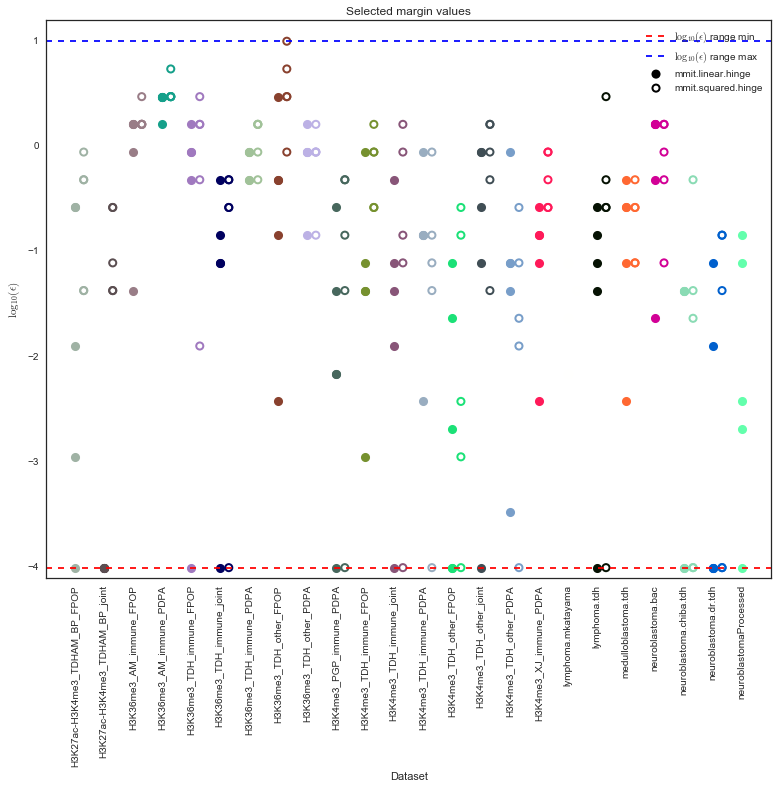

In [77]:
plt.clf()
for i, ds_hps in enumerate(linear_best_params_by_dataset):
    plt.scatter([i] * len(ds_hps), np.log10([s_hps["margin"] for s_hps in ds_hps]), edgecolor=cool_contrasting_cmap[i],
                facecolor=cool_contrasting_cmap[i], linewidth=2, s=50)

for i, ds_hps in enumerate(squared_best_params_by_dataset):
    plt.scatter([i + 0.3] * len(ds_hps), np.log10([s_hps["margin"] for s_hps in ds_hps]), edgecolor=cool_contrasting_cmap[i],
                facecolor="None", linewidth=2, s=50)

plt.axhline(np.log10(min(params["margin"])), color="red", linestyle="--", label=r"$\log_{10}(\epsilon)$ range min")
plt.axhline(np.log10(max(params["margin"])), color="blue", linestyle="--", label=r"$\log_{10}(\epsilon)$ range max")
plt.xlim([-1, len(datasets)])
plt.ylim([np.log10(min(params["margin"])) - 0.1, np.log10(max(params["margin"])) + 0.2])
plt.xlabel("Dataset")
plt.xticks(range(len(datasets)), [d.name for d in datasets], rotation=90)
plt.ylabel(r"$\log_{10}(\epsilon)$")
plt.title("Selected margin values")

plt.scatter([-100], [-100], label="mmit.linear.hinge", facecolor="black", edgecolor="black", linewidth=2, s=50)
plt.scatter([-100], [-100], label="mmit.squared.hinge", facecolor="None", edgecolor="black", linewidth=2, s=50)
plt.legend()

plt.gcf().set_size_inches(13, 10)
plt.savefig("selected_margins.pdf", bbox_inches="tight")
plt.show()

### Alpha

max alpha 100


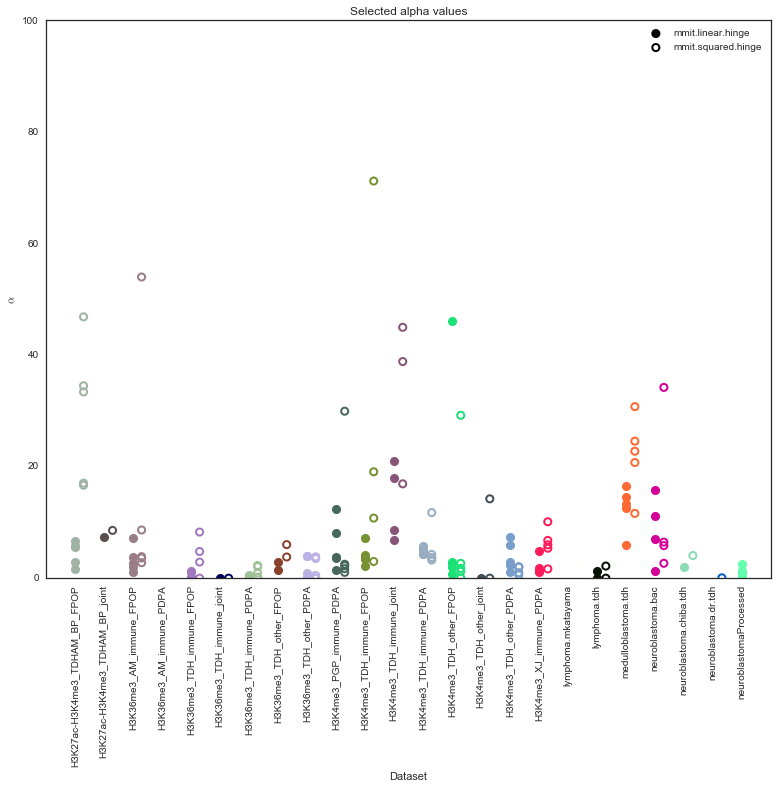

In [85]:
plt.clf()
max_alpha = -1
for i, ds_hps in enumerate(linear_best_params_by_dataset):
    alphas = [s_hps["alpha"] for s_hps in ds_hps]
    plt.scatter([i] * len(ds_hps), alphas, edgecolor=cool_contrasting_cmap[i],
                facecolor=cool_contrasting_cmap[i], linewidth=2, s=50)
    max_alpha = max(max_alpha, min(max(alphas), 100))
    
for i, ds_hps in enumerate(squared_best_params_by_dataset):
    alphas = [s_hps["alpha"] for s_hps in ds_hps]
    plt.scatter([i + 0.3] * len(ds_hps), alphas, edgecolor=cool_contrasting_cmap[i],
                facecolor="None", linewidth=2, s=50)
    max_alpha = max(max_alpha, min(max(alphas), 100))

#plt.axhline(min(params["alpha"]), color="red", linestyle="--", label="$\alpha$ range min")
#plt.axhline(max(params["alpha"]), color="blue", linestyle="--", label="$\alpha$ range max")
print("max alpha", max_alpha)
plt.xlim([-1, len(datasets)])
plt.ylim([0., max_alpha + 0.2])
plt.xlabel("Dataset")
plt.xticks(range(len(datasets)), [d.name for d in datasets], rotation=90)
plt.ylabel(r"$\alpha$")
plt.title("Selected alpha values")

plt.scatter([-100], [-100], label="mmit.linear.hinge", facecolor="black", edgecolor="black", linewidth=2, s=50)
plt.scatter([-100], [-100], label="mmit.squared.hinge", facecolor="None", edgecolor="black", linewidth=2, s=50)
plt.legend()

plt.gcf().set_size_inches(13, 10)
plt.savefig("selected_alphas.pdf", bbox_inches="tight")
plt.show()

## Model lengths

IOError: [Errno 2] No such file or directory: u'./predictions/mmit.squared.hinge/neuroblastomaProcessed/models.tsv'

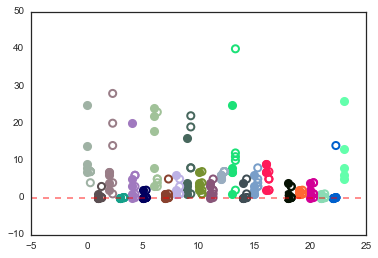

In [86]:
plt.clf()
plt.axhline(0.0, color="red", linestyle="--", alpha=0.5)
max_len = 0
for i, ds in enumerate(datasets):
    model_lengths = [int(l.split("\t")[1].count("Node")) for l in open(join("./predictions/mmit.linear.hinge", ds.name, "models.tsv"))]
    plt.scatter([i] * len(model_lengths), model_lengths, edgecolor=cool_contrasting_cmap[i],
                facecolor=cool_contrasting_cmap[i], linewidth=2, s=50)
    max_len = max(max_len, max(model_lengths))
for i, ds in enumerate(datasets):
    model_lengths = [int(l.split("\t")[1].count("Node")) for l in open(join("./predictions/mmit.squared.hinge", ds.name, "models.tsv"))]
    plt.scatter([i + 0.3] * len(model_lengths), model_lengths, edgecolor=cool_contrasting_cmap[i],
                facecolor="None", linewidth=2, s=50)
    max_len = max(max_len, max(model_lengths))

plt.xlabel("Dataset")
plt.xlim([-1, len(datasets)])
plt.ylim([-1, max_len + 1])
plt.xticks(range(len(datasets)), [d.name for d in datasets], rotation=90)
plt.ylabel("Number of rules in the tree")
plt.title("Size of the models for each dataset")

plt.scatter([-100], [-100], label="mmit.linear.hinge", facecolor="black", edgecolor="black", linewidth=2, s=50)
plt.scatter([-100], [-100], label="mmit.squared.hinge", facecolor="None", edgecolor="black", linewidth=2, s=50)
plt.legend()

plt.gcf().set_size_inches(13, 10)
plt.savefig("model_sizes.pdf", bbox_inches="tight")
plt.show()

### CV score with respect to alpha

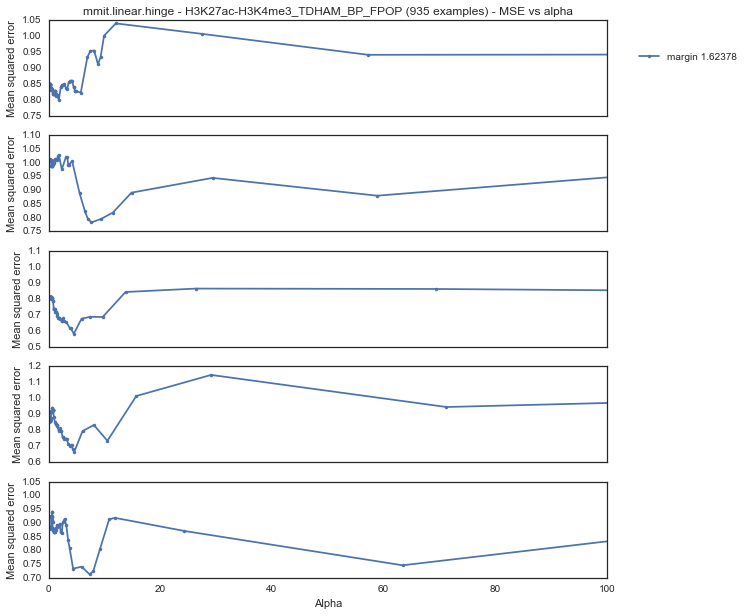

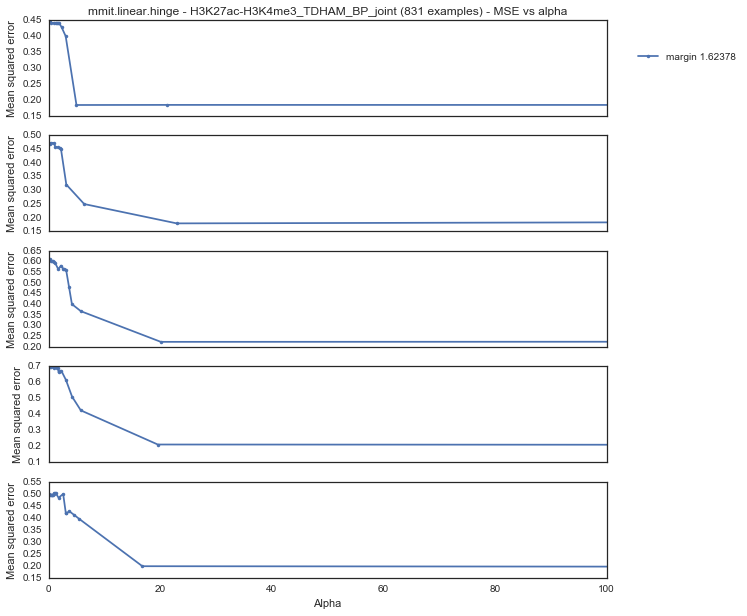

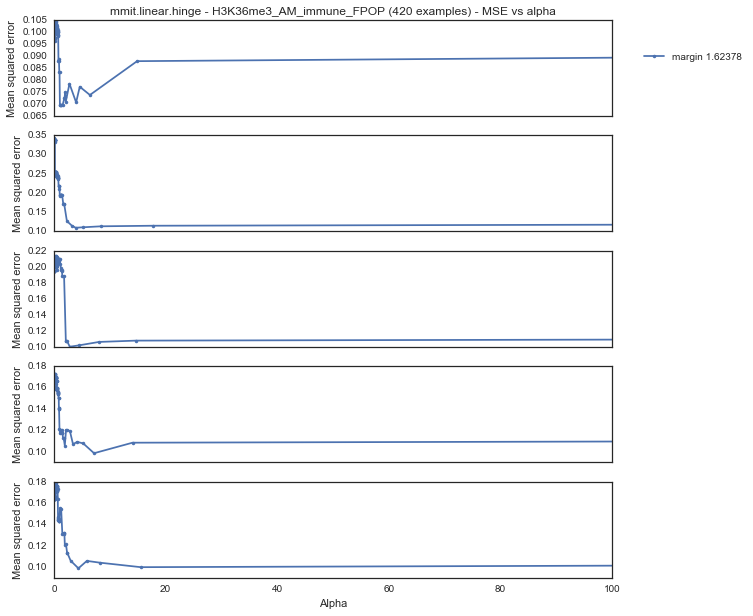

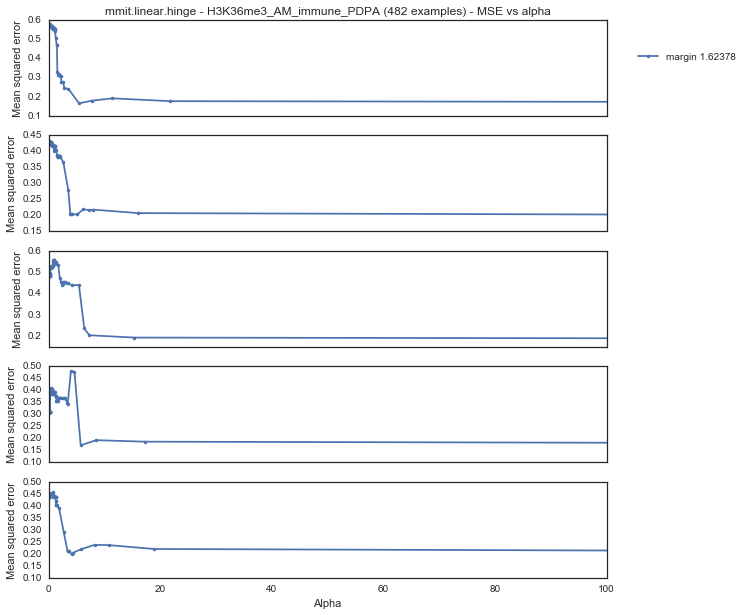

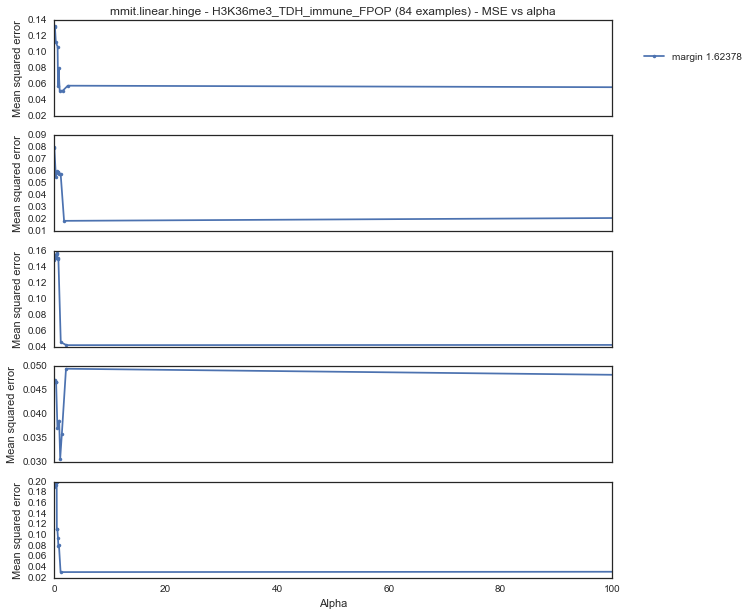

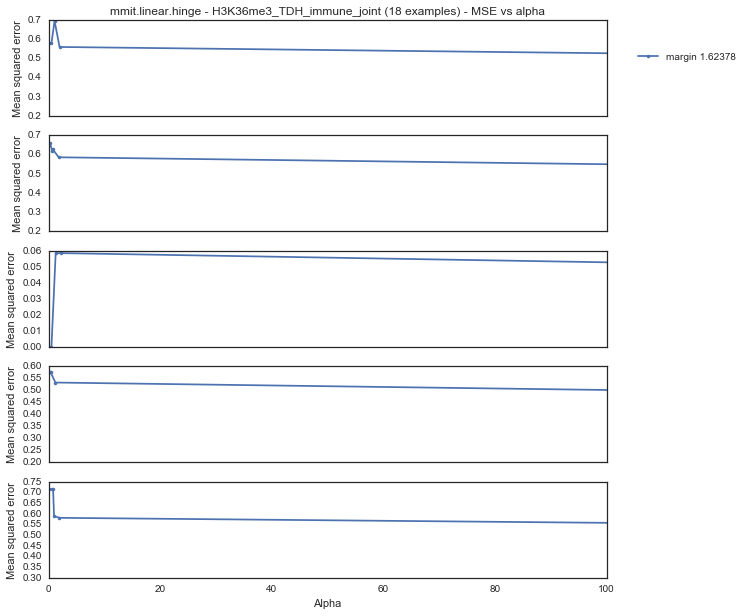

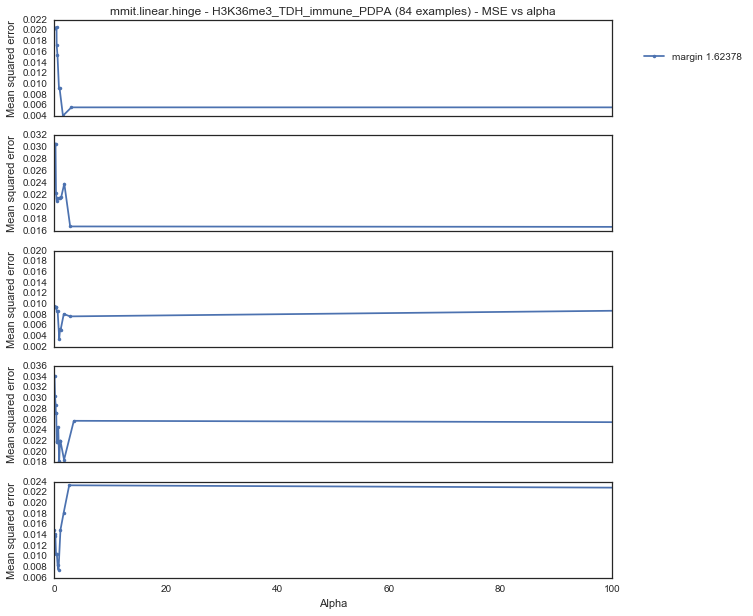

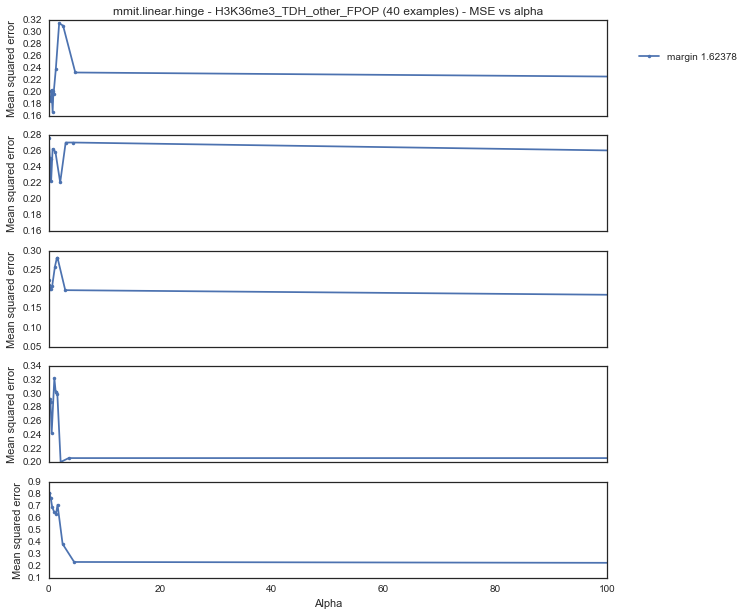

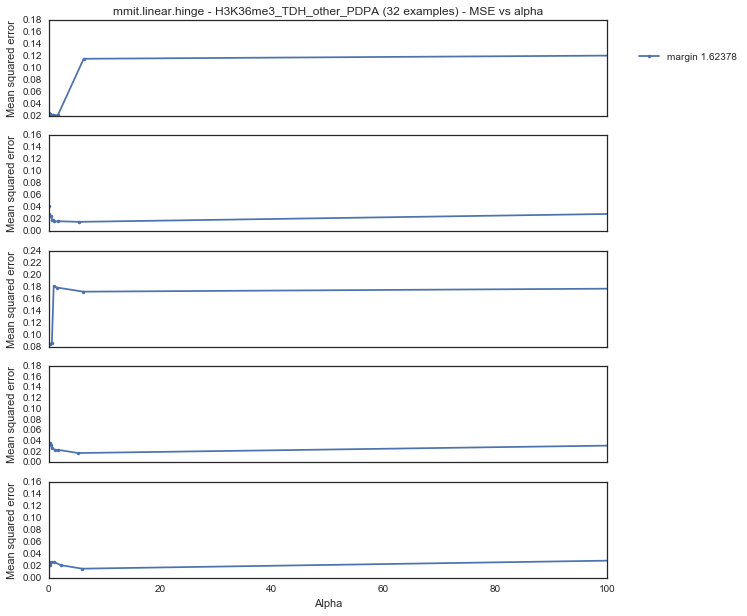

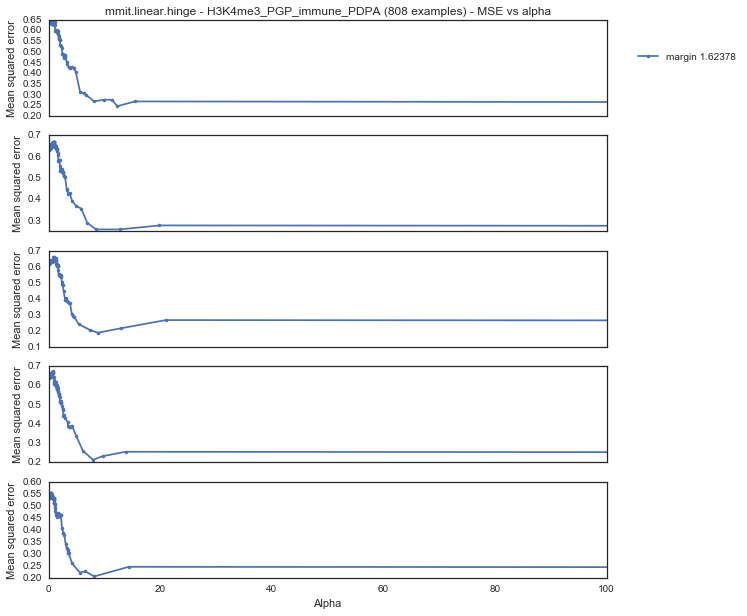

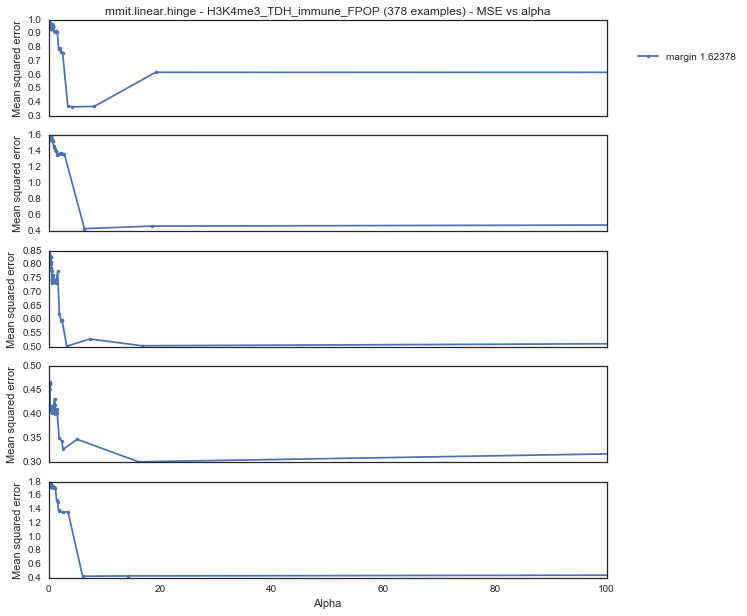

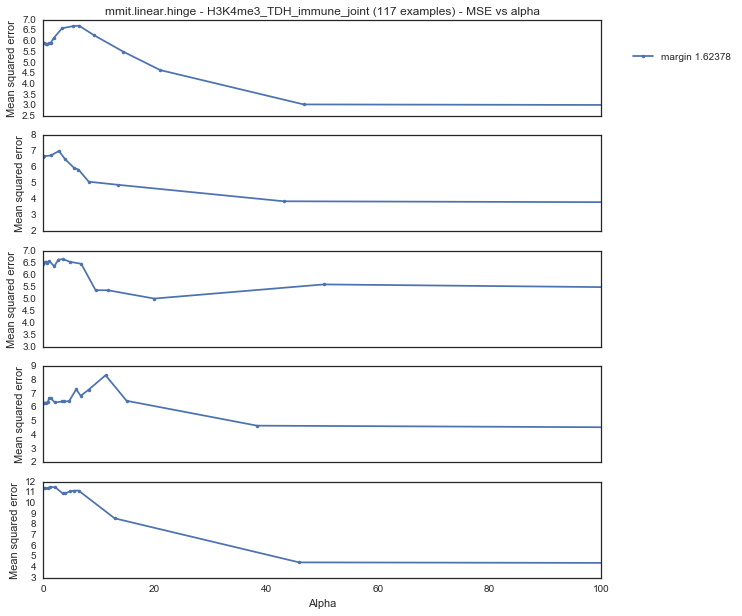

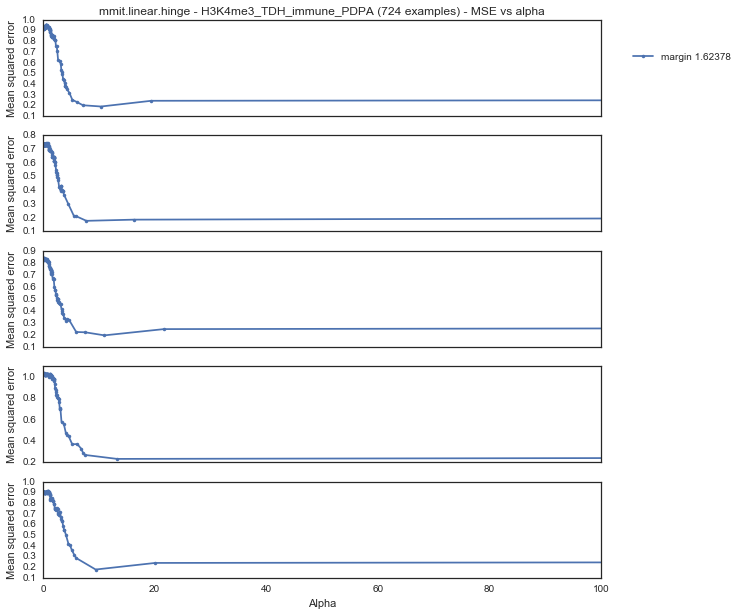

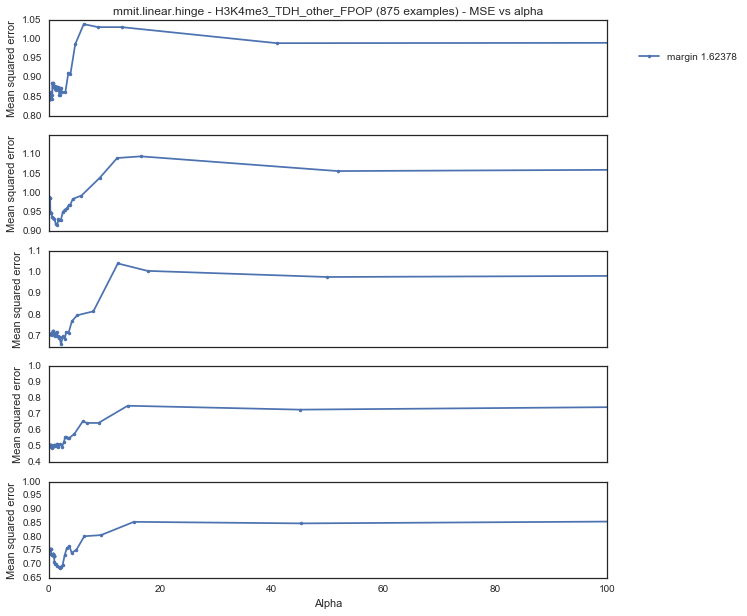

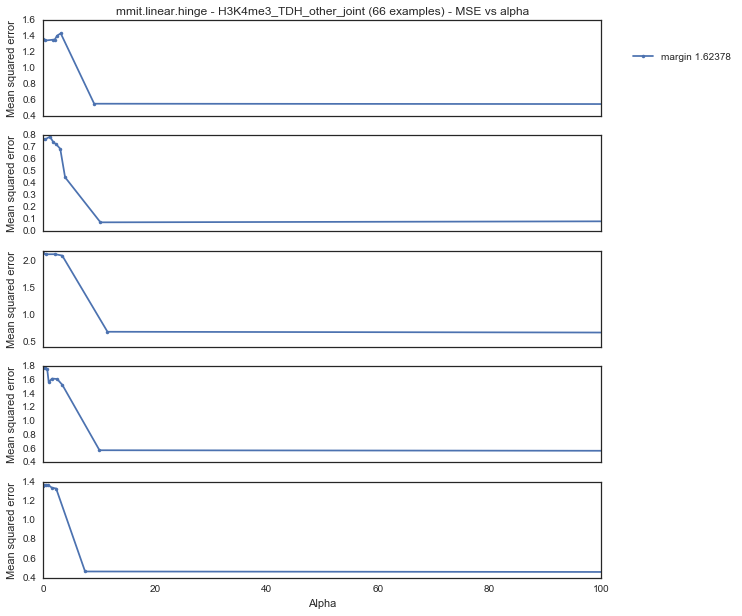

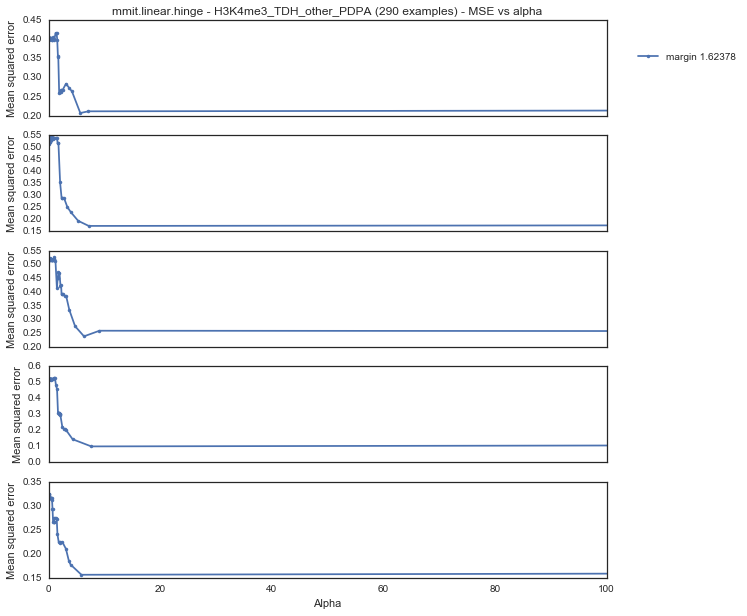

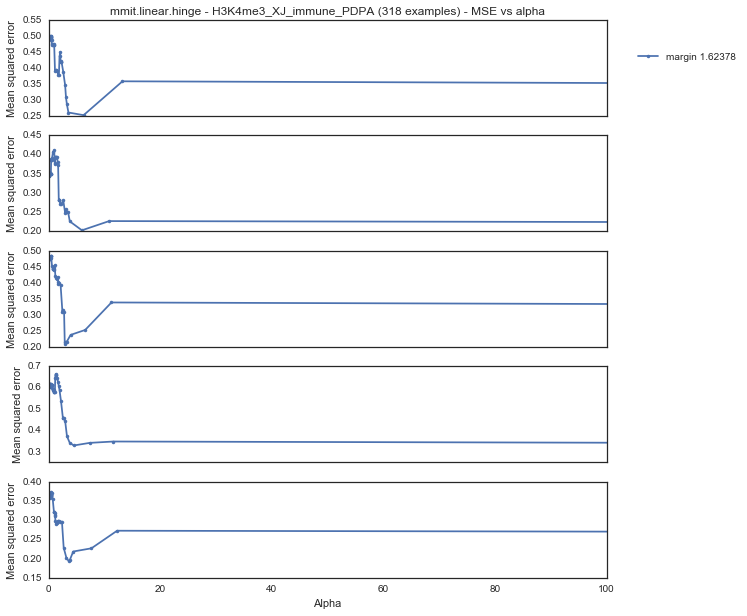

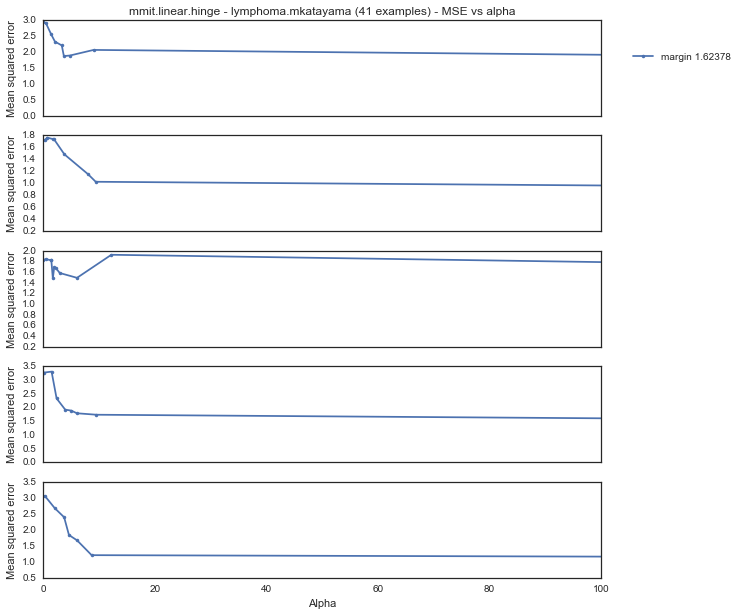

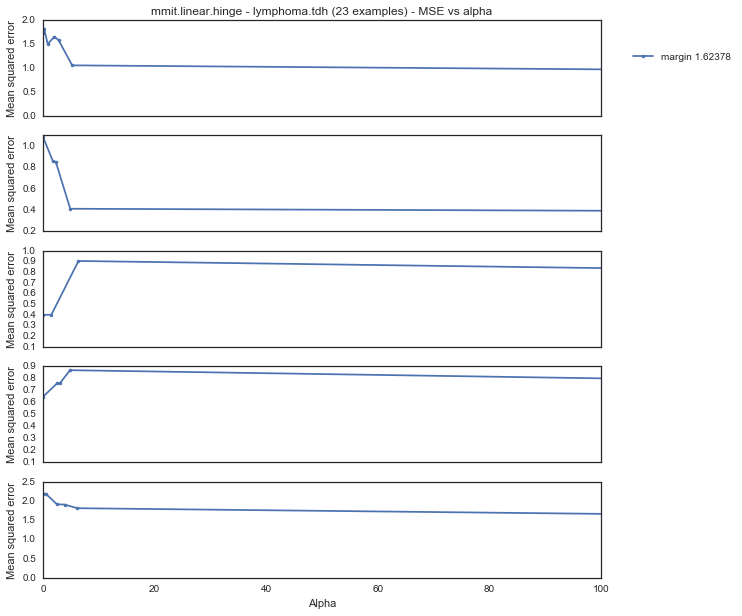

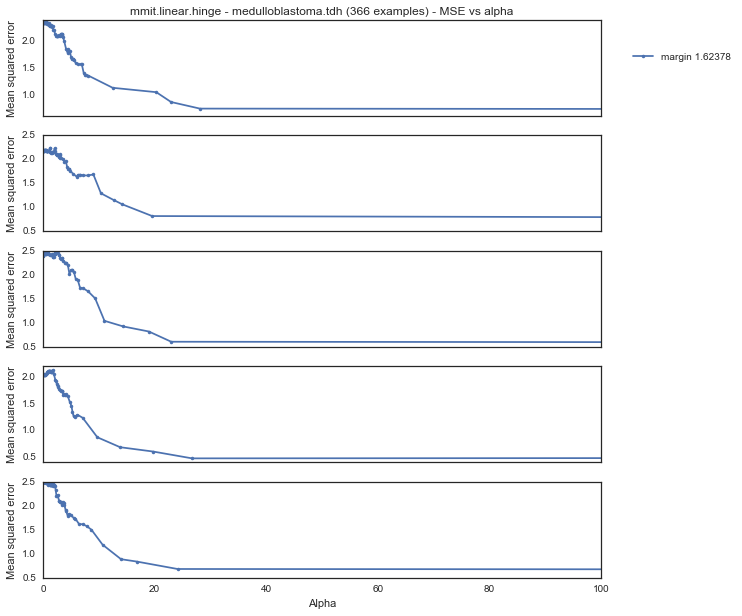

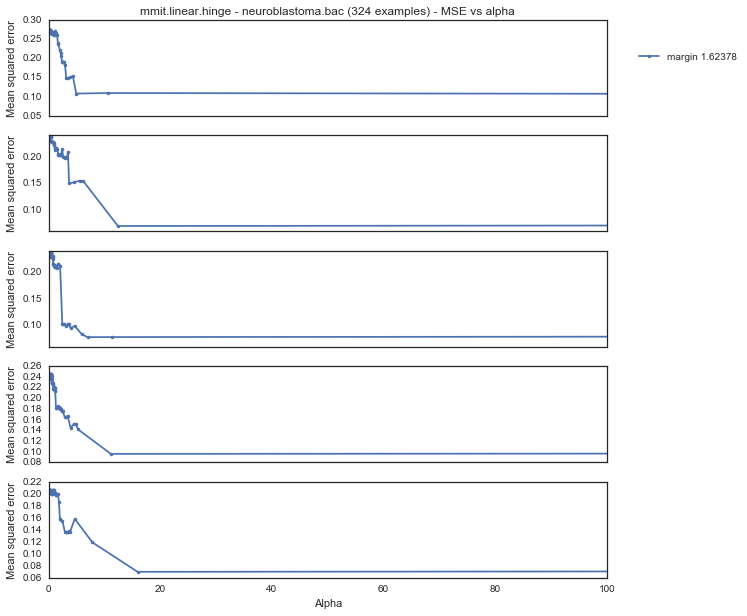

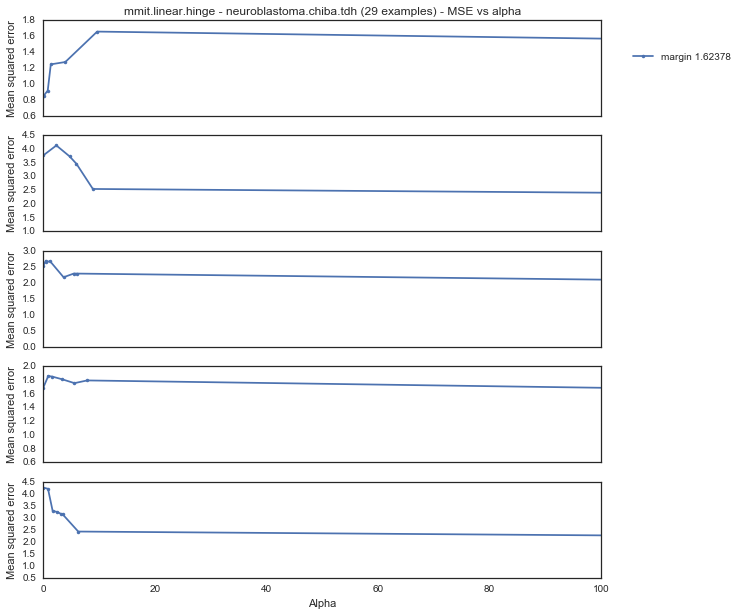

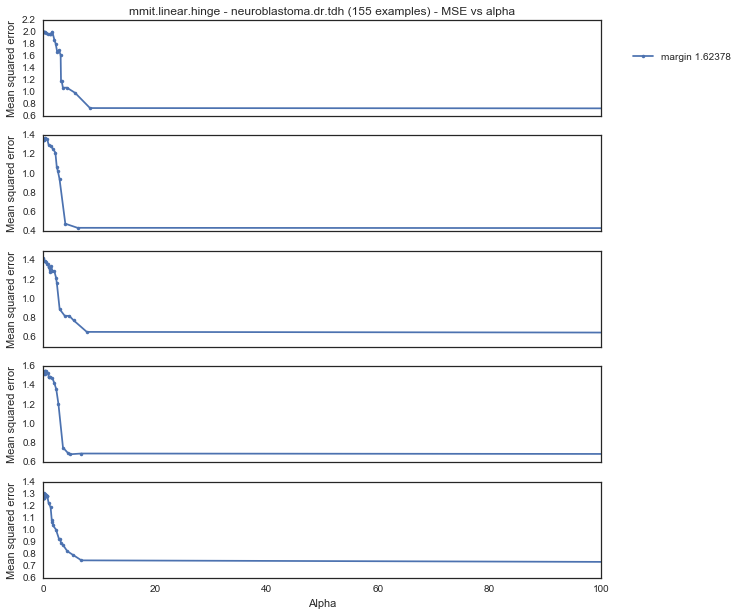

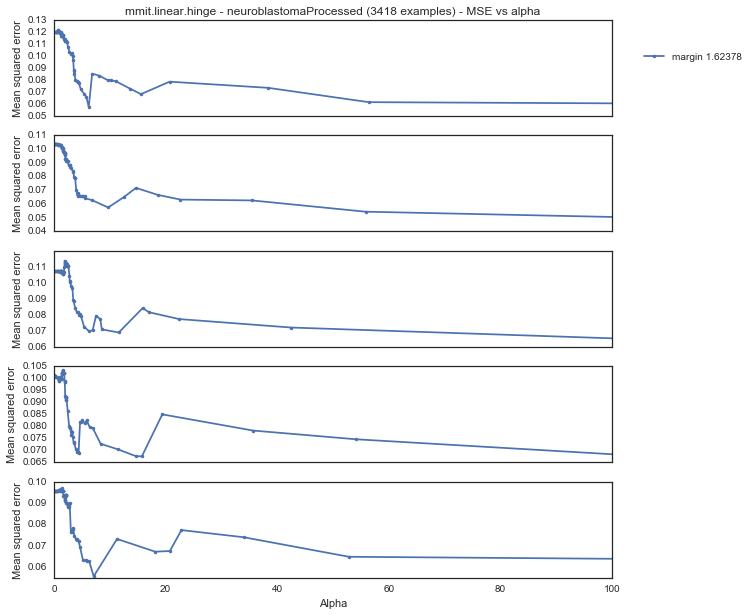

In [103]:
for i, ds_cv_results in enumerate(linear_cv_results_by_dataset):
    
    plt.clf()
    f, subplots = plt.subplots(len(ds_cv_results), sharex=True)
    f.set_size_inches(10, 10)
    
    for j, split_cv_results in enumerate(ds_cv_results):
        margin_values = np.array([r[0]["margin"] for r in split_cv_results])
        alpha_values = np.array([r[0]["alpha"] for r in split_cv_results])
        score_values = np.array([r[1] for r in split_cv_results]) * -1  # Convert negative MSE to MSE
                
        for margin in np.unique(margin_values)[-4:-3]:
            m_alphas = alpha_values[np.isclose(margin_values, margin)]
            m_scores = score_values[np.isclose(margin_values, margin)]
            sorter = np.argsort(m_alphas)
            m_alpha = m_alphas[sorter]
            m_scores = m_scores[sorter]
            
            # Do something with the infinite alpha values
            #m_alpha1 = m_alpha[~np.isinf(m_alpha)]
            #m_scores1 = m_scores[~np.isinf(m_alpha)]
            m_alpha1 = np.array(m_alpha)
            m_alpha1[np.isinf(m_alpha)] = 1000
            m_scores1 = np.array(m_scores)
            
            subplots[j].plot(m_alpha1, m_scores1, label="margin {0:.5f}".format(margin), marker=".")
        subplots[j].set_ylabel("Mean squared error")
    
    plt.xlim(0, 100)
    plt.xlabel("Alpha")
    subplots[0].set_title("mmit.linear.hinge - {0!s} ({1:d} examples) - MSE vs alpha".format(datasets[i].name, 
                                                                                             datasets[i].n_examples))
    plt.legend(bbox_to_anchor=(1.05, 5.5), loc=2, borderaxespad=0.)
    plt.savefig("mse_vs_alpha_linear_hinge_{0!s}.pdf".format(datasets[i].name))
    plt.show()